# Comparing the communication of German politicians across Twitter and plenary speeches using topic modelling and sentiment analysis

# Part II

In [1]:
# Import packages again for new notebooks

# Import basic Python packages
import os
import re
import pickle
import random
import warnings
from collections import Counter
from functools import partial

# Import util packages
from tqdm.notebook import tqdm

# Import data processing packages
import numpy as np
import pandas as pd
import psycopg2

# Import visualisation packages
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.dates as mdates
from scipy.ndimage.filters import gaussian_filter1d

# Import natural language processing packages
import spacy
from spacy_sentiws import spaCySentiWS
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from spacy.tokens.doc import Doc
from spacy.vocab import Vocab
import nltk

# Import topic modelling packages
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LdaMulticore
from gensim.models.nmf import Nmf
import pyLDAvis
import pyLDAvis.gensim_models
from bertopic import BERTopic

# Import sentiment dictionaries
from textblob_de import TextBlobDE as TextBlob

# Import metrics packages
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix

# Import interface widgets
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import clear_output, display

# Set package options
pd.options.mode.chained_assignment = None
tqdm.pandas()
pyLDAvis.enable_notebook()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/jakob/opt/miniconda3/envs/amca/lib/python3.8/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/jakob/opt/miniconda3/envs/amca/lib/python3.8/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/jakob/opt/miniconda3/envs/amca/lib/python3.8/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/jakob/opt/miniconda3/envs/amca/lib/python3.8/site-packages/plotly/graph_objs/__init__.py:287: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ip

# 4. Results

# 4.1 Topic modelling results (Jakob)

Based on the model selection and creation in section 3.5, we will now analyse the results to answer our first three research questions:

* **RQ 1.1** What are the main topics of tweets of prominent politicians of the six parties in the German Parlament in the period of the 19th Bundestag?

* **RQ 1.2** What are the main topics of speeches of prominent politicians of the six parties in the German Parlament in the period of the 19th Bundestag?

+ **RQ 1.3** How do the main topics of tweets and speeches of prominent politicians of the six parties in the German Parlament differ in the period of the 19th Bundestag?

For this, we visualise the results and deep dive into several topics. We cannot make an exhaustive interpretation of all topics of our models, as this would be out of scope for this work. We still provide the code for an exhaustive analysis so that the interested reader can execute the analysis on his own.

## 4.1.1 Analyse tweets model

We use the trained BERTopic model for tweets from the last section to answer the first research question. We load the pre-trained model and the resulting data. If the model is retrained, one can skip this step.

In [2]:
# Load data
tweets_processed_bert = pickle.load(open( "../data/processed/tweets_processed_bert.pickle", "rb" ))
docs_tweets = tweets_processed_bert.text_preprocessed_sentence.tolist()
with open('../data/processed/probabilities_tweets_bert.pickle', 'rb') as handle:
    probs_tweets = pickle.load(handle)
with open('../data/processed/topics_tweets_bert.pickle', 'rb') as handle:
    topics_tweets = pickle.load(handle)

In [3]:
# Load model
topic_model_tweets = BERTopic.load("../models/bertopic_tweets")

### 4.1.1.1 Overview of topics

We reduced the model to 100 topics, increasing our coherence and creating one large, not very expressive topic that gives no insights. To avoid this problem, we would need to do hyperparameter optimisation with the number of topics and the preprocessing, which is out of scope based on computational restrictions. We will now focus on topics that can be interpreted.

In [4]:
topic_model_tweets.get_topic_info().head(10)

Topic  Count                                            Name
0     -1  83650                     -1_afd_mal_bundestag_mensch
1      0   2494                 0_tweet_twitter_tweets_twittern
2      1   1837  1_digitalisierung_digital_digitale_digitalpakt
3      2   1765                      2_schön_kaffee_trinken_tee
4      3   1739                3_arbeit_sanktion_homeoffice_job
5      4   1710                       4_grüne_grüner_grün_linke
6      5   1627      5_europa_europäisch_europäische_europawahl
7      6   1543            6_euro_deutschland_million_milliarde
8      7   1515     7_polizei_polizist_polizistin_bundespolizei
9      8   1339           8_arzt_pflege_gesundheit_pflegekräfte

In [5]:
topic_model_tweets.get_topic_info().tail(10)

Topic  Count                                            Name
91      90    325           90_maske_maskenpflicht_tragen_abstand
92      91    323  91_wirecard_untersuchungsausschuss_bafin_zeuge
93      92    323   92_meinungsfreiheit_freiheit_plattform_netzdg
94      93    311  93_china_hongkong_sicherheitsgesetz_chinesisch
95      94    298   94_jamaika_sondierung_fdp_jamaikasondierungen
96      95    293       95_hab_sorry_entschuldigung_entschuldigen
97      96    293              96_krampfgegenrechts_aas_idz_troll
98      97    292            97_meinen_ingenieur_ernst_überzeugen
99      98    291          98_interview_lesen_überschrift_anhören
100     99    287          99_wald_natur_artenvielfalt_ökologisch

In [6]:
topic_model_tweets.visualize_barchart(topics=None, top_n_topics=25, n_words=5, width=250, height=250)

Even though we have already identified some weaknesses in the model, we can see that there are many exciting topics that we can use for further analysis.

### 4.1.1.2 Visualise topic correlation

Another critical quality indicator is the similarity of the topics. If we have very similar topics, they will not be very selective and lead to skewed topic distributions.

In [7]:
topic_model_tweets.visualize_heatmap(top_n_topics=100, width=800, height=800)

We can see a substantial similarity between some topics. Interestingly these are topics that seem to be not well defined and do not show high inner topic coherence from a human perspective. With a more sophisticated preprocessing and hyperparameter optimisation, we could handle this problem. We will focus on topics that are not highly correlated with other topics and seems to have a coherent meaning in our further analysis to avoid distorted topics.

### 4.1.1.3 Visualise topic hierarchy

To analyse the topic cluster of the resulting BERTopic model, we will use the inherent clustering of the model. We use the inherent clustering to identify significant clusters that we analyse in more detail.

In [8]:
# Visualise topic hierarchy
topic_model_tweets.visualize_hierarchy(top_n_topics=100)

In [9]:
# Visualise topic distance map
topic_model_tweets.visualize_topics(top_n_topics=100)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We identified twelve larger topic clusters based on the clustering and our evaluation. We will analyse three of the cluster in detail, while the other clusters are shortly described, and code for more profound analysis is provided. We only selected clusters that contained topics with political and societal relevance. This limitation excludes topics that only comprise interhuman relationship building and Smalltalk. There are many more topics and clusters that we could cover, but this is out of scope for this work.

### 4.1.1.4 Analyse topics

In [10]:
# Prepare time based visualisation
tweets_topics_over_time = topic_model_tweets.topics_over_time(docs_tweets, topics_tweets,
                                                       pd.to_datetime(tweets_processed_bert.date).dt.strftime('%Y-%m'),
                                                       nr_bins=None, datetime_format=None, evolution_tuning=True,
                                                       global_tuning=True)

46it [00:46,  1.01s/it]


#### 4.1.1.4.1 Cluster migration

The first cluster covering migration contains topics 15, 19, 53 and 59. It includes the subjects migration, asylum, refugees and family reunions. We deep dive into the analysis of the topic to better understand the subject area.

In [11]:
# Define cluster
cluster_1_migration = [15, 19, 53, 59]

In [12]:
# Visualise topic hierarchy
topic_model_tweets.visualize_hierarchy(top_n_topics=100, topics = cluster_1_migration)

In [13]:
# Analyse the cluster over time
topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_1_migration)

The frequency of tweets concerning migration and asylum topics peaked around the second half of the year 2018. After this time point, they are decreasing. One can correlate this peak with the discussion about the [global compact for migration](https://refugeesmigrants.un.org/migration-compact) from the United Nations and other debates about immigration and asylum in this period.

In [14]:
# See the party distribution of the cluster
tweets_cluster_1_migration =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_1_migration)]
print(tweets_cluster_1_migration.groupby("party").size().sort_values(ascending = False))
print("\n")
print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

party
AFD      945
FDP      562
SPD      396
Linke    293
Grüne    243
CDU      197
dtype: int64


party
FDP      35838
AFD      30178
SPD      29695
Linke    20366
Grüne    17811
CDU      14424
dtype: int64


ADF tweets significantly more about the topic of migration asylum compared to the other parties controlling their general tweet frequency. The remaining distribution of tweets seems to be proportional to the number of tweets of the parties in general.

In [15]:
# See the most prominent politicians of the cluster
tweets_cluster_1_migration.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Götz Frömming         301
Saskia Esken          218
Niema Movassat        165
Stephan Brandner      156
Beatrix von Storch    154
Alice Weidel          147
Matthias Hauer        133
Marco Buschmann       131
Joana Cotar           129
Christian Lindner     115
dtype: int64

The distribution of the politicians seems to correlate with the identified distribution of the parties. An interesting next step could be to investigate the sentiment of the different politicians and parties for the topic.

#### 4.1.1.4.2 Cluster media

The topics 0, 44, 78, 79, 88 and 98 form the cluster media. The cluster comprises social media, press, and other communication media subjects.

In [16]:
cluster_2_media = [0, 44, 78, 79, 88, 98]

In [17]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_2_media)

In [18]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_2_media =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_2_media)]
# print(tweets_cluster_2_media.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [19]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_2_media.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.3 Cluster extremism and religion

The next cluster comprises the topics 36, 47, 73, 76, which deal with the subjects extremism and religion.

In [20]:
cluster_3_extremism_religion  = [36, 47, 73, 76]

In [21]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the clruster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_3_extremism_religion)

In [22]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_3_extremism_religion =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_3_extremism_religion)]
# print(tweets_cluster_3_extremism_religion.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [23]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_3_extremism_religion.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.4 Cluster foreign politics and armed conflicts

The fourth cluster combines the topics 22, 32, 41, 56, 89 and 93. The main issues of this cluster are armed conflicts and defence topics.

In [24]:
cluster_4_foreign_politics_armed_conflicts = [22, 32, 41, 56, 89, 93]

In [25]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_4_foreign_politics_armed_conflicts)

In [26]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_4_foreign_politics_armed_conflicts =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_4_foreign_politics_armed_conflicts)]
# print(tweets_cluster_4_foreign_politics_armed_conflicts.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [27]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_4_foreign_politics_armed_conflicts.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.5 Cluster discrimination

Another prominent topic area is discrimination and racism that we combined in the fifth cluster with the topics 13, 23, 37, 40 and 72.

In [28]:
cluster_5_discrimination = [13, 23, 37, 40, 72]

In [29]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_5_discrimination)

In [30]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_5_discrimination =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_5_discrimination)]
# print(tweets_cluster_5_discrimination.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [31]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_5_discrimination.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.6 Cluster Covid-19

The Covid-19 cluster comprises topics 8, 9, 29, 54, 65, 71 and 90. We analyse this cluster in more detail.

In [32]:
cluster_6_covid = [8, 9, 29, 54, 65, 71, 90]

In [33]:
# Analyse the cluster over time
topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_6_covid)

The time series of the cluster can be easily related to the development of the worldwide pandemic situation. We have a higher frequency of tweets in times of high infections and restrictions and fewer tweets in summer when the situation is more relaxed.

In [34]:
# See the party distribution of the cluster
tweets_cluster_6_covid =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_6_covid)]
print(tweets_cluster_6_covid.groupby("party").size().sort_values(ascending = False))
print("\n")
print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

party
SPD      1540
FDP       966
Linke     876
CDU       588
AFD       570
Grüne     381
dtype: int64


party
FDP      35838
AFD      30178
SPD      29695
Linke    20366
Grüne    17811
CDU      14424
dtype: int64


SPD has a much higher number of tweets than the other parties concerning this cluster. This difference can be explained by the number of tweets of the prominent SPD politician Karl Lauterbach as we can see in the following code cell. It could be interesting to go into a deeper analysis of his tweets, television and other media appearances to understand his political career better.

In [35]:
# See the most prominent politicians of the cluster
tweets_cluster_6_covid.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Karl Lauterbach      1166
Marco Buschmann       507
Niema Movassat        463
Jens Spahn            302
Saskia Esken          262
Stephan Brandner      152
Götz Frömming         152
Bernd Riexinger       150
Joana Cotar           147
Christian Lindner     127
dtype: int64

#### 4.1.1.4.7 Cluster democratic structures

The topics in clusters 16, 24, 27, 34, 38 and 74 focus on general parliamentary and democratic structures.

In [36]:
cluster_7_democratic_structure = [16, 24, 27, 34, 38, 74]

In [37]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_7_democratic_structure)

In [38]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_7_democratic_structure =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_7_democratic_structure)]
# print(tweets_cluster_7_democratic_structure.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [39]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_7_democratic_structure.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.8 Cluster Germany and EU

Cluster 8 comprises topics 5, 6, 35, 51 and 70, focusing on Europe, the EU and Germany.

In [40]:
cluster_8_germany_in_europe = [5, 6, 35, 51, 70]

In [41]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_8_germany_in_europe)

In [42]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_8_germany_in_europe =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_8_germany_in_europe)]
# print(tweets_cluster_8_germany_in_europe.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [43]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_8_germany_in_europe.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.9 Cluster finance

Another cluster consists of topics 14, 39, 67, 91 that cover topics around finance.

In [44]:
cluster_9_finance = [14, 39, 67, 91]

In [45]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_9_finance)

In [46]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_9_finance =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_9_finance)]
# print(tweets_cluster_9_finance.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [47]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_9_finance.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.10 Cluster police and safety

The cluster policy and safety comprise three topics  7, 83 and 93 and cover the issues of police and safety.

In [48]:
cluster_10_police_safety = [7, 83, 93]

In [49]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_10_police_safety)

In [50]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_10_police_safety =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_10_police_safety)]
# print(tweets_cluster_10_police_safety.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [51]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_10_police_safety.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.1.4.11 Cluster climate

Another cluster of interest consists of topics 12 and 99 and covers climate and nature. We will analyse the area in more detail.

In [52]:
cluster_11_climate = [12, 99]

In [53]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_11_climate)

An interesting trend in the data is a sharp increasing frequency of tweets until the beginning of the Covid-19 pandemic. After the pandemic's beginning, the topic lost importance in the tweeting behaviour of the politicians.

In [54]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
tweets_cluster_11_climate =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_11_climate)]
print(tweets_cluster_11_climate.groupby("party").size().sort_values(ascending = False))
print("\n")
print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

party
Grüne    444
FDP      269
SPD      239
AFD      214
Linke    114
CDU      101
dtype: int64


party
FDP      35838
AFD      30178
SPD      29695
Linke    20366
Grüne    17811
CDU      14424
dtype: int64


The party Die Grünen has the highest frequency of tweets concerning environmental topics. This observation is in line with the political agenda of the party.

In [55]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
tweets_cluster_11_climate.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Britta Haßelmann         139
Marco Buschmann          128
Karl Lauterbach          120
Stephan Brandner         111
Katrin Göring-Eckardt     74
Saskia Esken              72
Christian Lindner         62
Cem Özdemir               59
Steffi Lemke              58
Annalena Baerbock         53
dtype: int64

When analysing the list of the politicians that tweet about this with a high frequency, we can see many politicians of the party Die Grünen and other politicians that generally tweets with a high frequency.

#### 4.1.1.4.12 Cluster infrastructure

The last cluster containing topics 1, 18 and 87 covers digital and analogue infrastructure.

In [56]:
# cluster_12_infrastructure = [18, 87, 1]

In [57]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_tweets.visualize_topics_over_time(tweets_topics_over_time, topics=cluster_12_infrastructure)

In [58]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_12_infrastructure =  tweets_processed_bert[tweets_processed_bert.topic_id.isin(cluster_12_infrastructure)]
# print(tweets_cluster_12_infrastructure.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(tweets_processed_bert.groupby("party").size().sort_values(ascending = False))

In [59]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# tweets_cluster_12_infrastructure.groupby("full_name").size().sort_values(ascending = False).head(10)

### 4.1.1.5 Summary

In this section, we summarise the results concerning the initial research question:

**What are the main topics of tweets of prominent politicians of the six parties in the German Parlament in the period of the 19th Bundestag?**

We trained a BERTopic model to give us an overview of the topics presented in sections 4.1.1.1 - 4.1.1.3. Based on the identified topics and the inherent modelling clustering, we defined 12 overarching clusters of subjects that are presented in section 4.1.1.4. We did not include topics resulting from interhuman relationship building or Smalltalk. The cluster of the topics could now be used for further analysis. To answers the research question, we identified the following main topics of tweets of the selected politicians:

* Migration
* Media
* Extremism and feligion
* Foreign politics and armed conflicts
* Discrimination
* Covid-19
* Democratic structures
* Europe, EU and Germany
* Finance
* Police and safety
* Climate
* Infrastructure

We did a deep dive into the clusters migration, Covid-19 and environment. The code for deeper analysis of the other clusters is provided and can be used by the interested reader. Based on this analysis, we will compare the results with the topics of the speeches in the parliaments in section 4.1.3.

## 4.1.2 Analyse speeches model

To answer the second research question, we proceed the same as answering the first research question.

In [60]:
# Load data
speeches_processed_bert = pickle.load(open( "../data/processed/speeches_processed_bert.pickle", "rb" ))
docs_speeches = speeches_processed_bert.text_preprocessed_sentence.tolist()
with open('../data/processed/probabilities_speeches_bert.pickle', 'rb') as handle:
    probs_speeches = pickle.load(handle)
with open('../data/processed/topics_speeches_bert.pickle', 'rb') as handle:
    topics_speeches = pickle.load(handle)

### 4.1.2.1 Overview of topics

We already saw in the modelling section that we identified fewer topics for the speeches dataset. This effect corresponds to the significantly fewer number of documents in the dataset. We identified 25 topics in the modelling stage that we now analyse in more detail.

In [61]:
# Load model
topic_model_speeches = BERTopic.load("../models/bertopic_speeches")

In [62]:
# Show topic infos
topic_model_speeches.get_topic_info()

Topic  Count                                               Name
0      -1   1093                   -1_meinung_hilfe_herrn_verfahren
1       0    683     0_abgeordnete_rente_kommune_rentenversicherung
2       1    175              1_klimaschutz_energie_erneuerbaren_co
3       2    101                      2_virus_impfen_impfstoff_test
4       3     76                   3_pflege_patient_versorgung_arzt
5       4     74        4_digital_digitalisierung_internet_digitale
6       5     63    5_grundgesetz_grundrechte_grundgesetzes_artikel
7       6     62              6_russland_russisch_nawalny_russische
8       7     62                   7_afghanistan_irak_syrien_mandat
9       8     57                     8_student_bafög_schüler_eltern
10      9     50  9_arbeitsmarkt_wandel_beschäftigte_qualifizierung
11     10     45          10_migration_pakt_einwanderung_flüchtling
13     11     37              11_soldat_bundeswehr_soldatinnen_mali
12     12     37               12_außenpolitik_auswärtige_amt_waffe
14     13     33                 13_anschlag_opfer_hisbollah_muslim
15     14     32   14_gewalt_kriminalstatistik_polizei_polizeiliche
16     15     28       15_großbritannien_brexit_britisch_königreich
17     16     26              16_israel_jude_jüdisch_antisemitismus
18     17     23    17_geschlecht_mann_diskriminierung_homosexuelle
19     18     21  18_grundrechte_coronakrise_corona_grundrechtse...
20     19     20      19_china_hongkong_chinesisch_meinungsfreiheit
21     20     19                 20_nuklear_iran_atomwaffen_abkomme
22     21     15  21_kommission_lebensverhältnisse_ergebnis_rats...
23     22     12     22_cannabis_rauchen_tabakindustrie_werbeverbot
24     23     11      23_lieferkettengesetz_zukünftig_afrika_handel

In [63]:
topic_model_speeches.visualize_barchart(topics=None, top_n_topics=25, n_words=5, width=250, height=250)

### 4.1.2.2 Visualise topic correlation

To better understand the quality of our topic model, we analyse the similarity of the identified topics.

In [64]:
# Visualise correlation
topic_model_speeches.visualize_heatmap(top_n_topics=25)

The first two topics have a similar score with various other topics. This fact could skew our results and has to be minded when interpreting the results.

### 4.1.2.3 Visualise topic hierarchy

To analyse the topic cluster of the resulting BERTopic model, we will use the inherent clustering of the model.

In [65]:
# Visualise clustering
topic_model_speeches.visualize_hierarchy(orientation='left', top_n_topics=25, width=1000, height=600)

In [66]:
# Visualise topic distance
topic_model_speeches.visualize_topics(topics=None, top_n_topics=None, width=650, height=650)

### 4.1.2.4 Analyse topics

We identified 12 clusters and topics that we now analyse in more detail.

In [67]:
# Prepare time based visualisation
speeches_topics_over_time = topic_model_speeches.topics_over_time(docs_speeches, topics_speeches, pd.to_datetime(speeches_processed_bert.date).dt.strftime('%Y-%m'),
                                                       nr_bins=None, datetime_format=None, evolution_tuning=True,
                                                       global_tuning=True)

41it [00:04,  9.43it/s]


#### 4.1.2.4.1 Cluster europe

The first cluster is based on topics 21 and 23 and deals with Europe and the EU.

In [68]:
cluster_1_europe = [21, 23]

In [69]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_1_europe)

In [70]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_1_europe = speeches_processed_bert[speeches_processed_bert.topic_id.isin([5, 18, 21])]
# print(speeches_cluster_1_europe.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [71]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_1_europe.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.2 Cluster democratic structures

The second cluster comprises only the topic democratic structures.

In [72]:
cluster_2_democratic = [5]

In [73]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_2_democratic)

In [74]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_2_democratic = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_2_democratic)]
# print(speeches_cluster_2_democratic.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [75]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_2_democratic.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.3 Cluster Covid-19

The third cluster contains topics 2 and 18 concerning health and the covid pandemic. We will analyse the prevalence of the topics per time and party.

In [76]:
cluster_3_covid = [18, 2]

In [77]:
# Analyse the cluster over time
topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_3_covid)

We can identify two peaks of the subject that mirror the development of the pandemic situation. We already saw this trend in the analysis of the tweets.

In [78]:
# See the party distribution of the cluster
speeches_cluster_3_various = speeches_processed_bert[speeches_processed_bert.topic_id.isin([0,7,8,12])]
print(speeches_cluster_3_various.groupby("party").size().sort_values(ascending = False))
print("\n")
print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

party
SPD      181
FDP      165
AFD      149
Grüne    149
CDU      114
Linke     81
dtype: int64


party
SPD      557
CDU      551
FDP      507
AFD      502
Grüne    448
Linke    290
dtype: int64


There are no apparent patterns in the distribution of the speeches per party.

In [79]:
# See the most prominent politicians of the cluster
speeches_cluster_3_various.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Heiko Maas                       82
Britta Haßelmann                 69
Hubertus Heil                    65
Stephan Brandner                 57
Götz Frömming                    48
Johannes Vogel                   40
Alexander Graf Lambsdorff        35
Peter Altmaier                   35
Jens Spahn                       31
Marie-Agnes Strack-Zimmermann    27
dtype: int64

When analysing the data, we see a surprising pattern as neither Jens Spahn nor Karl Lauterbach are in the list of the persons with the most speeches for this topic.

#### 4.1.2.4.4 Cluster foreign politics

The largest cluster combines seven topics (6, 7, 11, 12, 15, 19, 20) concerning foreign politics.

In [80]:
cluster_4_foreign_politics = [6, 7, 11, 12, 15, 19, 20]

In [81]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_4_foreign_politics)

In [82]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_4_foreign_politics = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_4_foreign_politics)]
# print(speeches_cluster_4_foreign_politics.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [83]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_4_foreign_politics.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.5 Cluster occupations

The next cluster contains topics 8 and 9 and deals with the subject occupations.

In [84]:
cluster_5_occupation = [8, 9]

In [85]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_5_occupation)

In [86]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_5_occupation = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_5_occupation)]
# print(speeches_cluster_5_occupation.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [87]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_5_occupation.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.6 Cluster discrimination

The sixth cluster is only topic 17 that treats the issue of migration.

In [88]:
cluster_6_discrimination = [17]

In [89]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_6_discrimination)

In [90]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_6_discrimination = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_6_discrimination)]
# print(speeches_cluster_6_discrimination.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [91]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_6_discrimination.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.7 Cluster police and safety

Another cluster comprises only one topic (14) and deals with police and safety.

In [92]:
cluster_7_police_safety = [14]

In [93]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_7_police_safety)

In [94]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_7_police_safety = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_7_police_safety)]
# print(speeches_cluster_7_police_safety.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [95]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_7_police_safety.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.8 Cluster climate

Cluster eight (topic 1) includes speeches about climate change and protection. To get an overview of the topic, we analyse it in more detail.

In [96]:
cluster_8_climate = [1]

In [97]:
# Analyse the cluster over time
topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_8_climate)

There are two peaks for the topics around the end of 2019, 2020 and 2021. The main topics of the peaks were renewable energy topics.

In [98]:
# See the party distribution of the cluster
speeches_cluster_8_climate = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_8_climate)]
print(speeches_cluster_8_climate.groupby("party").size().sort_values(ascending = False))
print("\n")
print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

party
Grüne    65
CDU      60
AFD      26
SPD      12
FDP       7
Linke     5
dtype: int64


party
SPD      557
CDU      551
FDP      507
AFD      502
Grüne    448
Linke    290
dtype: int64


There is a substantial difference in the number of speeches covering the subject. The parties Die Grüne and CDU cover this topic in their speeches more than other parties controlled for their general frequency of speeches. Most of the speeches of the CDU are held by Peter Altmaier, as we see in the following code snippet.

In [99]:
# See the most prominent politicians of the cluster
speeches_cluster_8_climate.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Peter Altmaier           59
Steffi Lemke             28
Cem Özdemir              15
Leif-Erik Holm           13
Annalena Baerbock        11
Katrin Göring-Eckardt     7
Tino Chrupalla            6
Christian Lindner         6
Hubertus Heil             5
Heiko Maas                4
dtype: int64

We observe many politicians of the party Die Grünen and the CDU politican Peter Altmaier. He was the federal minister for energy and economy, which explains his top position in the overview.

#### 4.1.2.4.9 Cluster digitalisation

In the ninth cluster is topic 4, covering digitalisation.

In [100]:
cluster_9_digitalisation = [4]

In [101]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_9_digitalisation)

In [102]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_9_digitalisation = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_9_digitalisation)]
# print(speeches_cluster_9_digitalisation.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [103]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_9_digitalisation.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.10 Cluster health

The subject of health is present in topics 3 and 22.

In [104]:
cluster_10_health = [3,22]

In [105]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_10_health)

In [106]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_10_health = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_10_health)]
# print(speeches_cluster_10_health.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [107]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_10_health.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.11 Cluster extremism and religion

Similar to the cluster of the tweets, we have a cluster (topics 13 and 16) dealing with extremism and religion.

In [108]:
cluster_11_extremism_religion = [13, 16]

In [109]:
# Analyse the cluster over time
# Uncomment if one wants to analyse the cluster
# topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_11_extremism_religion)

In [110]:
# See the party distribution of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_11_extremism_religion = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_11_extremism_religion)]
# print(speeches_cluster_11_extremism_religion.groupby("party").size().sort_values(ascending = False))
# print("\n")
# print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

In [111]:
# See the most prominent politicians of the cluster
# Uncomment if one wants to analyse the cluster
# speeches_cluster_11_extremism_religion.groupby("full_name").size().sort_values(ascending = False).head(10)

#### 4.1.2.4.12 Cluster migration

The last cluster with topic 10 is about migration.

In [112]:
cluster_12_migration = [10]

In [113]:
# Analyse the cluster over time
topic_model_speeches.visualize_topics_over_time(speeches_topics_over_time, topics=cluster_12_migration)

In [114]:
# See the party distribution of the cluster
speeches_cluster_12_migration = speeches_processed_bert[speeches_processed_bert.topic_id.isin(cluster_12_migration)]
print(speeches_cluster_12_migration.groupby("party").size().sort_values(ascending = False))
print("\n")
print(speeches_processed_bert.groupby("party").size().sort_values(ascending = False))

party
FDP      15
AFD      11
Grüne     6
SPD       6
Linke     4
CDU       3
dtype: int64


party
SPD      557
CDU      551
FDP      507
AFD      502
Grüne    448
Linke    290
dtype: int64


There are not many speeches about migration, but most of them are held by FDP and AFD. We saw a similar trend in the tweets, but the comparable high amounts of tweets of the AFD does not transfer to the number of speeches held.

In [115]:
# See the most prominent politicians of the cluster
speeches_cluster_12_migration.groupby("full_name").size().sort_values(ascending = False).head(10)

full_name
Konstantin Kuhle             8
Beatrix von Storch           7
Alexander Graf Lambsdorff    3
Katrin Göring-Eckardt        3
Tino Chrupalla               3
Jens Spahn                   2
Johannes Vogel               2
Karamba Diaby                2
Niema Movassat               2
Sevim Dağdelen               2
dtype: int64

### 4.1.2.5 Summary

We use the results of the last subsections to answer the second research question:

**What are the main topics of speeches of prominent politicians of the six parties in the German Bundestag in the period of the 19th Bundestag?**

We trained a BERTopic model to overview the topics presented in sections 4.1.2.1 - 4.1.2.3. Based on the identified topics and the inherent modelling clustering, we defined 12 overarching clusters of subjects that are presented in section 4.1.2.4. The cluster of the topics could now be used for further analysis. To answers the second research question, we identified the following main topics of speeches of the selected politicians:

* Europe
* Democratic structures
* Covid-19
* Foreign politics
* Occupation
* Discrimination
* Police and safety
* Climate
* Digitalisation
* Health
* Extremism and religion
* Migration

We did a deep dive into the clusters migration, Covid-19 and climate. The code for deeper analysis of the other clusters is provided and can be used by the interested reader.

## 4.1.3 Compare topics of tweets and speeches

Based on the results of the last two subsections, we now compare the content of tweets and speeches of the German politicians to answer the third research question:

**How do the main topics of tweets and speeches of prominent politicians of the six parties in the German Bundestag differ in the period of the 19th Bundestag?**

For this, we compare the differences between the two media's general topics and the topic distribution broken down to the parties. When discussing tweets and speeches, we consider the inherent differences between the two media.

### 4.1.3.1 Topics in tweets and speeches

There was a significant difference in the number of topics we identified for the tweets and speeches. One part of this difference can be explained by the many times higher number of tweets than speeches, while the nature of tweets and speeches can explain another part. The number of topics is relatively high for tweets, which can be explained as Twitter being a lower barrier for communication. Politicians will express opinions for more subjects than they are willing to talk about in the Bundestag. This observation could also be interpreted as a sign that politicians are willing to express their opinions about topics they are not experts in on Twitter. At the same time, they are more selective in their speeches in the Bundestag. Additionally, politicians use Twitter to announce various events and build connections to voters and other people of public interest.

When analysing the overall clusters of speeches and tweets, we found a high amount of matches. There are no apparent significant differences in the topics for both media. However, the relative focus of the topics between the media differs.

In [116]:
# Visualise top topics for tweets
tweets_processed_bert.groupby("topic").size().sort_values(ascending = False)[[1, 3, 5, 6, 7, 8, 9, 10, 12, 13]]

topic
1_digitalisierung_digital_digitale_digitalpakt    1837
3_arbeit_sanktion_homeoffice_job                  1739
5_europa_europäisch_europäische_europawahl        1627
6_euro_deutschland_million_milliarde              1543
7_polizei_polizist_polizistin_bundespolizei       1515
8_arzt_pflege_gesundheit_pflegekräfte             1339
9_impfstoff_impfen_impfung_impfungen              1293
10_schule_lehrer_test_schüler                     1200
12_klimaschutz_klimawandel_klima_klimakrise       1094
13_antisemitismus_israel_jude_jüdisch             1036
dtype: int64

The first noticeable difference in the top topics is the presence of many non-relevant topics in the models for tweets. Therefore we select the subset of the most prominent relevant topics for the tweets model.

In [117]:
# Visualise top topics for speeches
speeches_processed_bert.groupby("topic").size().sort_values(ascending = False)[1:11]

topic
1_klimaschutz_energie_erneuerbaren_co                175
2_virus_impfen_impfstoff_test                        101
3_pflege_patient_versorgung_arzt                      76
4_digital_digitalisierung_internet_digitale           74
5_grundgesetz_grundrechte_grundgesetzes_artikel       63
7_afghanistan_irak_syrien_mandat                      62
6_russland_russisch_nawalny_russische                 62
8_student_bafög_schüler_eltern                        57
9_arbeitsmarkt_wandel_beschäftigte_qualifizierung     50
10_migration_pakt_einwanderung_flüchtling             45
dtype: int64

One can see striking differences in the top topics between the two media. Digitalisation, climate, occupation and covid pandemic are present in both media. While the topics concerning foreign politics and armed conflict are presented with a high frequency in speeches, we do not see it in the top topics of tweets. The topic EU, Europe and Euro have a high presence in the politicians' tweets, but not that often in the speeches dataset. This pattern is most likely caused by the European parliament election in 2019 and the previous election campaigns. This analysis only uses an exception of the topics and therefore has limited validity. However, it still provides a first overview of the differences in the most prominent topics per medium. One could go into deeper analysis, but this is out of scope for this work.

### 4.1.3.2 Topics of AFD

When comparing the most prominent topics of politicians of the party AFD, we can again identify differences in the topic distribution.

In [118]:
# Visualise top topics for tweets
tweets_processed_bert[tweets_processed_bert.party == "AFD"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
7_polizei_polizist_polizistin_bundespolizei                483
2_schön_kaffee_trinken_tee                                 463
4_grüne_grüner_grün_linke                                  433
6_euro_deutschland_million_milliarde                       397
15_migration_migranten_einwanderungsgesetz_einwanderung    392
19_flüchtling_asyl_asylbewerber_flüchtlingspolitik         388
31_merkel_angela_frau_cdu                                  371
61_brandner_berlin_brandnerunterwegs_gera                  358
28_altparteien_partei_schließen_voraussehen                330
36_islam_muslim_religion_islamismus                        327
dtype: int64

In [119]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "AFD"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
8_student_bafög_schüler_eltern                      29
1_klimaschutz_energie_erneuerbaren_co               26
5_grundgesetz_grundrechte_grundgesetzes_artikel     22
4_digital_digitalisierung_internet_digitale         21
13_anschlag_opfer_hisbollah_muslim                  14
14_gewalt_kriminalstatistik_polizei_polizeiliche    12
16_israel_jude_jüdisch_antisemitismus               11
10_migration_pakt_einwanderung_flüchtling           11
17_geschlecht_mann_diskriminierung_homosexuelle      7
6_russland_russisch_nawalny_russische                7
dtype: int64

The most prominent topics of the Twitter presence of politicians of the AFD are police, migration, refugees and Muslims. This observation is in strong contrast to the topics studying climate, constitution, and digitalisation, which focus on most speeches in the Bundestag.

### 4.1.3.3 Topics of CDU

The most striking difference between the tweets and speeches for the CDU is the focus on climate and energy that is not present in the top topics of the tweets. Another interesting observation is the missing representation of foreign politics in the top tweets topics.

In [120]:
# Visualise top topics for tweets
tweets_processed_bert[tweets_processed_bert.party == "CDU"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
5_europa_europäisch_europäische_europawahl        270
91_wirecard_untersuchungsausschuss_bafin_zeuge    244
1_digitalisierung_digital_digitale_digitalpakt    218
8_arzt_pflege_gesundheit_pflegekräfte             205
2_schön_kaffee_trinken_tee                        176
7_polizei_polizist_polizistin_bundespolizei       149
52_union_werteunion_spd_gewerkschaft              145
11_gerne_weiß_mail_lieb                           142
9_impfstoff_impfen_impfung_impfungen              139
43_cdu_csu_spd_wählen                             132
dtype: int64

In [121]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "CDU"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
2_virus_impfen_impfstoff_test                                    69
1_klimaschutz_energie_erneuerbaren_co                            60
3_pflege_patient_versorgung_arzt                                 55
9_arbeitsmarkt_wandel_beschäftigte_qualifizierung                14
4_digital_digitalisierung_internet_digitale                      10
12_außenpolitik_auswärtige_amt_waffe                              7
8_student_bafög_schüler_eltern                                    6
5_grundgesetz_grundrechte_grundgesetzes_artikel                   5
21_kommission_lebensverhältnisse_ergebnis_ratspräsidentschaft     5
6_russland_russisch_nawalny_russische                             4
dtype: int64

### 4.1.3.4 Topics of FDP

The pattern of a missing representation of foreign politics and armed conflicts is repeating when analysing the tweets of the FDP.

In [122]:
# Visualise top topics for speeches
tweets_processed_bert[tweets_processed_bert.party == "FDP"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
1_digitalisierung_digital_digitale_digitalpakt              670
25_tb_fall_warte_abwarten                                   496
17_dank_zustimmung_dankeschön_anmerkung                     496
57_feedback_dank_tb_freuen                                  426
48_meinung_dank_ander_zeichen                               416
3_arbeit_sanktion_homeoffice_job                            391
16_parlament_parlamentarisch_parlamentarische_demokratie    376
5_europa_europäisch_europäische_europawahl                  371
4_grüne_grüner_grün_linke                                   370
14_steuer_einkommen_soli_entlasten                          356
dtype: int64

In [123]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "FDP"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
11_soldat_bundeswehr_soldatinnen_mali               23
10_migration_pakt_einwanderung_flüchtling           15
12_außenpolitik_auswärtige_amt_waffe                14
15_großbritannien_brexit_britisch_königreich        14
7_afghanistan_irak_syrien_mandat                    13
6_russland_russisch_nawalny_russische               11
14_gewalt_kriminalstatistik_polizei_polizeiliche    10
2_virus_impfen_impfstoff_test                       10
4_digital_digitalisierung_internet_digitale          8
5_grundgesetz_grundrechte_grundgesetzes_artikel      7
dtype: int64

### 4.1.3.5 Topics of Grüne

The coherence between the tweets and the speeches' topics is comparably high for the party Die Grünen. Digitalisation is one subject from the speeches that are not highly represented in the tweets.

In [124]:
# Visualise top topics for speeches
tweets_processed_bert[tweets_processed_bert.party == "Grüne"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
4_grüne_grüner_grün_linke                                496
12_klimaschutz_klimawandel_klima_klimakrise              317
20_glückwunsch_herzliche_zusammenarbeit_herzlich         296
2_schön_kaffee_trinken_tee                               256
5_europa_europäisch_europäische_europawahl               244
72_diskriminierung_schwule_lesbe_transsexuellengesetz    243
3_arbeit_sanktion_homeoffice_job                         226
22_türkei_syrien_erdogan_türkisch                        187
13_antisemitismus_israel_jude_jüdisch                    184
26_kind_armut_kindergrundsicherung_kinderarmut           175
dtype: int64

In [125]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "Grüne"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
1_klimaschutz_energie_erneuerbaren_co                            65
4_digital_digitalisierung_internet_digitale                      16
17_geschlecht_mann_diskriminierung_homosexuelle                  15
5_grundgesetz_grundrechte_grundgesetzes_artikel                  12
13_anschlag_opfer_hisbollah_muslim                                7
14_gewalt_kriminalstatistik_polizei_polizeiliche                  6
10_migration_pakt_einwanderung_flüchtling                         6
16_israel_jude_jüdisch_antisemitismus                             4
18_grundrechte_coronakrise_corona_grundrechtseingriffe            4
21_kommission_lebensverhältnisse_ergebnis_ratspräsidentschaft     4
dtype: int64

### 4.1.3.6 Topics of Linke

The party Die Linken also has many overlapping topics in both media. Nevertheless, the topic of occupation and police, which is quite prevailing in the tweets, is nearly not represented in the speeches.

In [126]:
# Visualise top topics for speeches
tweets_processed_bert[tweets_processed_bert.party == "Linke"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
7_polizei_polizist_polizistin_bundespolizei            432
6_euro_deutschland_million_milliarde                   424
45_cannabis_legalisierung_drogenpolitik_droge          399
8_arzt_pflege_gesundheit_pflegekräfte                  314
3_arbeit_sanktion_homeoffice_job                       308
22_türkei_syrien_erdogan_türkisch                      274
23_rassismus_rassistisch_hanau_rassisten               257
89_waffenexporte_jemen_rüstungsexporte_saudiarabien    250
2_schön_kaffee_trinken_tee                             229
40_nazi_krieg_niewiedersozialismus_sowjetunion         207
dtype: int64

In [127]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "Linke"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
6_russland_russisch_nawalny_russische                     12
5_grundgesetz_grundrechte_grundgesetzes_artikel           12
22_cannabis_rauchen_tabakindustrie_werbeverbot             9
7_afghanistan_irak_syrien_mandat                           7
20_nuklear_iran_atomwaffen_abkomme                         7
18_grundrechte_coronakrise_corona_grundrechtseingriffe     6
4_digital_digitalisierung_internet_digitale                5
1_klimaschutz_energie_erneuerbaren_co                      5
12_außenpolitik_auswärtige_amt_waffe                       5
10_migration_pakt_einwanderung_flüchtling                  4
dtype: int64

### 4.1.3.7 Topics of SPD

The SPD politicians hold speeches about similar topics as they tweet, with the common difference, that they do not discuss foreign affairs on Twitter often.

In [128]:
# Visualise top topics for speeches
tweets_processed_bert[tweets_processed_bert.party == "SPD"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
1_digitalisierung_digital_digitale_digitalpakt    604
9_impfstoff_impfen_impfung_impfungen              590
3_arbeit_sanktion_homeoffice_job                  545
10_schule_lehrer_test_schüler                     466
5_europa_europäisch_europäische_europawahl        454
8_arzt_pflege_gesundheit_pflegekräfte             425
2_schön_kaffee_trinken_tee                        341
14_steuer_einkommen_soli_entlasten                288
11_gerne_weiß_mail_lieb                           254
75_datenschutz_datum_verschlüsselung_dsgvo        254
dtype: int64

In [129]:
# Visualise top topics for speeches
speeches_processed_bert[speeches_processed_bert.party == "SPD"].groupby("topic").size().sort_values(ascending = False)[1:11]

topic
7_afghanistan_irak_syrien_mandat                     37
9_arbeitsmarkt_wandel_beschäftigte_qualifizierung    27
6_russland_russisch_nawalny_russische                26
3_pflege_patient_versorgung_arzt                     15
8_student_bafög_schüler_eltern                       14
4_digital_digitalisierung_internet_digitale          14
1_klimaschutz_energie_erneuerbaren_co                12
12_außenpolitik_auswärtige_amt_waffe                 10
15_großbritannien_brexit_britisch_königreich          9
2_virus_impfen_impfstoff_test                         9
dtype: int64

### 4.1.3.8 Summary

Based on the last subsection, we answer the third research question.

**How do the main topics of tweets and speeches of prominent politicians of the six parties in the German Bundestag differ in the period of the 19th Bundestag?**

There are many similarities between the communication topics on Twitter and in the German Bundestag. However, we could see some differences between the media and analysed the topic differences per party. To answer the research question, we found a lot more topics for tweets than for politicians' speeches, and there was a significant difference in the communication about foreign politics and armed conflicts. While these topics were discussed in the plenum, they did not appear in the popular topics of tweets. We explained the significant difference in the number of topics by the different numbers of documents and by the characteristics of social media compared to plenary speeches. Another difference is the focus of the topics. While we have similar general topics, prominent subjects of speeches and tweets differ significantly depending on the politician and the party.

# 4.2 Topic model validation

To validate the previous section's results, we use word and topic intrusion tests ([Chang, Boyd-Graber, Gerrish, Wang, & Blei, 2009](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf)). We implement an interface and evaluate the results of humans labelled by the two authors.

## 4.2.1 Word intrusion

Word intrusion measures the coherence of topics. For this, we show annotators five high probability keywords of a particular topic and an intruder keyword from another topic and give them the task to identify the intruder keyword. The model precision as measured by the word intrusion score is then defined as the number of times the intruder keyword was chosen divided by the number of topics shown.

### 4.2.1.1 Define functions

Before executing the word intrusion task, we need to define a set of help functions. We are creating a simple interface for this task to be executed in the Notebooks cells.

In [130]:
# Define a random document searcher
def choose_random_document(index, number_documents):
    rand_document = random.randrange(-1, number_documents-2)
    if rand_document != index:
        return rand_document
    else:
        return choose_random_document(index, number_documents)

In [131]:
# Function for creating a word intrusion dataset
def create_word_intrusion_dataset(topic_model):
    number_documents = len(topic_model.get_topics())
    records_list = []
    for i in range(number_documents):
        word_list = []
        for j in range(5):
            word_list.append(topic_model.get_topic(i-1)[j][0])
        intruder_word = topic_model.get_topic(choose_random_document(i-1, number_documents))[0][0]
        intruder_position = random.randrange(4)
        word_list.insert(intruder_position, intruder_word)
        word_list.append(intruder_word)
        word_list.append(intruder_position)
        records_list.append(word_list)
    word_intrusion_df = pd.DataFrame.from_records(records_list)
    word_intrusion_df.columns = ["word_0", "word_1", "word_2", "word_3", "word_4", "word_5",
                                 "intruder_word", "intruder_index"]
    return word_intrusion_df

In [132]:
# A function that divides the word intrusion dataset into seperate sets for the the annotators
def generate_annotator_set(df, number_label, number_iaa, name_1, name_2):
    length = df.shape[0]
    if 2*number_label + number_iaa > length:
        print("Too many labels for the size of the dataframe")
    df_shuffeled = df.sample(frac=1).reset_index(drop=True)
    df_shuffeled[name_1] = [1] * (number_label+number_iaa) + [0] * (length-number_label-number_iaa)
    df_shuffeled[name_2] = [0] * (number_label) + [1] * (number_label+number_iaa) + [0] * (length-2*number_label-number_iaa)
    df_shuffeled["iaa_flag"] = [0] * number_label + [1] * number_iaa + [0] * (length-number_label-number_iaa)
    df_shuffeled["wis_label"] = [1] * number_label + [0] * number_iaa + [1] * (length-number_label-number_iaa)
    return df_shuffeled

In [133]:
# A function that offers an interface in Jupyter notebook for the word intrusion task
def word_intrusion_test(word_df, name, medium):
    intrusion_df = word_df[word_df[name] == 1].reset_index(drop = True)

    max_count = intrusion_df.shape[0]
    global i
    i = 0

    button_0 = widgets.Button(description = intrusion_df.word_0[i])
    button_1 = widgets.Button(description = intrusion_df.word_1[i])
    button_2 = widgets.Button(description = intrusion_df.word_2[i])
    button_3 = widgets.Button(description = intrusion_df.word_3[i])
    button_4 = widgets.Button(description = intrusion_df.word_4[i])
    button_5 = widgets.Button(description = intrusion_df.word_5[i])


    chosen_words = []
    chosen_positions= []

    display("Word Intrusion Test")

    f = IntProgress(min=0, max=max_count)
    display(f)

    display(button_0)
    display(button_1)
    display(button_2)
    display(button_3)
    display(button_4)
    display(button_5)


    def btn_eventhandler(position, obj):
        global i
        i += 1


        clear_output(wait=True)

        display("Word Intrusion Text")
        display(f)
        f.value += 1

        choosen_text = obj.description
        chosen_words.append(choosen_text)

        chosen_positions.append(position)

        if i < max_count:

            button_0 = widgets.Button(description = intrusion_df.word_0[i])
            button_1 = widgets.Button(description = intrusion_df.word_1[i])
            button_2 = widgets.Button(description = intrusion_df.word_2[i])
            button_3 = widgets.Button(description = intrusion_df.word_3[i])
            button_4 = widgets.Button(description = intrusion_df.word_4[i])
            button_5 = widgets.Button(description = intrusion_df.word_5[i])

            display(button_0)
            display(button_1)
            display(button_2)
            display(button_3)
            display(button_4)
            display(button_5)

            button_0.on_click(partial(btn_eventhandler,0))
            button_1.on_click(partial(btn_eventhandler,1))
            button_2.on_click(partial(btn_eventhandler,2))
            button_3.on_click(partial(btn_eventhandler,3))
            button_4.on_click(partial(btn_eventhandler,4))
            button_5.on_click(partial(btn_eventhandler,5))
        else:
            print ("Thanks " + name + " you finished all the work!")
            intrusion_df["chosen_word"] = chosen_words
            intrusion_df["chosen_position"] = chosen_positions
            intrusion_df.to_csv("../data/processed/word_intrusion_test_" + name + "_" + medium + ".csv", index = False)



    button_0.on_click(partial(btn_eventhandler,0))
    button_1.on_click(partial(btn_eventhandler,1))
    button_2.on_click(partial(btn_eventhandler,2))
    button_3.on_click(partial(btn_eventhandler,3))
    button_4.on_click(partial(btn_eventhandler,4))
    button_5.on_click(partial(btn_eventhandler,5))

    return intrusion_df

In [134]:
# Calculate the word intrusion score for the two annotator sets
def calculate_word_intrusion(name_1, name_2, medium):
    df_word_intrusion_1 = pd.read_csv("../data/processed/word_intrusion_test_" + name_1 + "_" + medium + ".csv")
    df_word_intrusion_2 = pd.read_csv("../data/processed/word_intrusion_test_" + name_2 + "_" + medium + ".csv")
    iaa_values_1 = df_word_intrusion_1[df_word_intrusion_1.iaa_flag == 1].chosen_position.values
    iaa_values_2 = df_word_intrusion_2[df_word_intrusion_2.iaa_flag == 1].chosen_position.values
    kappa = cohen_kappa_score(iaa_values_1, iaa_values_2)
    df_word_intrusion = df_word_intrusion_1.append(df_word_intrusion_2)
    df_word = df_word_intrusion[df_word_intrusion["wis_label"] == 1]
    df_word["intruder_chosen"] = df_word["intruder_word"] == df_word["chosen_word"]
    return  df_word["intruder_chosen"].mean(), kappa

### 4.2.1.2 Validation of tweets topic model

We execute the word intrusion task for the tweets BERTopic model based on the above-defined functions. The two authors do the annotation.

In [135]:
# Load model
topic_model_tweets = BERTopic.load("../models/bertopic_tweets")

In [136]:
# Create candidate dataset
word_intrusion_dataset_tweets = create_word_intrusion_dataset(topic_model_tweets)

In [137]:
# Create label dataset for two annotators
word_intrusion_dataset_tweets_label = generate_annotator_set(word_intrusion_dataset_tweets, 45, 11, "Jakob",
                                                             "Stjepan")

In [138]:
# Execute annotation for first candidate
# Uncomment if annotation is repeated
# df_word_intrusion_jakob_tweets = word_intrusion_test(word_intrusion_dataset_tweets_label, "Jakob", "Tweets")

In [139]:
# Execute annotation for second candidate
# Uncomment if annotation is repeated
# df_word_intrusion_stjepan_tweets = word_intrusion_test(word_intrusion_dataset_tweets_label, "Stjepan", "Tweets")

In [140]:
# Calculate intrusion score and cohens kappa
word_intrusion_score_tweets, word_kappa_tweets = calculate_word_intrusion("Jakob", "Stjepan", "Tweets")

In [141]:
# Cohens kappa
print("Cohens kappa is: " + str(round(word_kappa_tweets,2)))

Cohens kappa is: 0.77


Our inter-annotator agreement is satisfactory and shows a good consensus of our annotations.

In [142]:
# Intrusion score
print("The word intrusion score is: " + str(round(word_intrusion_score_tweets,2)))

The word intrusion score is: 0.79


We see a good intrusion score as many of the intruder words were detected. These results could be improved by fixing the identified limitations of our model.

### 4.2.1.3 Validation of speeches topic model

In [143]:
# Load model
topic_model_speeches = BERTopic.load("../models/bertopic_speeches")

In [144]:
# Create candidate dataset
word_intrusion_dataset_speeches = create_word_intrusion_dataset(topic_model_speeches)

In [145]:
# Create label dataset for two annotators
word_intrusion_dataset_speeches_label = generate_annotator_set(word_intrusion_dataset_speeches, 10, 5, "Jakob",
                                                             "Stjepan")

In [146]:
# Execute annotation for first candidate
# df_word_intrusion_jakob_speeches = word_intrusion_test(word_intrusion_dataset_speeches_label, "Jakob", "Speeches")

In [147]:
# Execute annotation for second candidate
# df_word_intrusion_stjepan_speeches = word_intrusion_test(word_intrusion_dataset_speeches_label, "Stjepan", "Speeches")

In [148]:
# Calculate intrusion score and cohens kappa
word_intrusion_score_speeches, word_kappa_speeches = calculate_word_intrusion("Jakob", "Stjepan", "Speeches")

In [149]:
# Cohens kappa
print("Cohens kappa is: " + str(round(word_kappa_speeches,2)))

Cohens kappa is: 0.72


Our inter-annotator agreement is satisfactory and shows a good consensus of our annotations.

In [150]:
# Intrusion score
print("The word intrusion score is: " + str(round(word_intrusion_score_speeches,2)))

The word intrusion score is: 0.8


We see a good intrusion score as many of the intruder words were detected. These results could be improved by fixing the identified limitations of our model.

## 4.2.2 Topic Intrusion

By measuring the topic intrusion score, we want to test if the algorithms probability distribution of topics for the documents seems to match the human assessment. We show an excerpt of the document, the three topics with the highest probability for this topic and a random low probability topic. To calculate the topic intrusion score, we take the mean of the differences of the log probabilities of the selected topic and the actual topic.

In [151]:
# Create a function that combines key words into a single string
def create_topic_string(topic_info):
    word_list = []
    for i in range(8):
        word_list.append(topic_info[i][0])
    return ", ".join(word_list)

In [152]:
# Create a function that prepares the topic intrusion dataset
def create_topic_intrusion_dataset(data, topic_model, topic_probabilities, test_number = 100):
    number_documents = data.shape[0]
    if number_documents < test_number:
        print("You can only choose as many test as number of documents!")
    number_topics = len(topic_model.get_topics())
    records_list = []
    for i in range(test_number):
        topic_list = []
        high_probability_documents = sorted(zip(topic_probabilities[i].tolist(), list(range(number_topics))), reverse=True)[:3]
        low_probability_documents = sorted(zip(topic_probabilities[i].tolist(), list(range(number_topics))), reverse=True)[3:]
        for j in range(3):
            topic_index = high_probability_documents[j][1]
            topic_list.append(create_topic_string(topic_model.get_topic(topic_index)))
        intruder_document = low_probability_documents[random.randrange(number_topics-4)]
        intruder_topic = create_topic_string(topic_model.get_topic(intruder_document[1]))
        intruder_position = random.randrange(4)
        topic_list.insert(intruder_position, intruder_topic)
        for k in range(3):
            topic_list.append(high_probability_documents[k][0])
        topic_list.insert(intruder_position + 4, intruder_document[0])
        topic_list.append(intruder_topic)
        topic_list.append(intruder_document[0])
        topic_list.append(intruder_position)
        topic_list.append(data["text"][i])
        records_list.append(topic_list)
    df = pd.DataFrame.from_records(records_list)
    df.columns = ["topic_0", "topic_1", "topic_2", "topic_3","probability_topic_0","probability_topic_1",
                  "probability_topic_2","probability_topic_3", "intruder_topic", "intruder_topic_probability",
                  "intruder_index", "text"]
    return df

In [153]:
# Create a function that generate the interface for the topic intrusion test
def topic_intrusion_test(intrusion_df, name, medium):
    intrusion_df = intrusion_df[intrusion_df[name] == 1].reset_index(drop = True)

    max_count = intrusion_df.shape[0]
    global i
    i = 0

    layout = widgets.Layout(width='auto')

    button_0 = widgets.Button(description = intrusion_df.topic_0[i], layout = layout)
    button_1 = widgets.Button(description = intrusion_df.topic_1[i], layout = layout)
    button_2 = widgets.Button(description = intrusion_df.topic_2[i], layout = layout)
    button_3 = widgets.Button(description = intrusion_df.topic_3[i], layout = layout)

    chosen_elements = []
    chosen_positions = []
    chosen_probabilities = []

    display("Topic Intrusion Test")

    f = IntProgress(min=0, max=max_count)
    display(f)

    if len(intrusion_df.text[i]) < 1100:
        display(intrusion_df.text[i][0:1100])
    else :
        display(intrusion_df.text[i][100:1100])

    display(button_0)
    display(button_1)
    display(button_2)
    display(button_3)


    def btn_eventhandler(position, column, obj):

        global i

        clear_output(wait=True)

        display("Topic Intrusion Text")
        display(f)
        f.value += 1

        choosen_text = obj.description
        chosen_elements.append(choosen_text)
        chosen_positions.append(position)
        chosen_probabilities.append(intrusion_df[column][i])

        i += 1

        if i < max_count:

            button_0 = widgets.Button(description = intrusion_df.topic_0[i], layout = layout)
            button_1 = widgets.Button(description = intrusion_df.topic_1[i], layout = layout)
            button_2 = widgets.Button(description = intrusion_df.topic_2[i], layout = layout)
            button_3 = widgets.Button(description = intrusion_df.topic_3[i], layout = layout)

            if len(intrusion_df.text[i]) < 1100:
                display(intrusion_df.text[i][0:1000])
            else :
                display(intrusion_df.text[i][100:1100])

            display(button_0)
            display(button_1)
            display(button_2)
            display(button_3)

            button_0.on_click(partial(btn_eventhandler,0,"probability_topic_0"))
            button_1.on_click(partial(btn_eventhandler,1,"probability_topic_1"))
            button_2.on_click(partial(btn_eventhandler,2,"probability_topic_2"))
            button_3.on_click(partial(btn_eventhandler,3,"probability_topic_3"))
        else:
            print ("Thanks " + name + " you finished all the work!")
            intrusion_df["chosen_topic"] = chosen_elements
            intrusion_df["chosen_position"] = chosen_positions
            intrusion_df["chosen_topic_probability"] = chosen_probabilities
            intrusion_df.to_csv("../data/processed/topic_intrusion_test_" + name + "_" + medium + ".csv", index = False)



    button_0.on_click(partial(btn_eventhandler,0,"probability_topic_0"))
    button_1.on_click(partial(btn_eventhandler,1,"probability_topic_1"))
    button_2.on_click(partial(btn_eventhandler,2,"probability_topic_2"))
    button_3.on_click(partial(btn_eventhandler,3,"probability_topic_3"))

    return intrusion_df

In [154]:
# Create a function to calulate the topic intrusion score
def calculate_topic_intrusion(name_1, name_2, medium):
    df_topic_intrusion_1 = pd.read_csv("../data/processed/topic_intrusion_test_" + name_1 + "_" + medium + ".csv")
    df_topic_intrusion_2 = pd.read_csv("../data/processed/topic_intrusion_test_" + name_2 + "_" + medium + ".csv")
    iaa_values_1 = df_topic_intrusion_1[df_topic_intrusion_1.iaa_flag == 1].chosen_position.values
    iaa_values_2 = df_topic_intrusion_2[df_topic_intrusion_2.iaa_flag == 1].chosen_position.values
    kappa = cohen_kappa_score(iaa_values_1, iaa_values_2)
    df_topic_intrusion = df_topic_intrusion_1.append(df_topic_intrusion_2)
    df_topic = df_topic_intrusion[df_topic_intrusion["wis_label"] == 1]
    df_topic["intruder_score"] = np.log(df_topic["intruder_topic_probability"]) - np.log(df_topic["chosen_topic_probability"])
    return  df_topic["intruder_score"].mean(), kappa

### 4.2.2.1 Validation of tweets topic model

In the first step, we calculate the validation score for the tweets BERTopic model.

In [155]:
# Load data
with open( "../data/processed/tweets_processed_bert.pickle", "rb" ) as handle:
    tweets_processed_bert = pickle.load(handle)
with open('../data/processed/probabilities_tweets_bert.pickle', 'rb') as handle:
    topic_probabilities_tweets = pickle.load(handle)

In [156]:
# Load model
# topic_model_tweets = BERTopic.load("../models/bertopic_tweets")

In [157]:
# Create candidate dataset
topic_intrusion_dataset_tweets = create_topic_intrusion_dataset(tweets_processed_bert, topic_model_tweets,
                                                               topic_probabilities_tweets, test_number = 100)

In [158]:
# Create label dataset for two annotators
topic_intrusion_dataset_tweets_label = generate_annotator_set(topic_intrusion_dataset_tweets, 40, 10, "Jakob",
                                                             "Stjepan")

In [159]:
# Execute annotation for first candidate
# df_topic_intrusion_jakob_tweets = topic_intrusion_test(topic_intrusion_dataset_tweets_label, "Jakob", "Tweets")

In [160]:
# Execute annotation for second candidate
# df_topic_intrusion_stjepan_tweets = topic_intrusion_test(topic_intrusion_dataset_tweets_label, "Stjepan", "Tweets")

In [161]:
# Calculate intrusion score and cohens kappa
topic_intrusion_score_tweets, topic_kappa_tweets = calculate_topic_intrusion("Jakob", "Stjepan", "Tweets")

In [162]:
# Cohens kappa
print("Cohens kappa is: " + str(round(topic_kappa_tweets,2)))

Cohens kappa is: 0.74


Our inter-annotator agreement is satisfactory and shows a good consensus of our annotations.

In [163]:
# Intrusion score
print("The topic intrusion score is: " + str(round(topic_intrusion_score_tweets,2)))

The topic intrusion score is: -0.54


It is difficult to evaluate the resulting topic intrusion score objectively. However, compared with the results from the article, we can infer that this score is at least satisfactory and validates our model.

### 4.2.2.2 Validation of speeches topic model

In [164]:
# Load data
with open( "../data/processed/speeches_processed_bert.pickle", "rb" ) as handle:
    speeches_processed_bert = pickle.load(handle).reset_index(drop = True)
with open('../data/processed/probabilities_speeches_bert.pickle', 'rb') as handle:
    topic_probabilities_speeches = pickle.load(handle)

In [165]:
# Load model
# topic_model_speeches = BERTopic.load("../models/bertopic_speeches")

In [166]:
# Create candidate dataset
topic_intrusion_dataset_speeches = create_topic_intrusion_dataset(speeches_processed_bert, topic_model_speeches,
                                                               topic_probabilities_speeches, test_number = 100)

In [167]:
# Create label dataset for two annotators
topic_intrusion_dataset_speeches_label = generate_annotator_set(topic_intrusion_dataset_speeches, 40, 10, "Jakob",
                                                             "Stjepan")

In [168]:
# Execute annotation for first candidate
# df_topic_intrusion_jakob_speeches = topic_intrusion_test(topic_intrusion_dataset_speeches_label, "Jakob", "Speeches")

In [169]:
# Execute annotation for second candidate
# df_topic_intrusion_stjepan_speeches = topic_intrusion_test(topic_intrusion_dataset_speeches_label, "Stjepan", "Speeches")

In [170]:
# Calculate intrusion score and cohens kappa
topic_intrusion_score_speeches, topic_kappa_speeches = calculate_topic_intrusion("Jakob", "Stjepan", "Speeches")

In [171]:
# Cohens kappa
print("Cohens kappa is: " + str(round(topic_kappa_speeches,2)))

Cohens kappa is: 0.33


The inter-annotator agreement on this task is relatively small. We did expect this as it was pretty challenging to infer the topics from an excerpt from the speeches, as they are generally quite long, and therefore it is not easy to infer the suitable topics.

In [172]:
# Intrusion score
print("The word intrusion score is: " + str(round(topic_intrusion_score_speeches,2)))

The word intrusion score is: -0.48


It is difficult to evaluate the resulting topic intrusion score objectively. Nevertheless, compared with the results from the article, we can infer that this score is at least satisfactory and validates our model.

### 4.2.3 Conclusion

Based on the topic and word intrusion measures we evaluated in this section, we can infer a satisfactory validity of our models. There are various possibilities for improvement, and we detected several limitations in the Results section. Hoewever, the model still offers noticeable insights and serves as basis for further work.

# 4.3 Result analysis sentiment analysis (Stjepan)


After looking at the polarities of the two dictionary approaches we decided to take the polarity scores generated from the TextBlob library as they seem to be more meaningful for the further analysis. Here it should be noted that all dictionary based approaches are limited in their capacity to clearly identify sentiment in each and every case but we will look further into this in the validation part. <br>
It should be considered that there exist other approaches to sentiment analysis in automated media content analysis. For example there are unsupervised BERT models build for sentiment analysis of german texts. We decided against them in this scientific work because the implementation is rather resource heavy and the results are not necessarily better. In further work one could very well try out more approaches in that direction. Also the posibility of supervised machine-learning approaches would be attainable if the data was to be labeled by human coders but as we have over 100000 tweets in our corpus this approach would take too much time. A semi-supervised approach could be the way to go here and should definetly be considered for future research. <br>
As we now progress to the analysis of the results from the sentiment models, we want to evaluate them in a way fitting to our research questions. In one aspect we want to look at the sentiments for tweets and speeches of the different German parties from the 19. Bundestag to answer the question whether there are noticable differences in between the text platforms or parties for the individual politicians. We also want to look at the difference between female and male politicians in the Bundestag to see if we can spot differences in their sentiment also with regard to their parties. In a last step we will look at the trends over time for sentiment in tweets and speeches for all individual politicians and by looking at some chosen politicians if we can maybe see understandable trends based on the events in German politics.

### 4.3.1 Results for Twitter Data

First of all, we imported our preprocessed corpus and sentiment table for the politicians for the Twitter data into the notebook to work with it.

In [173]:
#import the data
sentiment_tweets=pd.read_csv("../data/processed/sentiment_scores_twitter_01.csv")
pre_data_twitter= pickle.load(open('../data/processed/tweets_processed.p','rb'))

#### 4.3.1.1 Analysis of Political Parties

For the first part, we want to look at the question how the sentiment for Twitter tweets differs between the different parties in the Bundestag.

Starting of the analysis, we compute the means of the average polarity scores for the six different parties. In addition we also sum up the total number of positive, negative and neutral tweets for each individual party. With this first look we are already able to see some differences between the parties. For the mean polarity we can clearly see that the CDU has the most positive value followed the SPD. It may not be surprising that those two parties are on top because they were the governing parties in the 19. Bundestag. Therefore when talking about political contents especially on social media to their followers it doesn't seem far fetched. They will most likely have good things to say about their political decisions. <br>
The other pair that is in the middle of the park regarding the sentiment scores are the FDP and Die Grünen. Although they did not govern in this period of the Bundestag and formed the opposition their sentiment seems to be not far behind SPD. This could have multiple reasons one of them being that the political program posed by those four parties is in general not far apart as all four make politics for the middle of the society. Another reason may could be that the SPD party wasn't as satisfied with its job as governing party as the CDU. This could be a result of the power the formerly more voted CDU had in the talks forming the government. <br>
The parties with the far more negative sentiment seem to be Die Linke and AFD. In both cases this most likely is the result of a more alternative party program than those of the parties in the middle. For the AFD it is widely known that they critize German politcs and policy making from the governing parties as they feel like the system does not serve the people well in a democracy. From a more critical standpoint one may say their more radical views on hot topics in politics make them unfavorable with the other parties. As for Die Linke they also have more alternative programs that deviate from the political middle but also from the AFD. Also as one of the more socialist parties a government that is mostly formed from conservative CDU may cause a lot of discussing that can be expressed with more negative sentiment on social media. <br>
Overall the differences in polarity don't seem to be too great but as we saw there still seem to be some noticeable groupings. When thionking about sentiment we also should not forget that those means may be very skewed through outliers in the sentiment even though the range of values is only between -1 and 1. Another point were one needs to be cautious when analyzing this score is also the null point as it doesn't necessarily mean that a tweet sentiment is neutral if it has polarity 0 but for simplicity we will assume it.

With regards to the absolute numbers of positive, negative, and neutral tweets we can see that FDP, SPD ,and AFD have the most tweets overall though with FDP and SPD most of their tweets are positive and neutral where as the most tweets from AFD are negative. This seems to support our findings in the polarity scores even further. On the other side, CDU has the least amount of tweets in total and the least amount of negative tweets once again supporting the previous observations. <br>
Another possibel explenation for the most positive polarity of the CDU may as well lies in the lower number of overall tweets and the proportionatly high amount of positive tweets. This could be an indicator that the CDU tweets are skewed or maybe are not as representative as the tweet corpi for the other parties.

In [174]:
#compute the mean for Polarity and sum over number of tweets from the six parties represented
CDU_polarity = np.mean(sentiment_tweets['Polarity_mean'][0:7])
print('CDU Sentiment: ',CDU_polarity)
FDP_polarity = np.mean(sentiment_tweets['Polarity_mean'][7:14])
print('FDP Sentiment: ',FDP_polarity)
SPD_polarity = np.mean(sentiment_tweets['Polarity_mean'][14:21])
print('SPD Sentiment: ',SPD_polarity)
GRUENE_polarity = np.mean(sentiment_tweets['Polarity_mean'][21:28])
print('GRUENE Sentiment: ',GRUENE_polarity)
LINKE_polarity = np.mean(sentiment_tweets['Polarity_mean'][28:35])
print('LINKE Sentiment: ',LINKE_polarity)
AFD_polarity = np.mean(sentiment_tweets['Polarity_mean'][35:42])
print('AFD Sentiment: ',AFD_polarity)
print( )

for category in ['Num_pos_tweets','Num_neutral_tweets','Num_neg_tweets']:
    CDU_cat = np.sum(sentiment_tweets[category][0:7])
    print('CDU ',category,': ',CDU_cat)
    FDP_cat = np.sum(sentiment_tweets[category][7:14])
    print('FDP ',category,': ',FDP_cat)
    SPD_cat = np.sum(sentiment_tweets[category][14:21])
    print('SPD ',category,': ',SPD_cat)
    GRUENE_cat = np.sum(sentiment_tweets[category][21:28])
    print('GRUENE ',category,': ',GRUENE_cat)
    LINKE_cat = np.sum(sentiment_tweets[category][28:35])
    print('LINKE ',category,': ',LINKE_cat)
    AFD_cat = np.sum(sentiment_tweets[category][35:42])
    print('AFD ',category,': ',AFD_cat)
    print( )

CDU Sentiment:  0.2701342852272904
FDP Sentiment:  0.1492770435443622
SPD Sentiment:  0.18602910130679942
GRUENE Sentiment:  0.15326341675108265
LINKE Sentiment:  0.01763933986685003
AFD Sentiment:  -0.007195947721027972

CDU  Num_pos_tweets :  5539
FDP  Num_pos_tweets :  12447
SPD  Num_pos_tweets :  10435
GRUENE  Num_pos_tweets :  6577
LINKE  Num_pos_tweets :  6118
AFD  Num_pos_tweets :  7370

CDU  Num_neutral_tweets :  6427
FDP  Num_neutral_tweets :  16768
SPD  Num_neutral_tweets :  13001
GRUENE  Num_neutral_tweets :  7534
LINKE  Num_neutral_tweets :  8167
AFD  Num_neutral_tweets :  15543

CDU  Num_neg_tweets :  2467
FDP  Num_neg_tweets :  6622
SPD  Num_neg_tweets :  6255
GRUENE  Num_neg_tweets :  3700
LINKE  Num_neg_tweets :  6066
AFD  Num_neg_tweets :  7260



#### 4.3.1.2 Analysis of Gender Differences

In the second part we want to look at the difference in sentiment between female and male politicians to see if there are some noticeable findings.

First of we again compute the means for the polarity score and sum up the number of positive, negative ,and neutral tweets from female and male politicians. At first glance we can see that the total number of female tweets is way lower than male tweets which can be attributed to the selection of politicians made for the analysis but also due to the fact that the percentage of female politicians in the 19. Bundestag was around 30%. <br>
For the polarity scores we see that the male scores are a little higher than female scores but the difference is not as striking as for the different parties. Also from the absolute number we can't see big changes in the proportions of positive, negative, and neutral tweets. Again we could argue that the comparison would be fair only if we had a more similar number of tweets for male and female politicians as for the smaller number of female tweets there are more likely to be skewed for example if one female politician tweets very much. <br>
But all in all we can't make many conclusions from these observations. It would be kind of a reach to assume that male politicians have a more positive sentiment in general. What may be a valid explenation for this gap is that female politicians may post more about pressing issues for women in our society.

In [175]:
#compute the mean for Polarity and sum over number of tweets for male and female politicians
female_polarity= np.mean(sentiment_tweets.loc[sentiment_tweets['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])]['Polarity_mean'])
print('Female Sentiment:',female_polarity)
for category in ['Num_pos_tweets','Num_neutral_tweets','Num_neg_tweets']:
    female_cat = np.sum(sentiment_tweets.loc[sentiment_tweets['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])][category])
    print('Female ',category,': ',female_cat)

print( )
male_polarity= np.mean(sentiment_tweets.loc[~sentiment_tweets['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])]['Polarity_mean'])
print('Male Sentiment:',male_polarity)
for category in ['Num_pos_tweets','Num_neutral_tweets','Num_neg_tweets']:
    male_cat = np.sum(sentiment_tweets.loc[~sentiment_tweets['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])][category])
    print('Male ',category,': ',male_cat)

Female Sentiment: 0.10096327301976364
Female  Num_pos_tweets :  11847
Female  Num_neutral_tweets :  16402
Female  Num_neg_tweets :  7394

Male Sentiment: 0.13561700653483708
Male  Num_pos_tweets :  36639
Male  Num_neutral_tweets :  51038
Male  Num_neg_tweets :  24976


#### 4.3.1.3 Analysis of Politicians over Time

As a third step, we will look at the individual politicians over time and compute their polarity over time. Therefore, we need to plot their tweets polarity over time and visualize them in a way we can see the trends over time. <br>
We will do so by creating a loop going through all the politicians we want to analyze. Starting by getting the preprocessed data for each politician, we again apply TextBlob to compute the sentiment of each tweets for each individual politician. Afterwards we take the polarity and the dat of the post and use them as initial values for our plot. As we are looking at a period a little short of four years it isn't helpful to look at the polarity for each day. Rather we will look at a smoothed line from month to month to find out about the trends over time. Therefore, we use a gaussian filter to smooth the plot line which else jumps a lot due to the high frequency of tweets getting posted. In applying the filter we use the sigma value to control how much the line is getting smoothed and are adjusting the value of sigma according to the number of tweets from the politician. In the end, we aer left with graphs which are named after the politician they are representing and display the polarity score over time where the time steps are taken in months.

After execution we are left with 42 graphs each for one politician. As it would be too much work to make an analysis of each graph we will only choose one politician from each party to analyze as this should proof useful in determining the sentiment trend not only for the individual politician but also for the party.

First, we are strating with the CDU where we will take a look at the polarity over time for Jens Spahn how was also the minister of health in that time period. When looking at his overall trend the movement is rather sideways but in recent years there are more steep falls and climbs in his graph. This can maybe be contributed to the ongoing Corona crisis in Germany and around the globe. As he was the minister of health it can be assumed that he often tweeted about the current situation and therefore had very bad and very good news over this time span. We see a significant drop in the polarity around March 2021 where the third Corona wave was hitting Germany and in the near east the situation in Isreal was escalating. Those event could have contributed that for example in this period the sentiment of his tweets was getting negative. In comparison from July on the sentiment was rather positive as for other CDU politicians. This may be contributed to the coming votings and their positive markting for their party.

Secondly, we will look at the FDP in form of Christian Lindner who was at the time chairman for his party. His overall trend seems to be moving upwards over time as he starts out very negative at the beginning of the 19. Bundestag. This could be a result of the failed talks over forming the government with CDU and Die Grünen which he was heavily critizised for. Overall his polarity is lower than what we have seen for Jens Spahn and in fact for almost every CDU politician. This is something we have seen coming when considering our previous results. For him we also see little drops when Corona waves were hitting Germany but the drops are not as steep as for Jens Spahn. This could signal that he was not as involved into the actions take and the consequences for Germany during the Corona crisis. It couls also mean that he also saw chances to do better in the crisis and had a more optimistic outlook. We also see a spike in April 2019 where he was reelected as chairman of the FDP.

Thirdly, we will look at the SPD in form of Karl Lauterbach the current minister of health. With his tweet sentiment we see a very low average level which may not be surprising as he is known to make rather pessimistic comments especially about the Corona crisis. We can't see a clear trend but he seems to get more positive over time. With a big steep upward sloap beginnign in May of 2020 right around where the first Corona wave and lockdown ended. As he is a expert for medical affairs it is not surprising that his sentiment seem to be more varying since the Corona crisis. In comparison to the other SPD politicians he seems to be more negative in his tweets with only Saskia Esken having similar levels of polarity. As mentioned this may come from his more critical thinking especially when talking about medical questions.

As for die Grünen we want to look at the Twitter sentiment of Annalena Baerbock chairwoman of her party. Similar to Lindner her sentiment starts of rather low as her party was also in the talks to form a government but it did not work. We also see the Corona drops with her also in not a very extreme fashion. Around September 2019 we see a steep upward sloap when the Landtagswahlen were. We see another peak at the beginning of October 2020 while there were communal elections in Germany. This also signals that she wanted to make positive promotion for her party and their candidates. What may is surprising with her graph is the decline right after the first lockdown ended June 2020. There we might would have expected a more positive sentiment. The reason could be the #blacklivesmatter discussion around the world or climate risks in policy making around the automobile industry which of course in Germany is a big topic.

Next we want to look at the sentiment over time for Die Linke in form of Sahra Wagenknecht a former leader of the party and for many a symbol of the party. As with Karl Lauterbach we can see that she has an overall lower polarity score than most politicians from CDU or SPD. This is a trend we can see for almost every Die Linke politician we are looking at. For Wagenknecht we can see two very sigificant drops in her polarity score once from end 2018 to March 2019 and a second time from July 2019 until September 2019. The first drop can be associated with her backing down from becoming chairwoman of the paty and with her aspiration to back off from the party after she herself could not support the direction Die Linke took. The second drop can be seen as a major critic on many aspects in Germany society that were induced in her view by bad and old fashioned politics. Especially, she critizised many parties and politicians with their ties to big economic players and the money on the side they are making with them. There she addresses a rather serious issue for a democracy because she implies that the politicians are not acting for the greater good of the people but for their own benefits.

Lastly, we take a look at the sentiment for AFD in form of Alice Weidel the former leader of AFD. As already seen, the AFD politicians have a very low overall polarity score which could be attributed to their very alternative programs and views in comparison to the other parties in the Bundestag. For Weidel, we can see the dips in her graph for the Corona waves as with the most other politicians. In her case and maybe also for other AFD politicians the reasons behind this may not be that they are talking about the serious time and dangers of Corona but rather the critic on the measures taken by the government. Especially Weidel has posted a lot about how the in her view wrong decisions of the government have brought Germany into the crisis and are going to destroy the democratic order if actions are not reverted. What is also interesting is the big rise in April 2021 and fall from June 2021. The rise can be attributed to to communal election which she made positive promotions for. The fall is again caused by critic at the politics and the German government.

All in all, we see that the politicians of the Bundestag follow a trend in sentiment on Twitter that is largely influenced by the political events taking place and decisions made in politics. For most of them we can see that the trends for politicians from the same party seem to be somewhat similar for bigger events but can deviate drastically depending on tweets about regional events or tweets that may express more personal views on political topics. Nevertheless, we see parallels between their actions in politics and their Twitter sentiments that for the most part are in line with their parties orientation. <br>
So to partially answer our first research question in this regard we can see that the trend found in the sentiment of the parties seems to be found in most politicians from the party. Therefore, we get a somewhat representative idea of an individuals sentiment if we look at the party they are part of. For the most part the governing parties had the most positive sentiment and the parties that were further away from the political middle had a more negative sentiment. As we already said one reason for that could be the acceptance of the politics made which is of course the highest in the governing parties. We will have to go further with the analysis to see if the same thing can be noticed with the Bundestag speeches of the politicians. <br>
As for the difference between male and female politicians we can't really spot some significant differences. Even though some of the female politicians we looked at had a more negative sentiment overall this can hardly be attributed to the gender of the person but more to the parties they are in and the parts of the party they are representing. We can therefore assume that the differences from the previous analysis are mostly due to the selected population for this analysis. <br>
So for the second research question addressed here we see that the gender of a Bundestags politician has little to no noticeable influence on the sentiment of their tweets. We definitely would need to make more research in this direction to come to some conclusions but from the data we collected here no clear connection could be found. <br>
As already mentioned the individual politicians seem to be influenced heavily by the current political events and their parties orientations. Also we have seen some deviation in individuals like Karl Lauterbach who has some personal opinions not necessarily represented by the other members of the party. <br>
So for the third aspect of the research question we can say that there a clear spikes and falls in sentiment that can be related to political events happening at that time.

  0%|          | 0/42 [00:00<?, ?it/s]

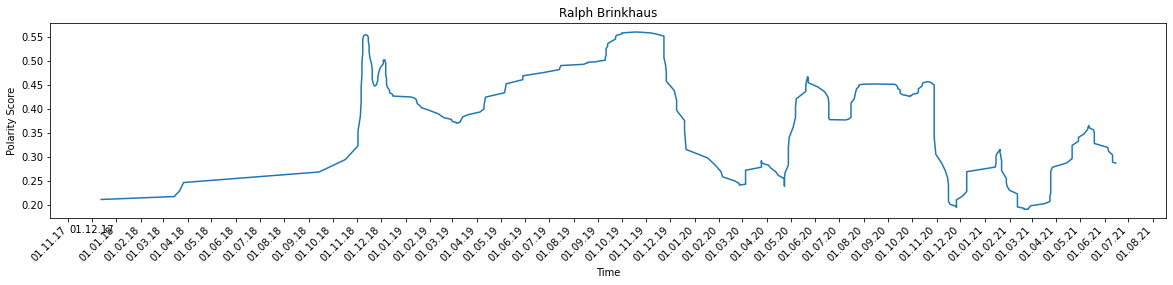

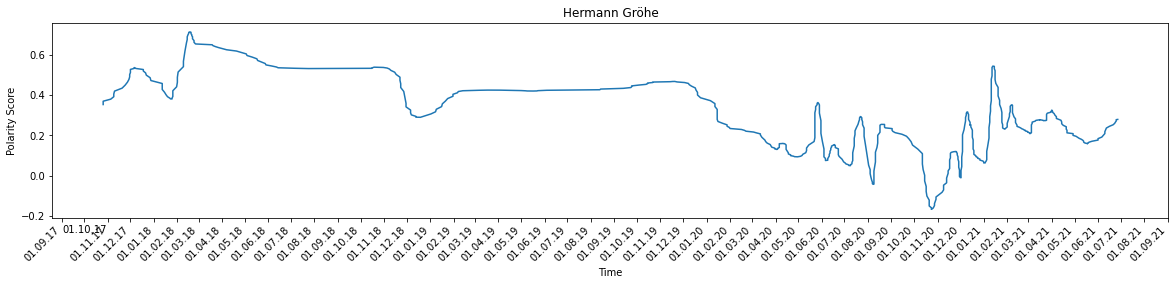

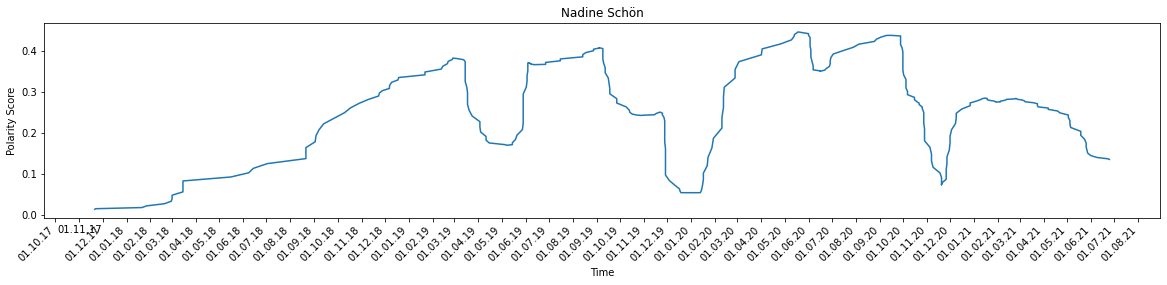

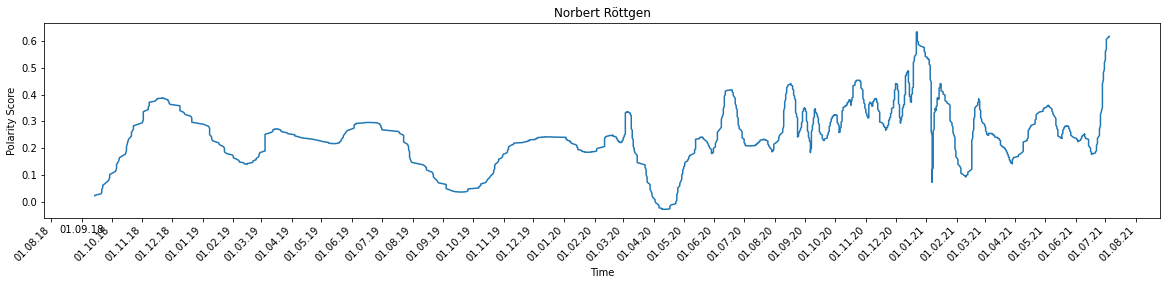

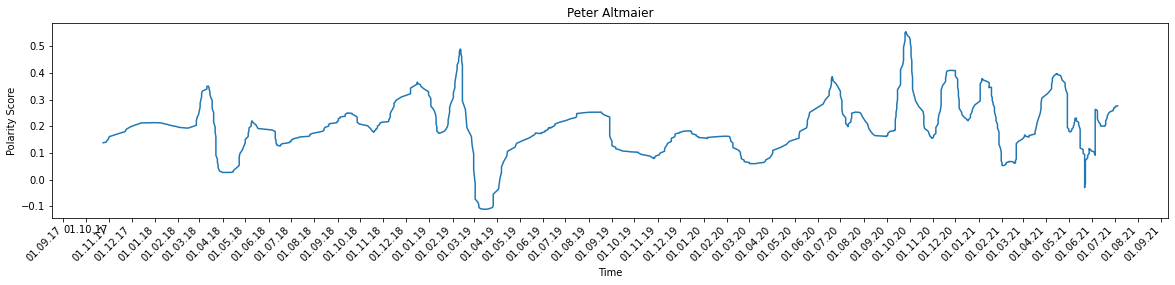

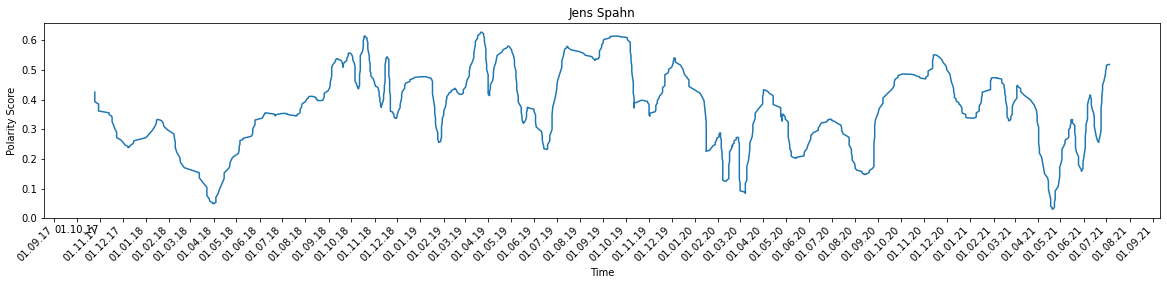

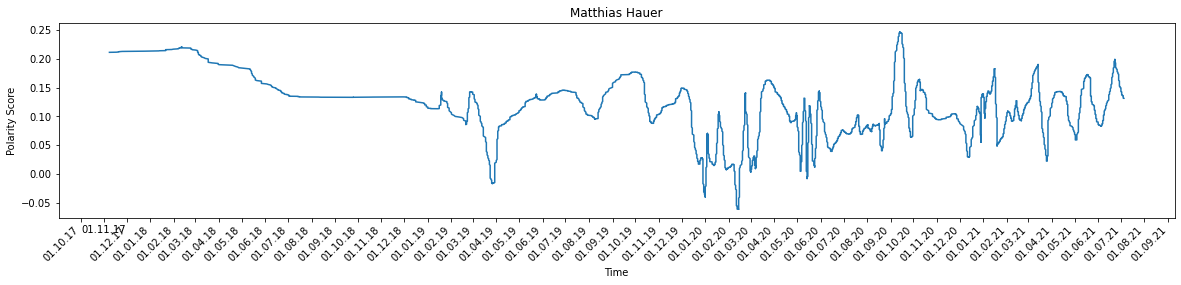

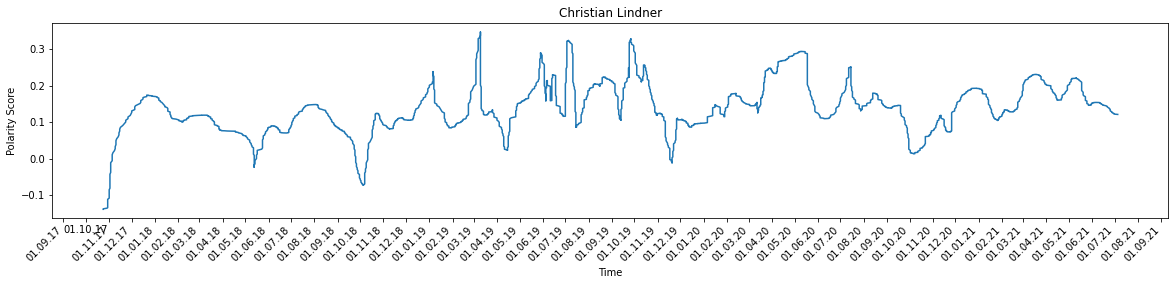

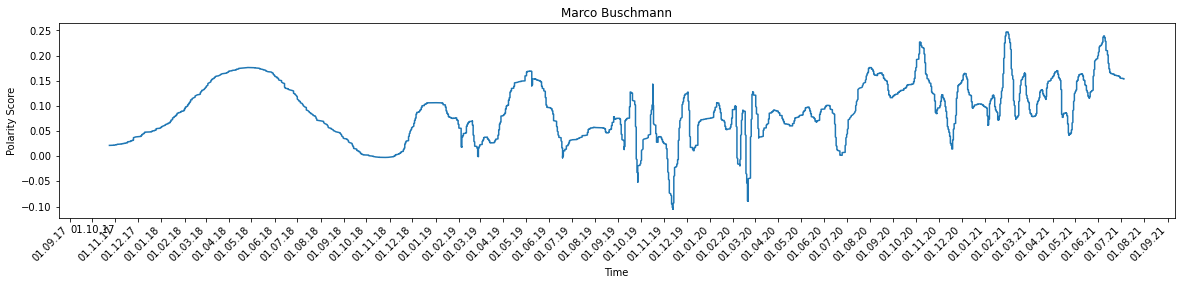

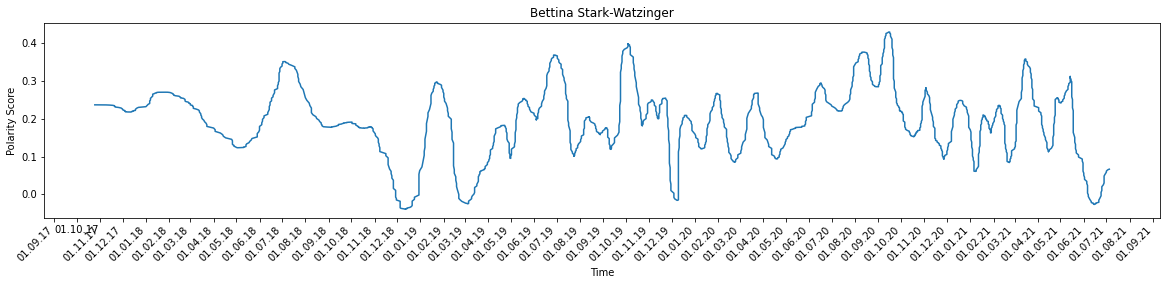

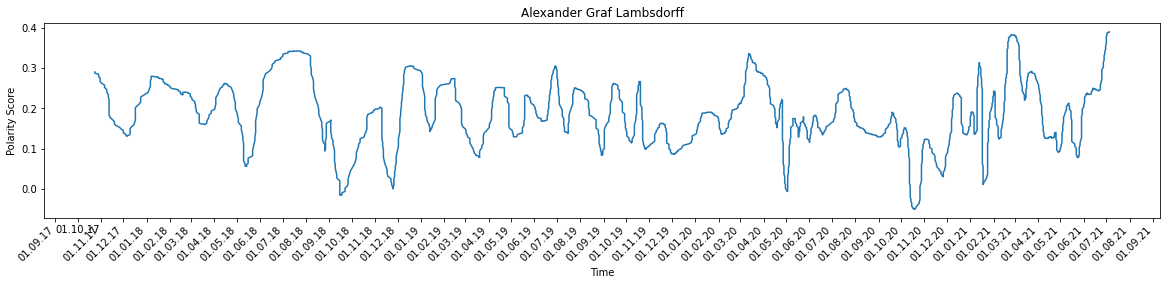

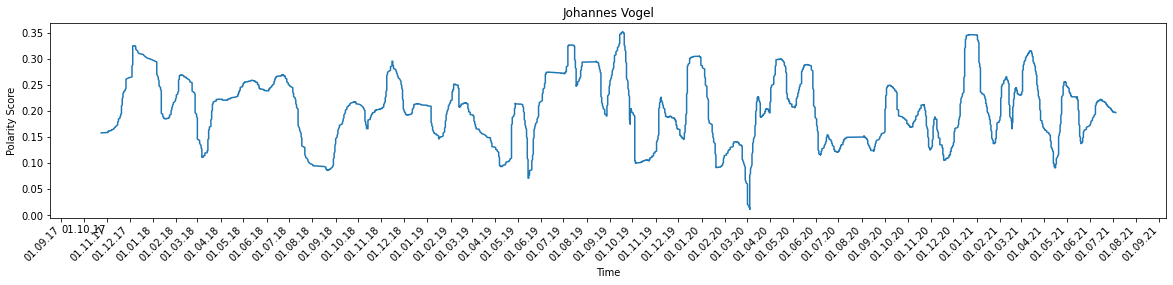

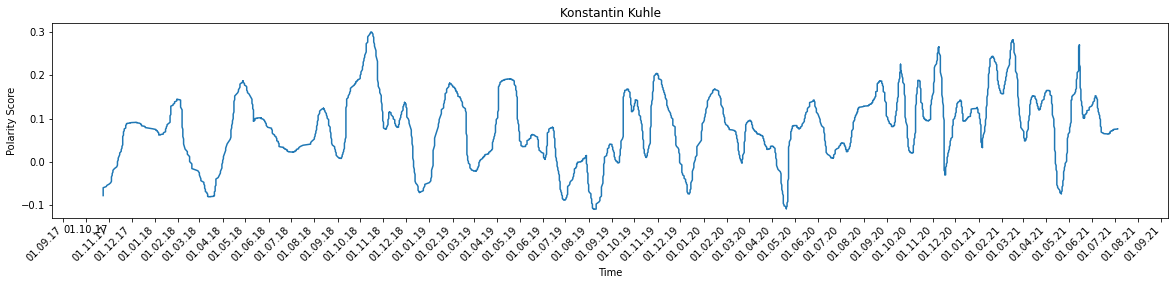

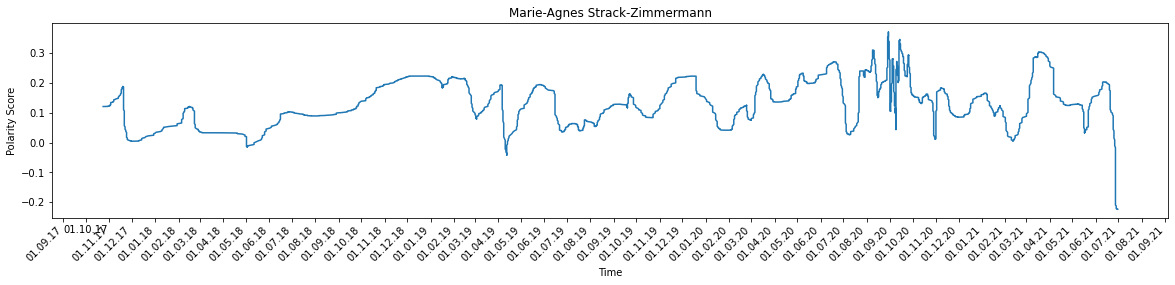

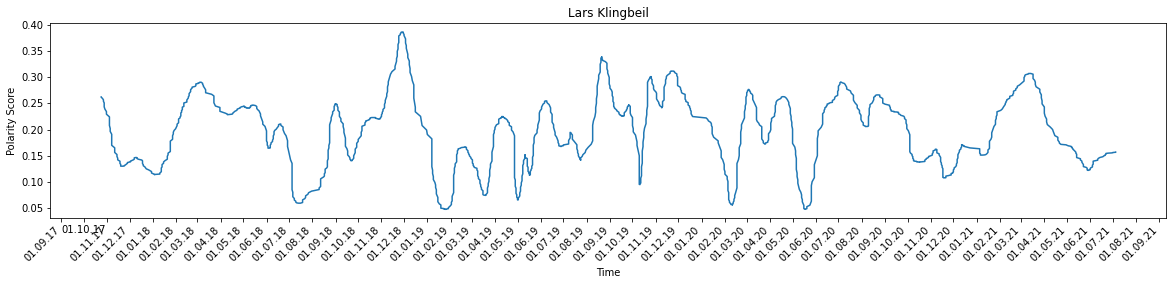

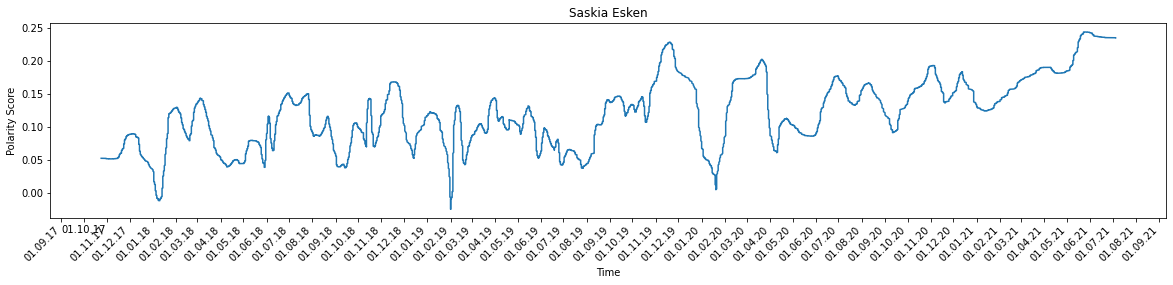

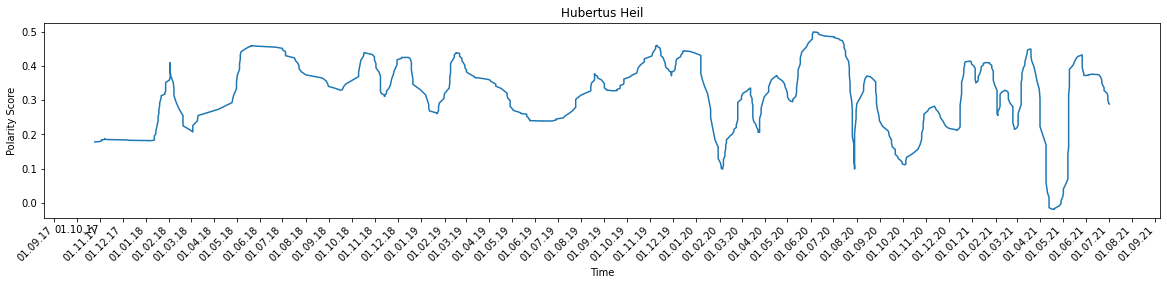

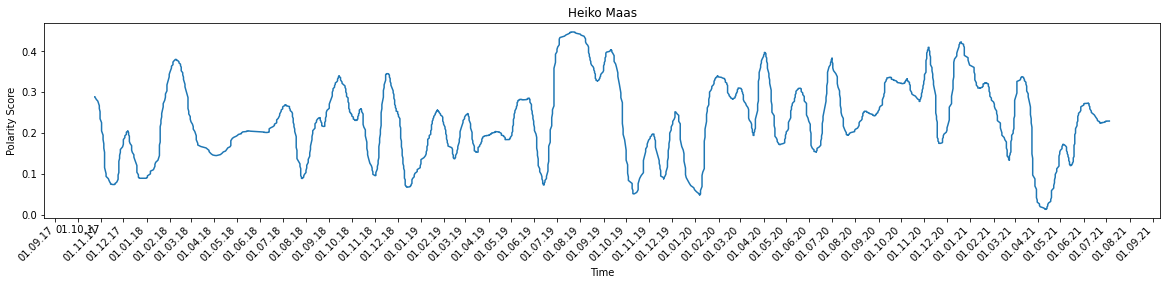

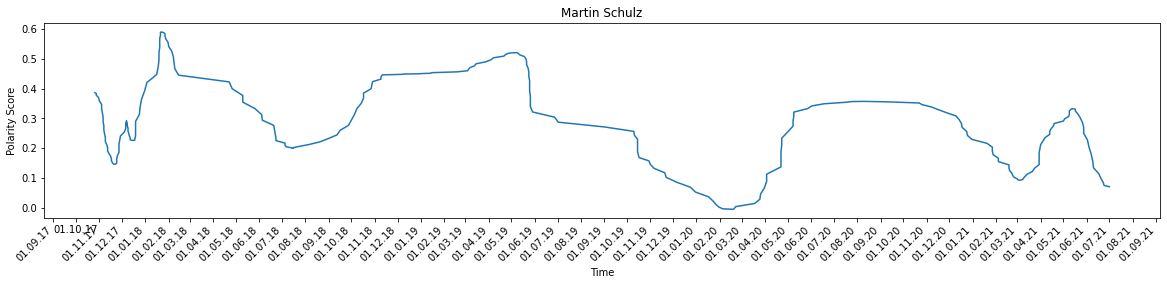

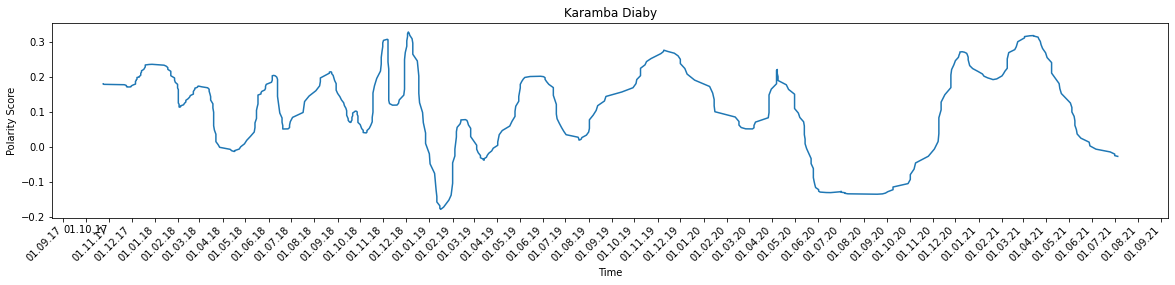

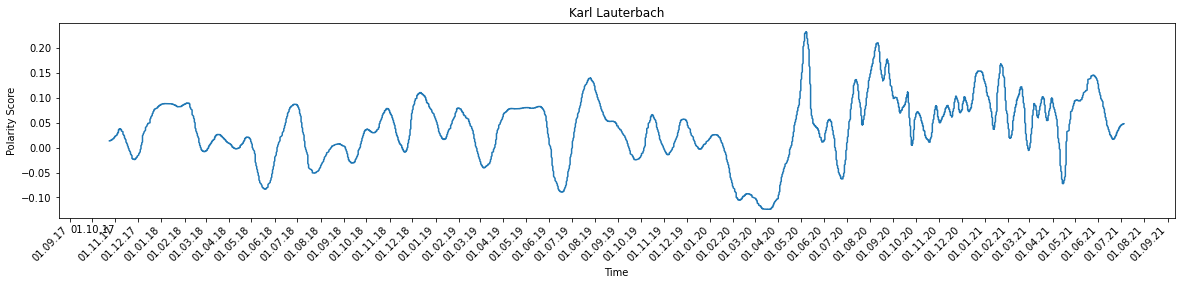

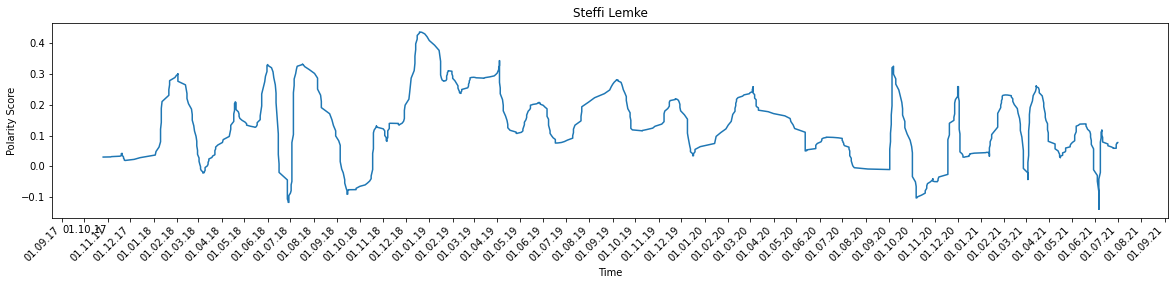

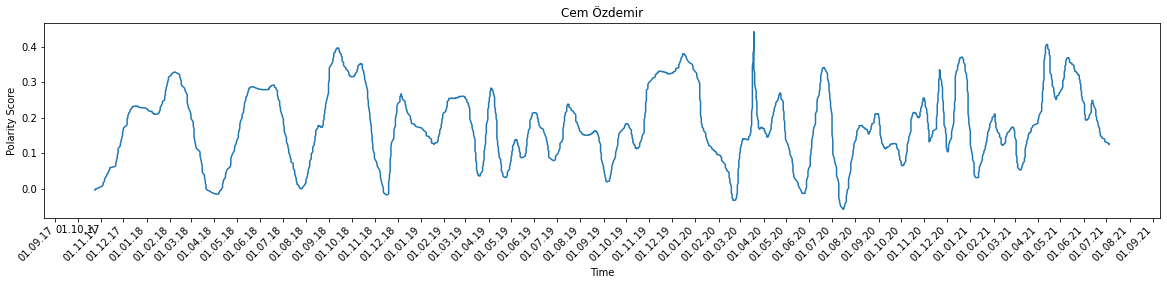

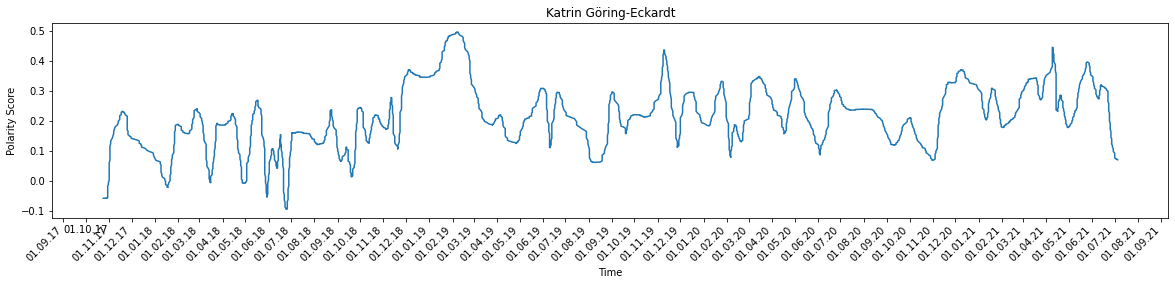

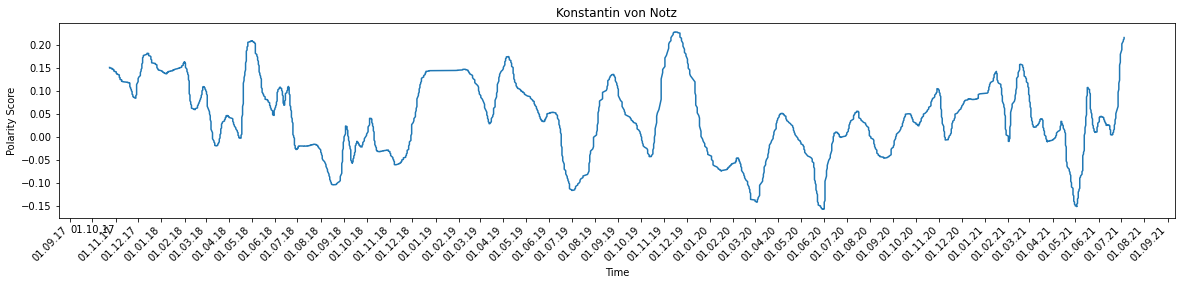

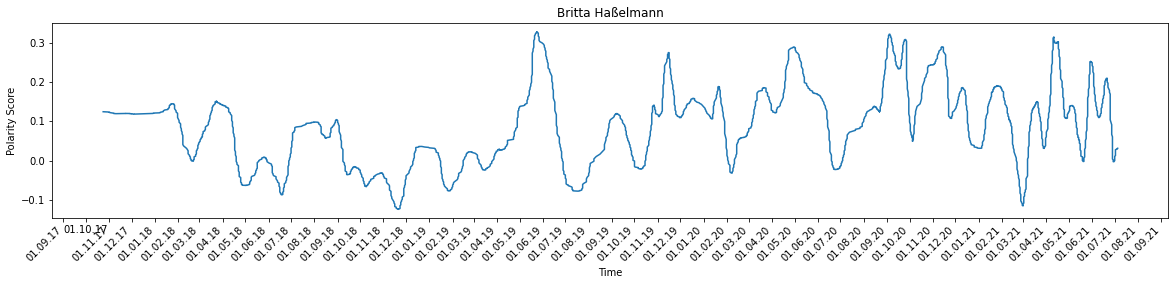

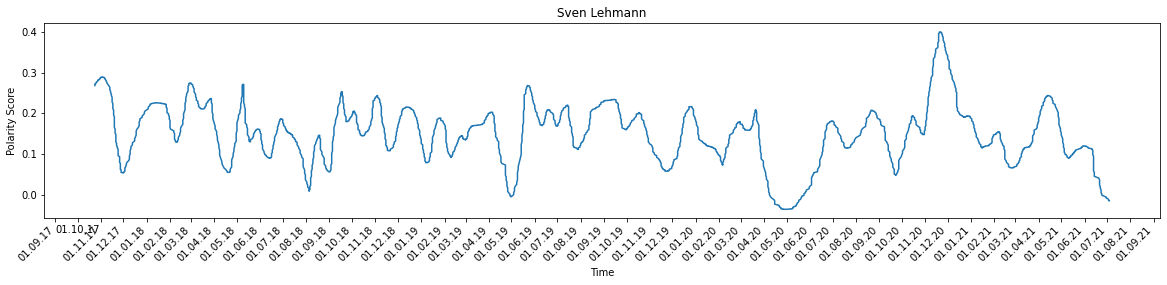

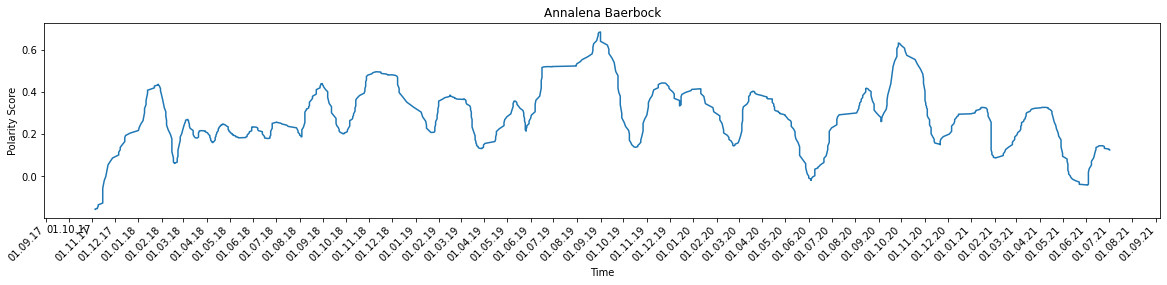

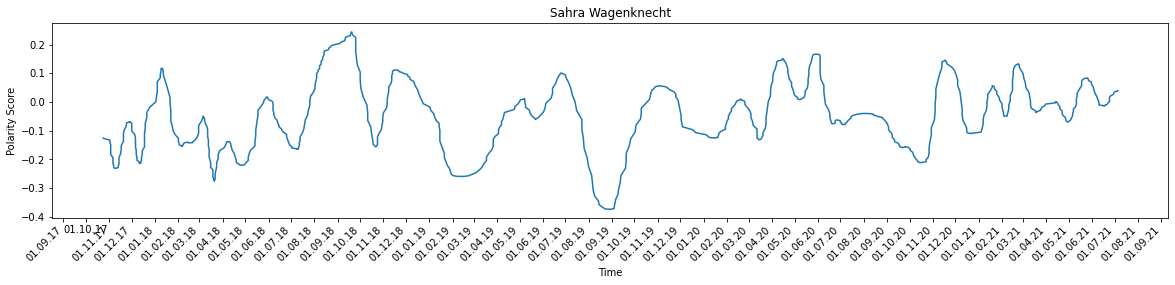

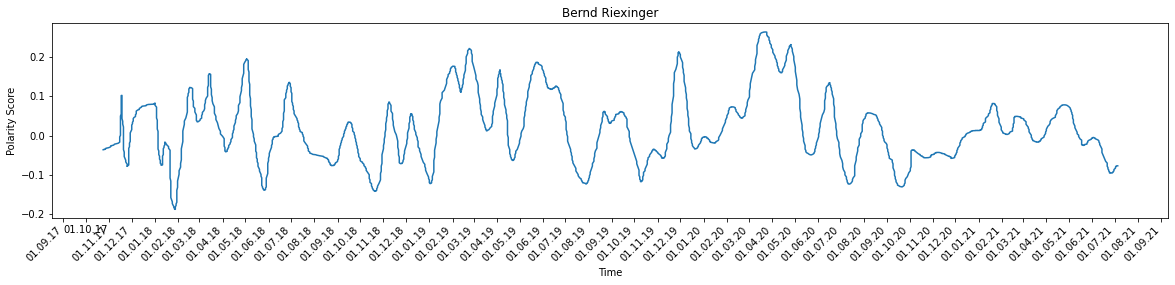

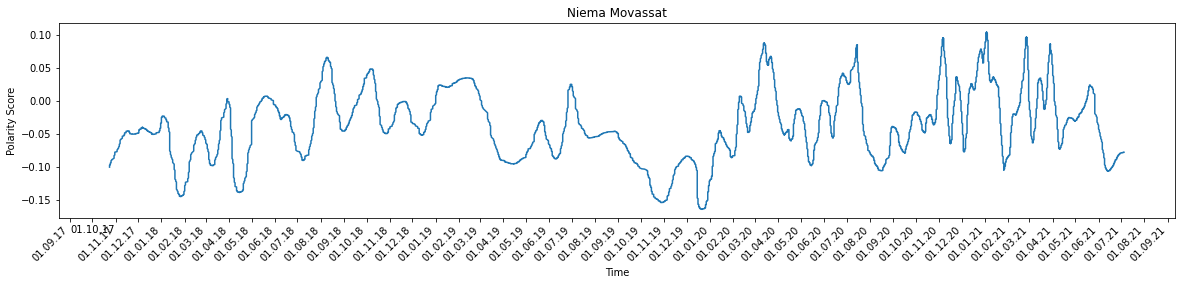

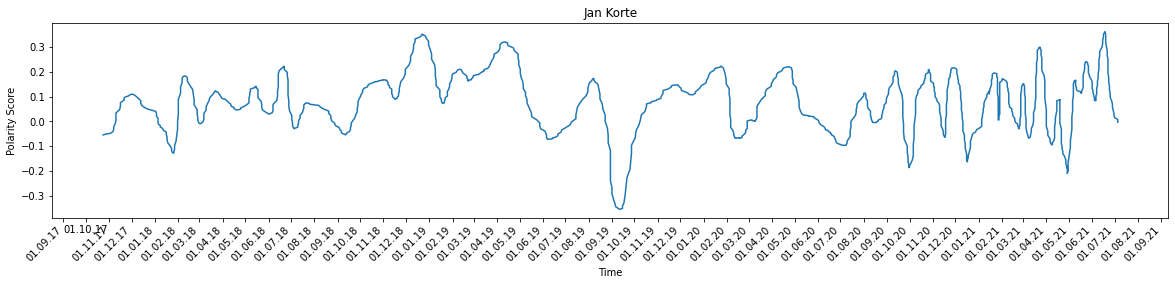

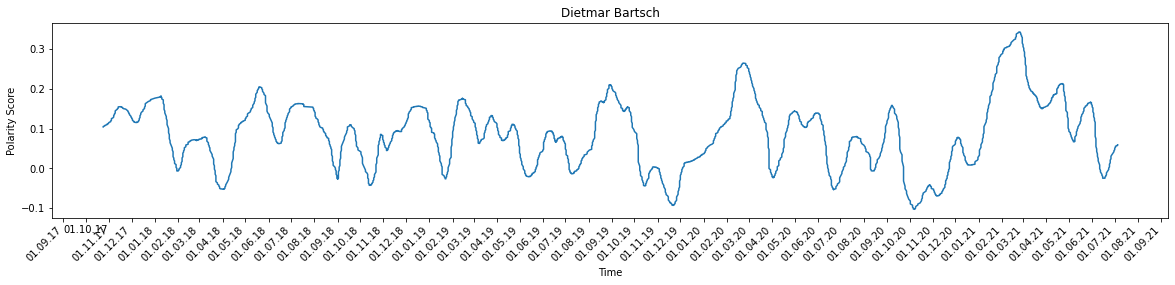

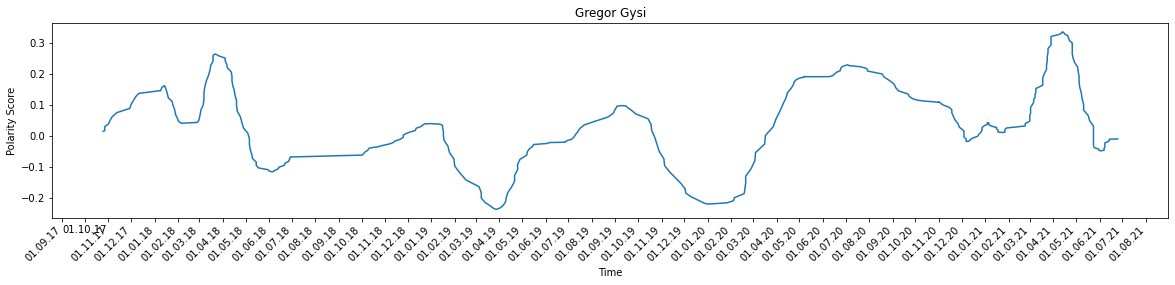

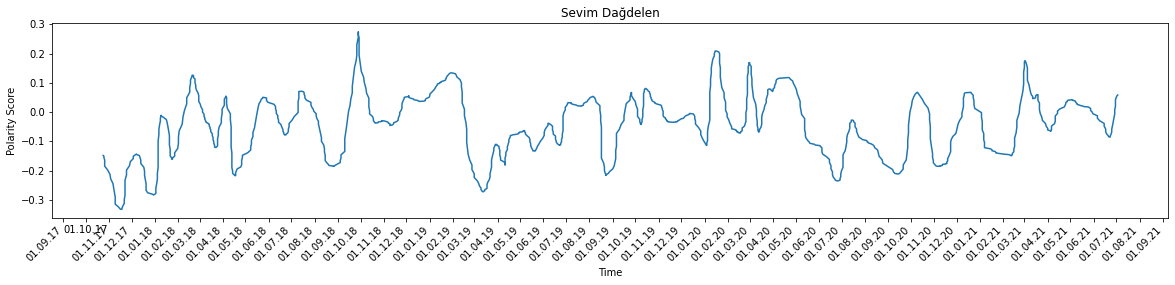

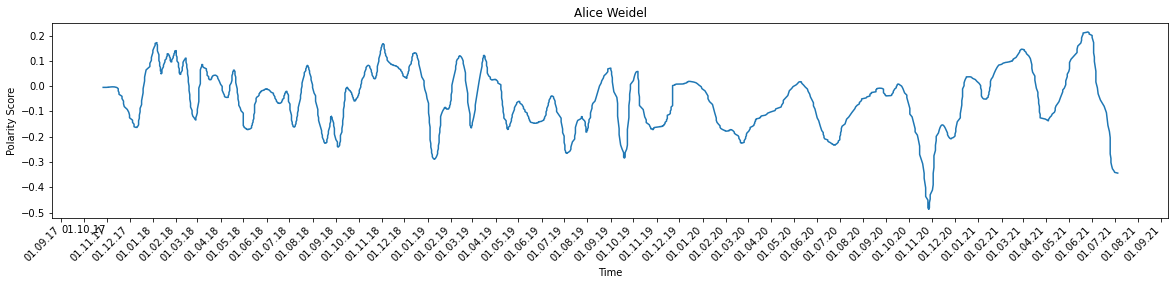

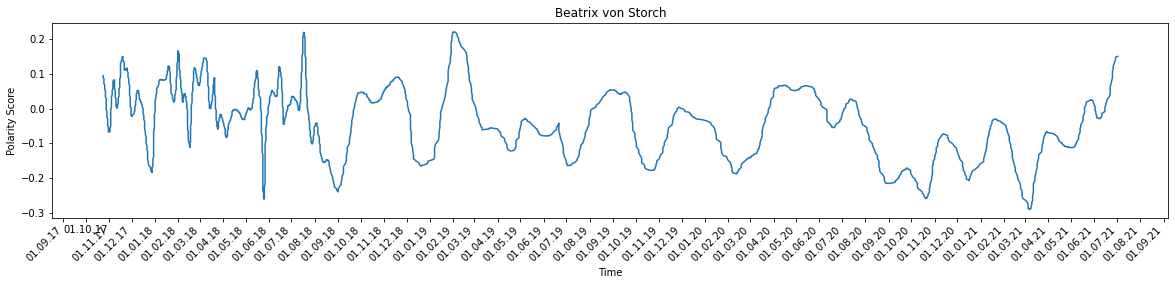

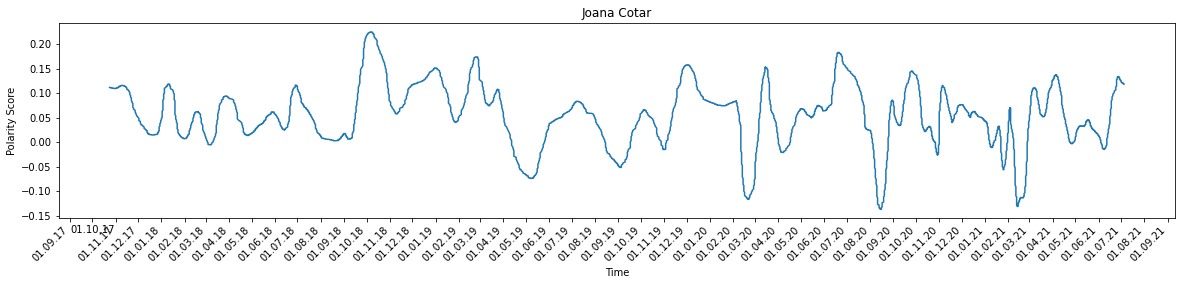

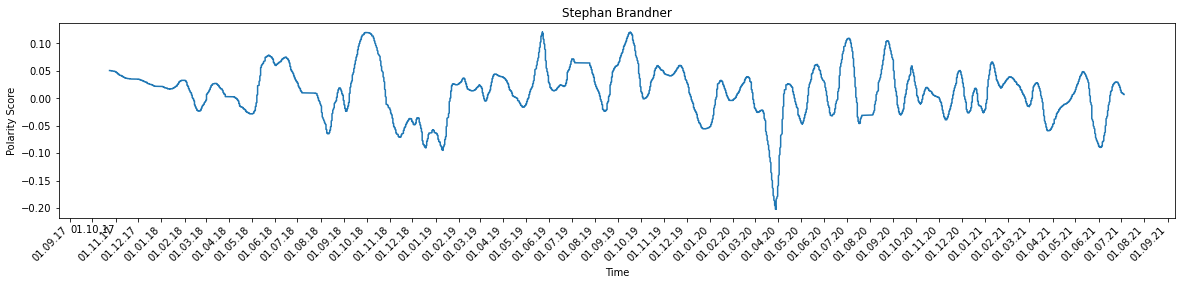

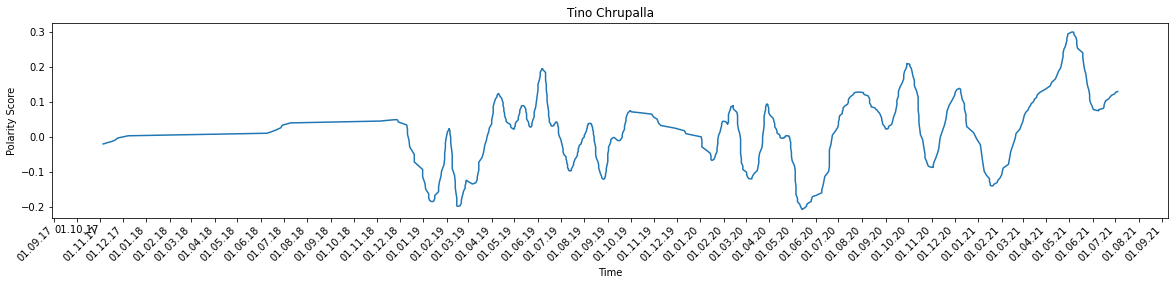

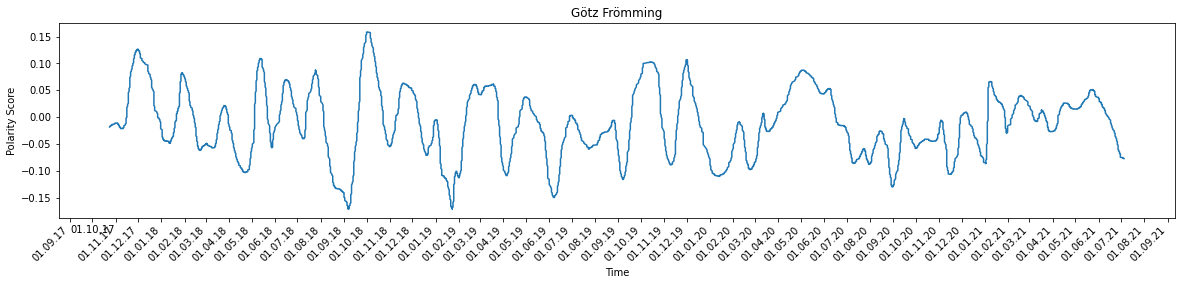

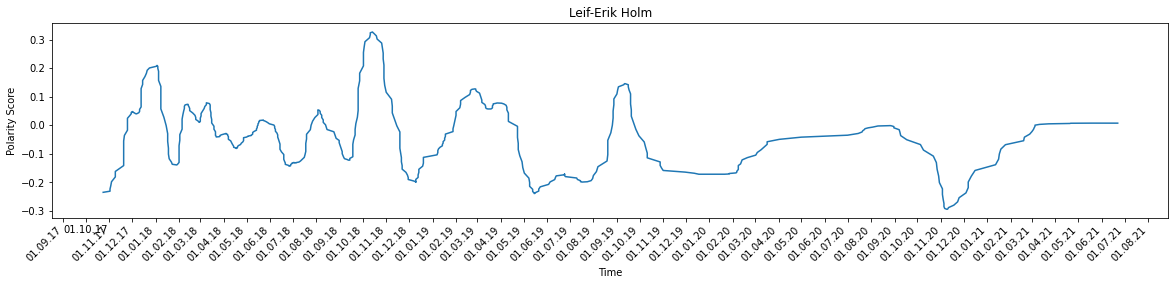

In [176]:
#plot the polarity of tweets over time
i=1
for name in tqdm(['Ralph Brinkhaus','Hermann Gröhe', 'Nadine Schön' ,'Norbert Röttgen' , 'Peter Altmaier' , 'Jens Spahn' , 'Matthias Hauer',
            'Christian Lindner' , 'Marco Buschmann' , 'Bettina Stark-Watzinger', 'Alexander Graf Lambsdorff' , 'Johannes Vogel' , 'Konstantin Kuhle' , 'Marie-Agnes Strack-Zimmermann',
            'Lars Klingbeil' , 'Saskia Esken' , 'Hubertus Heil' , 'Heiko Maas' , 'Martin Schulz' , 'Karamba Diaby' , 'Karl Lauterbach',
            'Steffi Lemke' , 'Cem Özdemir' , 'Katrin Göring-Eckardt' , 'Konstantin von Notz' , 'Britta Haßelmann' , 'Sven Lehmann' , 'Annalena Baerbock',
            'Sahra Wagenknecht' , 'Bernd Riexinger' , 'Niema Movassat' , 'Jan Korte' , 'Dietmar Bartsch' , 'Gregor Gysi' , 'Sevim Dağdelen',
            'Alice Weidel' , 'Beatrix von Storch' , 'Joana Cotar' , 'Stephan Brandner' , 'Tino Chrupalla' , 'Götz Frömming' , 'Leif-Erik Holm']):
    #get tweets from the specific politician
    tweets_analyzing =pre_data_twitter.loc[pre_data_twitter['full_name']==name]
    #create sentiment scores
    blobs=tweets_analyzing['text_preprocessed_sentence'].apply(TextBlob)
    sentiment=[]
    for blob in blobs:
        sentiment.append(blob.sentiment)
    #get the scores
    polarity=[]
    for egg in sentiment:
        polarity.append(egg.polarity)
    #get the desired dates and convert timestamp
    tweets_analyzing['polarity']=polarity
    tweets_analyzing['date']=pd.to_datetime(tweets_analyzing['date'])

    dates=tweets_analyzing['date']
    values=tweets_analyzing['polarity']

    #smooth the curve, higher sigma means more smoothing
    if len(polarity)>18999:
        s=100
    elif len(polarity)>17999:
        s=95
    elif len(polarity)>16999:
        s=90
    elif len(polarity)>15999:
        s=85
    elif len(polarity)>14999:
        s=80
    elif len(polarity)>13999:
        s=75
    elif len(polarity)>12999:
        s=70
    elif len(polarity)>11999:
        s=65
    elif len(polarity)>10999:
        s=60
    elif len(polarity)>9999:
        s=55
    elif len(polarity)>8999:
        s=50
    elif len(polarity)>7999:
        s=45
    elif len(polarity)>6999:
        s=40
    elif len(polarity)>5999:
        s=35
    elif len(polarity)>4999:
        s=30
    elif len(polarity)>3999:
        s=25
    elif len(polarity)>2999:
        s=20
    elif len(polarity)>1999:
        s=15
    elif len(polarity)>1399:
        s=10
    else:
        s=8
    ysmoothed = gaussian_filter1d(values, sigma=s)

    fig = plt.figure(figsize=(20,200))
    ax = fig.add_subplot(42,1,i)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    fig.autofmt_xdate(rotation=45)
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('Polarity Score')
    plt.plot(dates, ysmoothed)
    plt.show()
    i +=1

### 4.3.2 Results for Bundestag Speeches

As next step we will take a look at the Bundestag speeches of the politicians selected to see if we see similar trends and results as for their tweets or if the sentiment will be different on this platform. We again first import our preprocessed corpus for the speeches.

In [177]:
#import data
sentiment_speeches=pd.read_csv("../data/processed/sentiment_scores_speeches_01.csv")
pre_data_speeches= pickle.load(open('../data/processed/speeches_processed.p','rb'))

#### 4.3.2.1 Analysis of Political Parties

Starting of with the analysis of the sentiment based on the party of the considered politicians, we look at the mean of the polarity score for all the parties. In addition, we again compute the sum of all positive, negative, and neutral tweets. <br>
For the polarity means we have overall higher values which suggest a more positive sentiment. Again we see that CDU and SPD have the most positive sentiment scores which we also observed with the tweets. In this regard the only difference is that the SPD has the highest polarity score. So it seems that the SPD has more critical views in their tweets than their Bundestag speeches. This could be caused because the SPD was also part of the governement so they were part of most decisions made in the Bundestag. In contrast on social media they could than post more critical views that maybe were to controversial for a governing party in the Bundestag. <br>
For the other parties of the political middle they again have a positive sentiments that is a little lower than the one from CDU and SPD. While for Die Linke we again get a similar score as before that is noticeably lower than the one of FDP and Die Grünen the score for the AFD is surprisingly high and only a little lower than the other scores. <br>
When looking at the total number we may see a reason for this new trend. Because all parties have a rather similar amount of positively labeled speeches with the exeption of Die Linke and because for all of them the amounts of negative and neutral speeches are noticeably lower we see why we have that shift upwards. Still Die Linke and AFD have the most negative speeches. This may be due to the complex text character of speeches making it harder to determine their sentiment. Another reason for this shift could also lie in the formal format the politicians need to have in their speeches in comparison to their social media posts. This style of text may include more positive assigned words or the texts have more complex latent meanings in which the negative perspectives are hidden. <br>
Also in comparison to the tweets we have less neutral assignments for the sentiment. This could also be explained with the style of text used in speeches in the Bundestag. Another aspect that may as well be involved here is text length. With longer text there is a higher chance to encounter sentiment deciding words from the dictionary. We can assume that in general tweets are shorter than speeches especially due to the restricted length given by Twitter. So this may also be a factor coming into play here that needs to be considered especially when thinking about the validity of the approach.

In [178]:
#compute the mean for Polarity and sum over number of speeches from the six parties represented
CDU_polarity = np.mean(sentiment_speeches['Polarity_mean'][0:7])
print('CDU Sentiment: ',CDU_polarity)
FDP_polarity = np.mean(sentiment_speeches['Polarity_mean'][7:14])
print('FDP Sentiment: ',FDP_polarity)
SPD_polarity = np.mean(sentiment_speeches['Polarity_mean'][14:21])
print('SPD Sentiment: ',SPD_polarity)
GRUENE_polarity = np.mean(sentiment_speeches['Polarity_mean'][21:28])
print('GRUENE Sentiment: ',GRUENE_polarity)
LINKE_polarity = np.mean(sentiment_speeches['Polarity_mean'][28:35])
print('LINKE Sentiment: ',LINKE_polarity)
AFD_polarity = np.mean(sentiment_speeches['Polarity_mean'][35:42])
print('AFD Sentiment: ',AFD_polarity)
print( )

for category in ['Num_pos_speeches','Num_neutral_speeches','Num_neg_speeches']:
    CDU_cat = np.sum(sentiment_speeches[category][0:7])
    print('CDU ',category,': ',CDU_cat)
    FDP_cat = np.sum(sentiment_speeches[category][7:14])
    print('FDP ',category,': ',FDP_cat)
    SPD_cat = np.sum(sentiment_speeches[category][14:21])
    print('SPD ',category,': ',SPD_cat)
    GRUENE_cat = np.sum(sentiment_speeches[category][21:28])
    print('GRUENE ',category,': ',GRUENE_cat)
    LINKE_cat = np.sum(sentiment_speeches[category][28:35])
    print('LINKE ',category,': ',LINKE_cat)
    AFD_cat = np.sum(sentiment_speeches[category][35:42])
    print('AFD ',category,': ',AFD_cat)
    print( )

CDU Sentiment:  0.32609146585596893
FDP Sentiment:  0.2894172233378474
SPD Sentiment:  0.35604357231474093
GRUENE Sentiment:  0.2671830444581131
LINKE Sentiment:  0.05000582844898308
AFD Sentiment:  0.16752867587538792

CDU  Num_pos_speeches :  437
FDP  Num_pos_speeches :  392
SPD  Num_pos_speeches :  443
GRUENE  Num_pos_speeches :  312
LINKE  Num_pos_speeches :  142
AFD  Num_pos_speeches :  307

CDU  Num_neutral_speeches :  80
FDP  Num_neutral_speeches :  47
SPD  Num_neutral_speeches :  74
GRUENE  Num_neutral_speeches :  53
LINKE  Num_neutral_speeches :  37
AFD  Num_neutral_speeches :  70

CDU  Num_neg_speeches :  57
FDP  Num_neg_speeches :  76
SPD  Num_neg_speeches :  62
GRUENE  Num_neg_speeches :  91
LINKE  Num_neg_speeches :  120
AFD  Num_neg_speeches :  138



#### 4.3.2.2 Analysis of Gender Differences

When looking at the gender data we see a similar picture as with the tweets. The overall female polarity score seems a little lower than the male one but again the population of female politicians in our data is smaller and therefore not as representative. Again we can assume that the gender factor will not play a big role in sentiment which we will now look deeper into with the further analysis.

In [179]:
#compute the mean for Polarity and sum over number of speeches for male and female politicians
female_polarity= np.mean(sentiment_speeches.loc[sentiment_speeches['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])]['Polarity_mean'])
print('Female Sentiment:',female_polarity)
for category in ['Num_pos_speeches','Num_neutral_speeches','Num_neg_speeches']:
    female_cat = np.sum(sentiment_speeches.loc[sentiment_speeches['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])][category])
    print('Female ',category,': ',female_cat)

male_polarity= np.mean(sentiment_speeches.loc[~sentiment_speeches['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])]['Polarity_mean'])
print('Male Sentiment:',male_polarity)
for category in ['Num_pos_speeches','Num_neutral_speeches','Num_neg_speeches']:
    male_cat = np.sum(sentiment_speeches.loc[~sentiment_speeches['Name'].isin(['Nadine Schön' ,'Bettina Stark-Watzinger','Marie-Agnes Strack-Zimmermann','Saskia Esken' ,'SteffiLemke' ,'Katrin Göring-Eckardt' ,'Britta Haßelmann' ,'Annalena Baerbock (Archiv)','Sahra Wagenknecht' ,'Sevim Dağdelen, MdB','Alice Weidel' ,'Beatrix von Storch'])][category])
    print('Male ',category,': ',male_cat)

Female Sentiment: 0.21797838378315448
Female  Num_pos_speeches :  345
Female  Num_neutral_speeches :  67
Female  Num_neg_speeches :  117
Male Sentiment: 0.24945706721178482
Male  Num_pos_speeches :  1688
Male  Num_neutral_speeches :  294
Male  Num_neg_speeches :  427


#### 4.3.2.3 Analysis of Politicians over Time

As a last step in our analysis we again plot the graphs of the individual politicians polarity for the speeches over time as we did with the tweets. We are again left with the 42 grpahs for the politicians which we are going to analyze as above for one politician per party. To keep the structure we are going to take the same politicians as before.

Because there are fewer speeches and there tend to be a lot of speeches in small time intervals, this time around the graphs seem to have points with very steep rises and falls but also big intervals with almost not movement. This can be seen as an indicator that the analysis over time is more complex. A reason for this behavior could be the unregular distances in time between speeches and the fact that most of the times speeches are followed up by the same person. Therefore, these extreme graphs may not be to surprising but certainly worse for analysis.

First we can see a similar overall picture for Jens Spahn as with the tweets. The noticeable differences are in the lower minimums of his polarity scores with short drops even into negative polarity. What may be surprising is that it is also harder to see the impact of current topic like Corona which was surprisingly easy within the tweet sentiment. When we look at the deepest drop in April of 2019 we can try to explain it with the fact that around that time the government has made a new law proposal which was questioned through a survey in the Bundestag. These questions were addressed at Jens Spahn because he was the minister of health and in charge of the proposal. As he has to answer multiple questions this can influence the sentiment in various ways.

For Christian Lindner we can also see a overall more positive sentiment. In difference to Spahn he has no extreme spikes in his polarity scores which may suggests that he did not conduct a survey in the Bundestag and had no questioning. Apart from that there are no significant looking time interval other than with his tweets. What surprises is that his overall trend changes in the speeches. Where as it was positive for his tweet sentiment now for his speech sentiment it is negative. It is difficult to see a clear explenation for this. One could speculate if the positive sentiment on Twitter is mostly attributed to the marketing for his party and initiatives which he obviously won't mentione in the Bundestag.

In the case of Karl Lauterbach we also see a very different picture in comparison to his tweet sentiments. Especially from early 2019 on his sentiment is continous on a very high level. This could on the one side be because he had fewer speeches from that point on in the Bundestag or one the other side because the topics he addressed were more positively conotated. In any case this graph looks very different to the one for the tweets where his sentiment was changing a lot through that period of time. This seems to be a somewhat good example of a politician that has a very different appearence through speech on social media and in the Bundestag only judging by the sentiment.

For Annalena Baerbock we can also see a more positive trend in sentiment over time here. For her we can see a very steep drop end of October 2019. In this case, around that time she had a draft for a law against child abuse which could be linked to the drop in sentiment. From that we can see once more that the topics discussed in their speeches can have a heavy impact on their overall sentiment and these steep drops seem to be an indicator for controversial and critical topics.

When looking at Sahra Wagenknechts speech sentiment over time see that there is no big movement which lets us believe that she has had only a small amount of speeches. Like the other Die Linke politicians she also has a rather low level of polarity which could show that they are similarly critical in the comments to the political decisions in the Bundestag as on social media.

Lasty, Alice Weidel shows only few fluctuations in comparison to her Twitter sentiments which could lead to a similar conclusions as with Wagenknecht. Overall the AFD seems to have some topics and periods with very high polarity which result in very psoitive sentiment overall. A possible explenation could be the conservative character of the last government. Another explenation could also lie in the fact that it was their first period in the Bundestag and they had the chance to make some proposals which they conotated positive.

  0%|          | 0/42 [00:00<?, ?it/s]

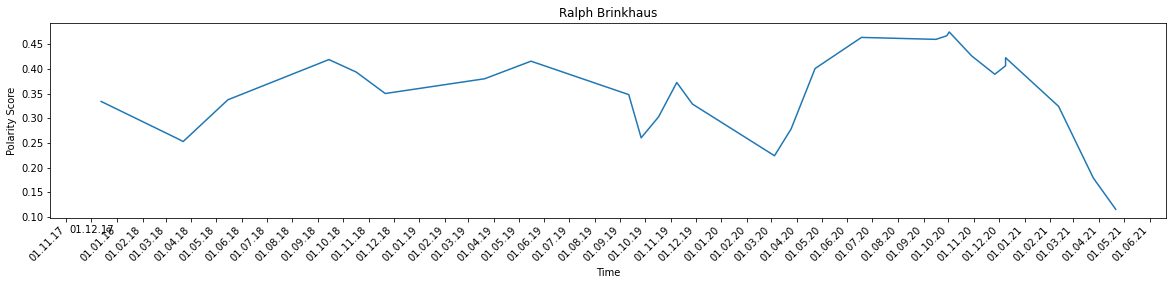

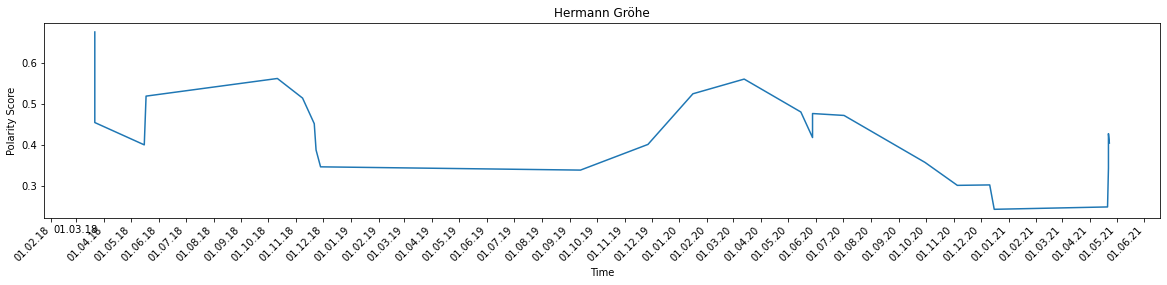

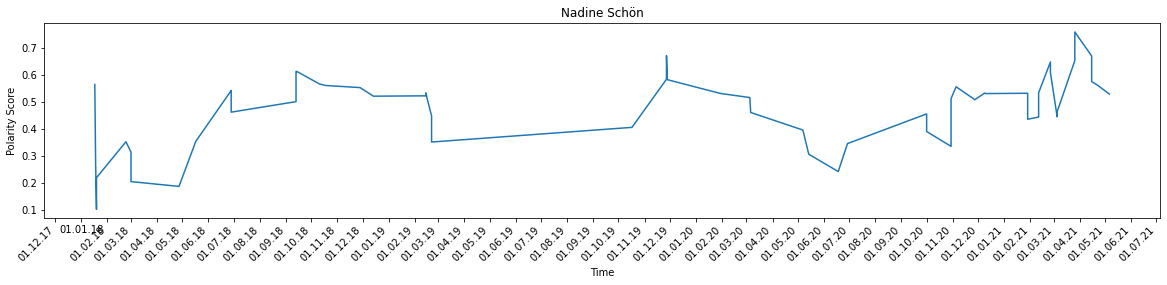

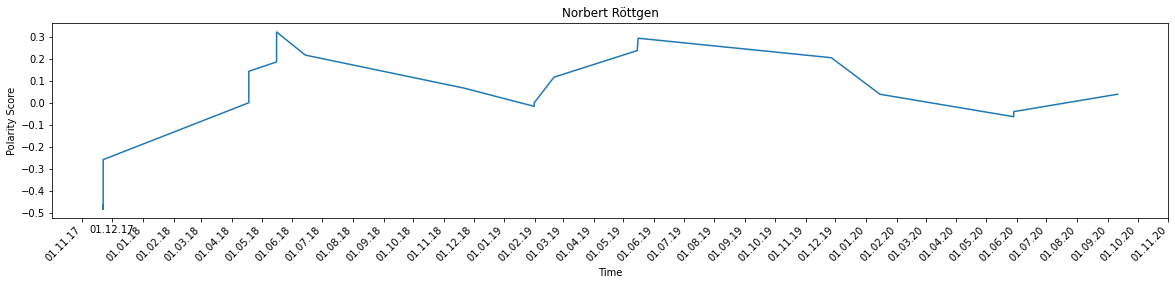

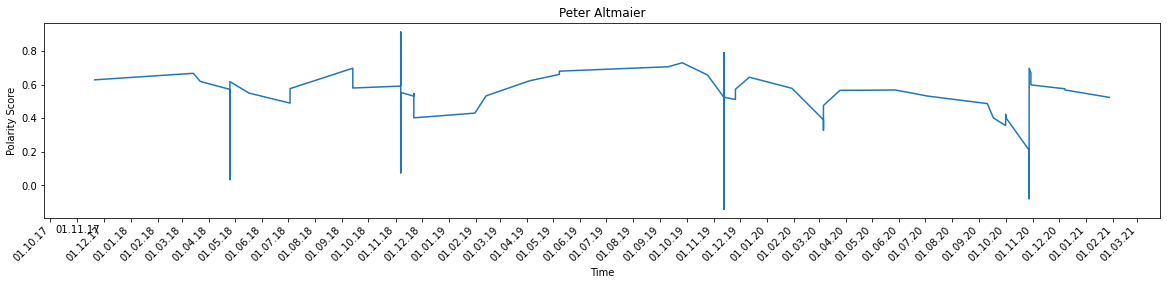

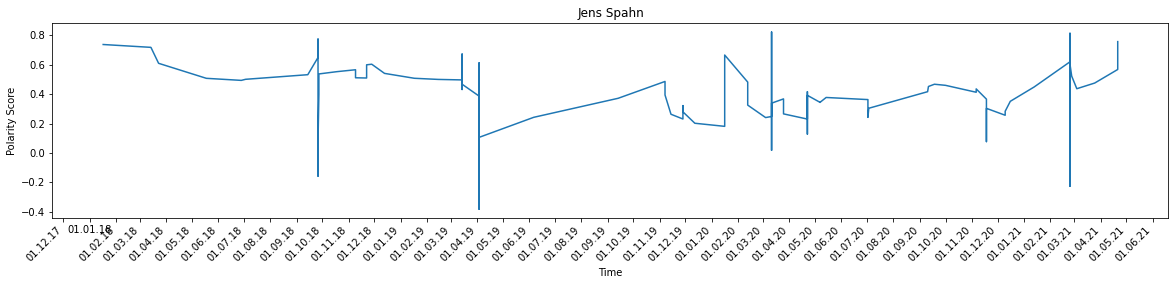

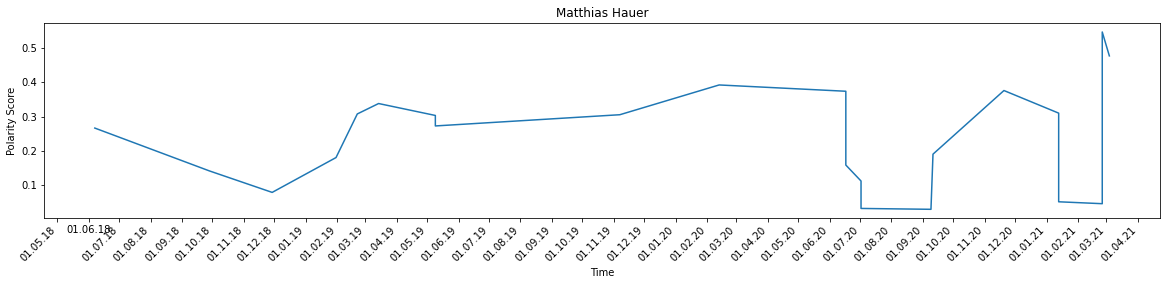

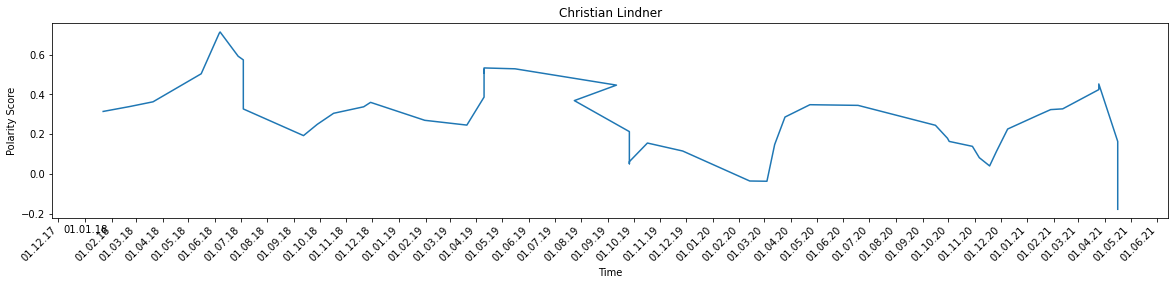

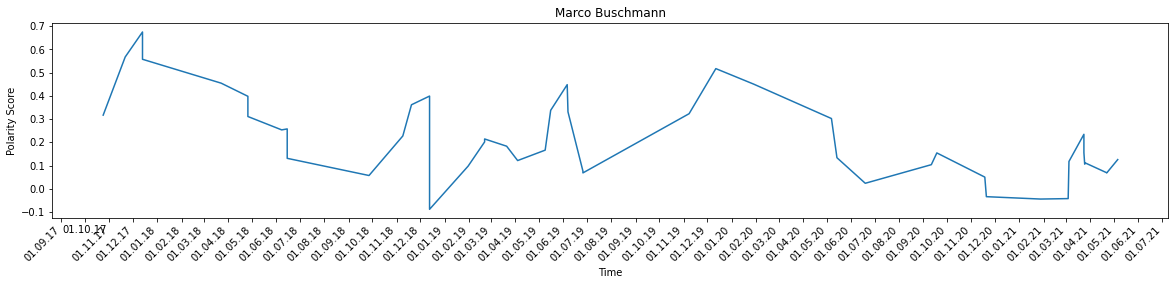

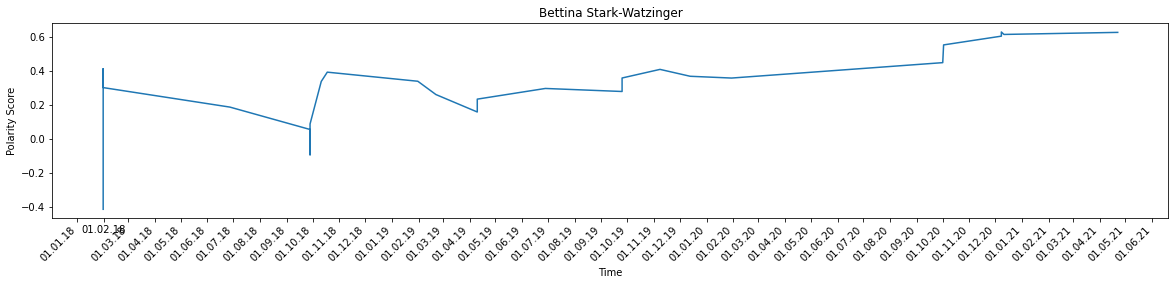

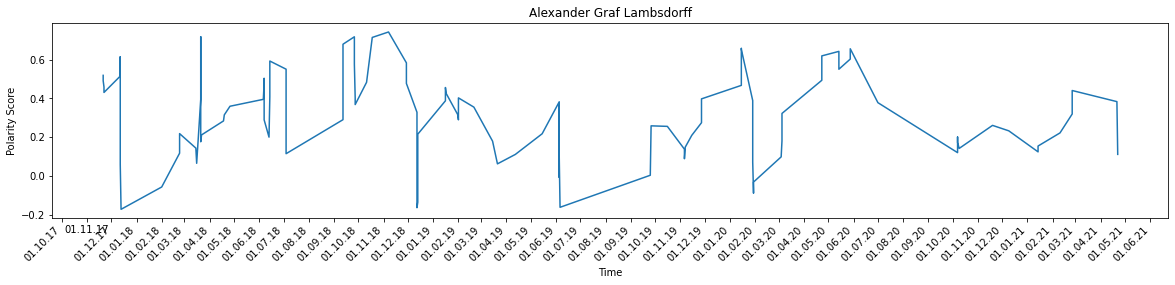

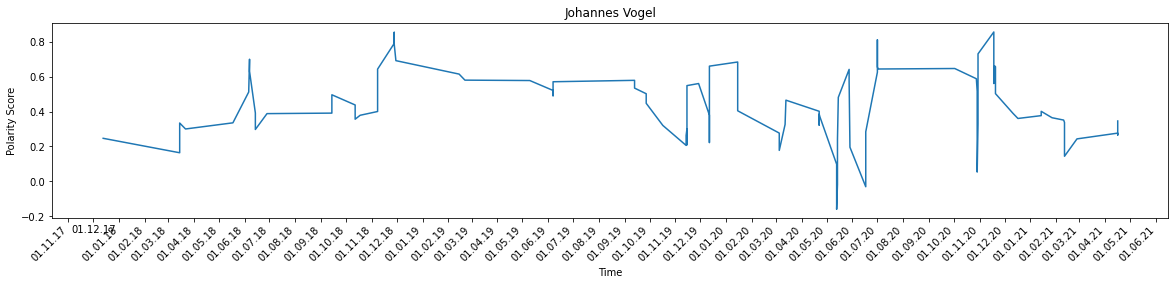

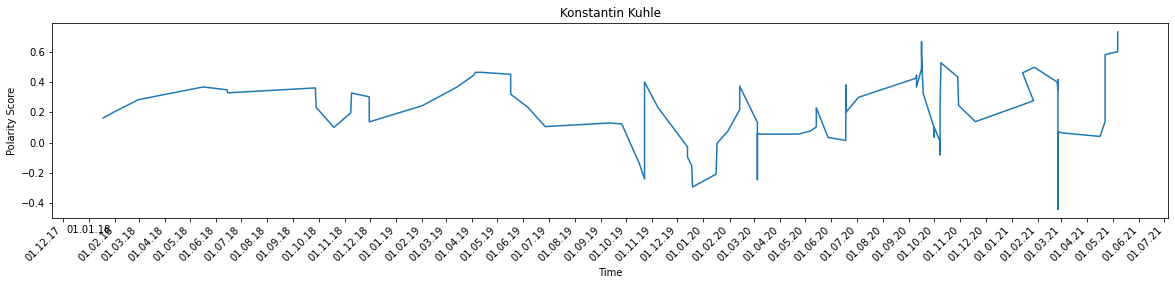

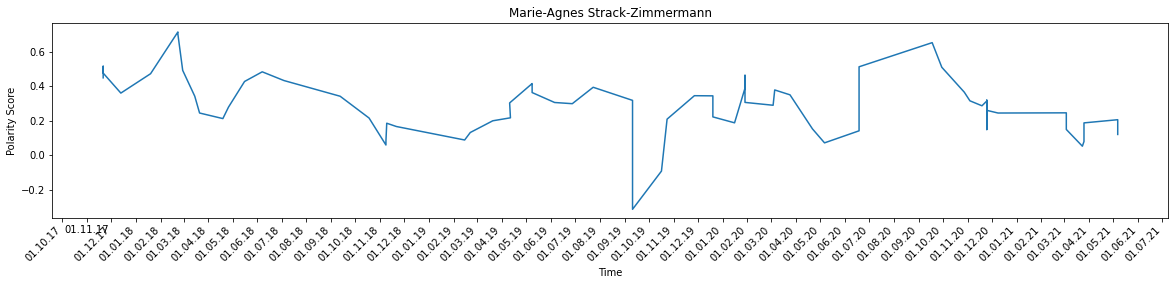

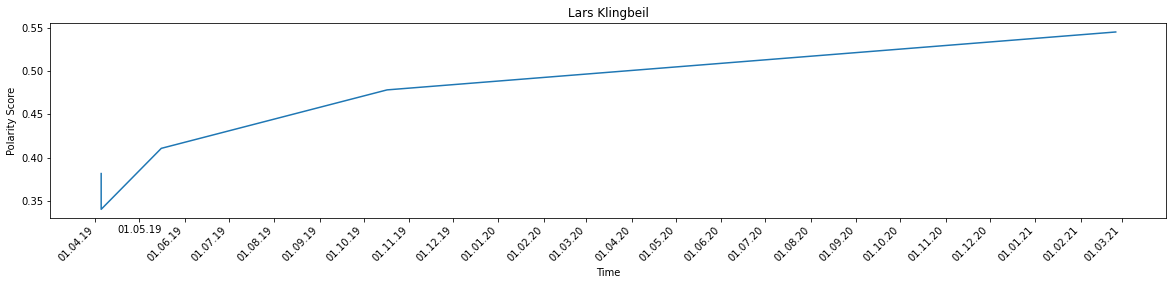

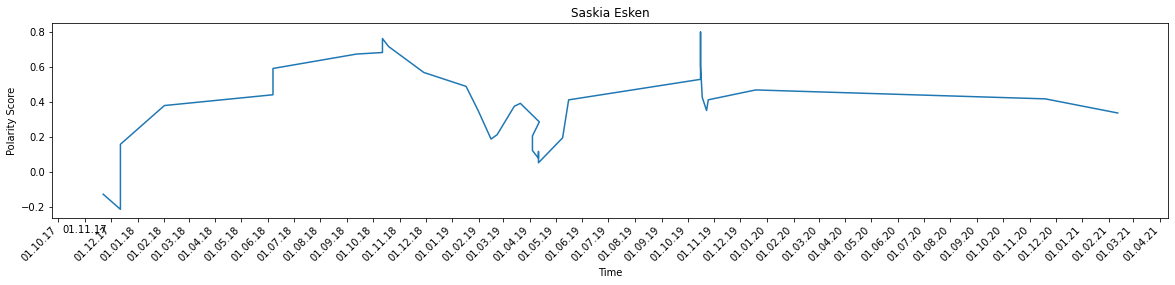

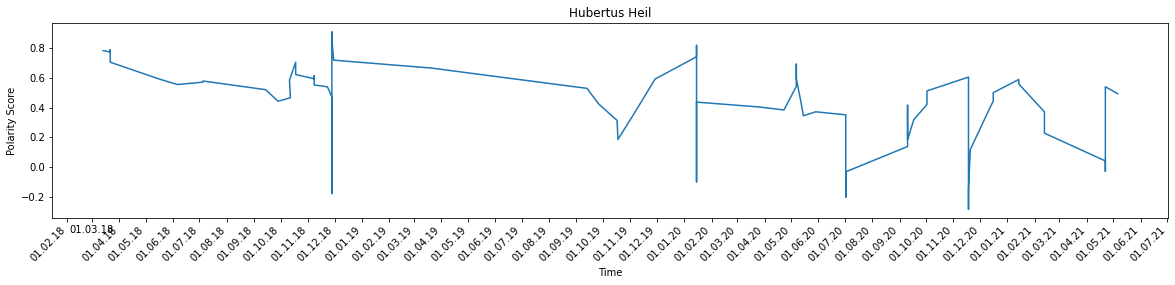

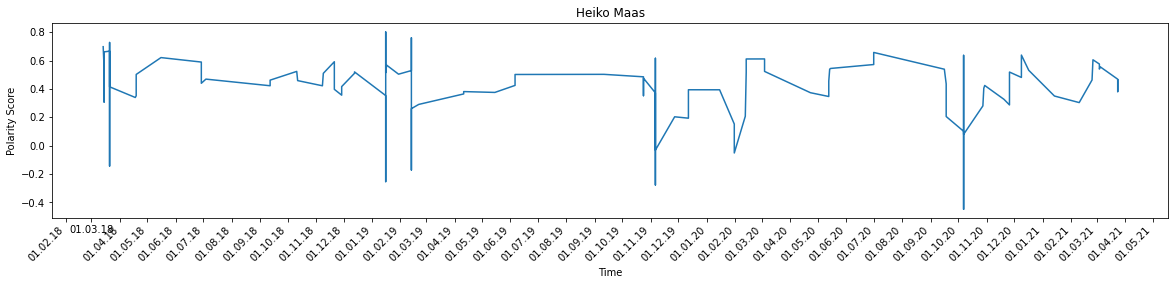

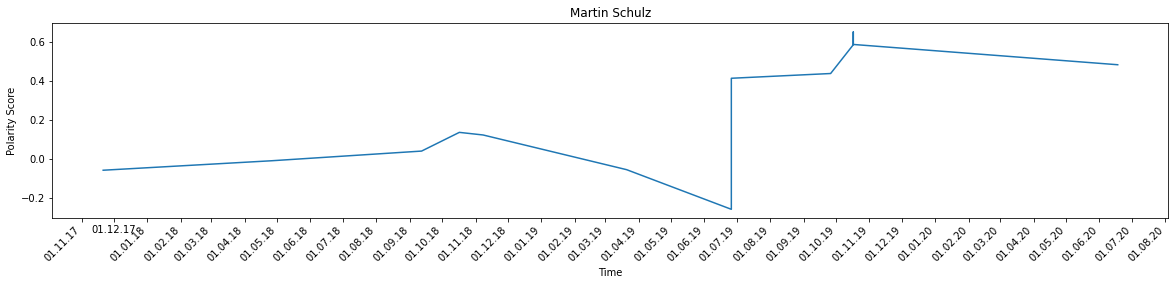

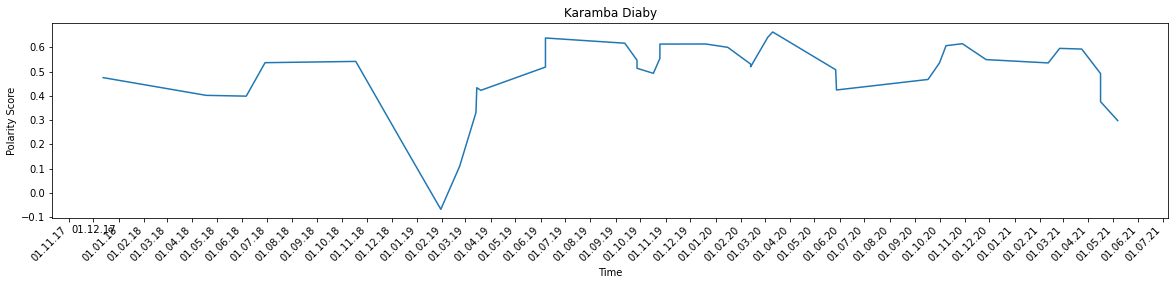

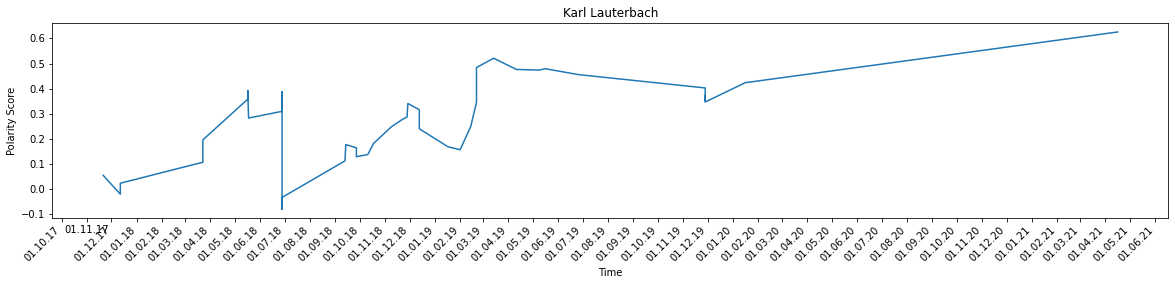

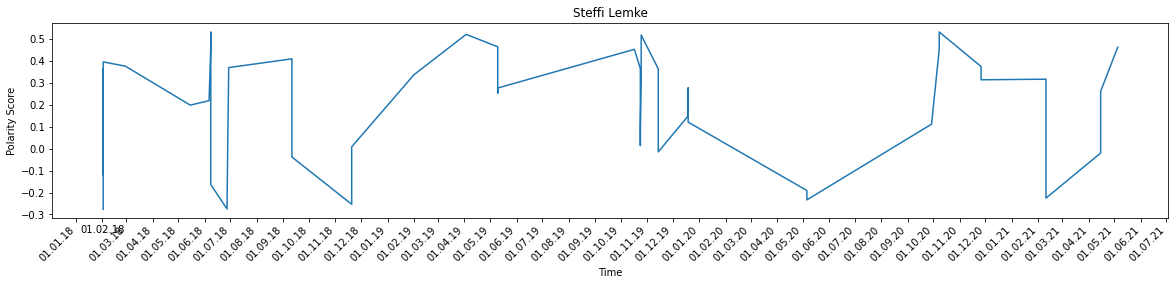

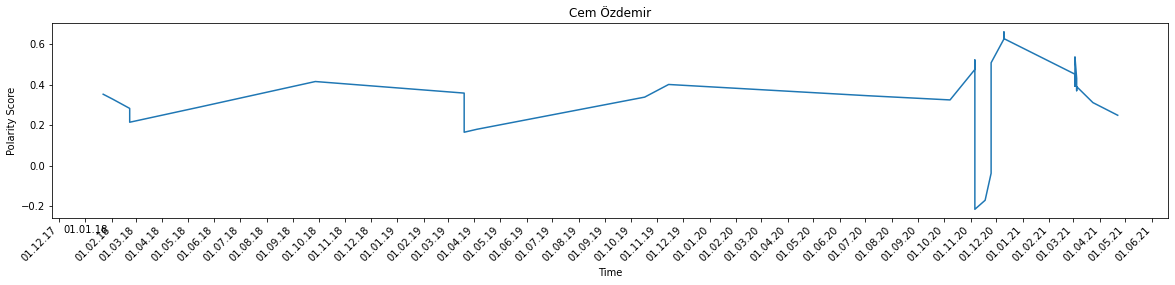

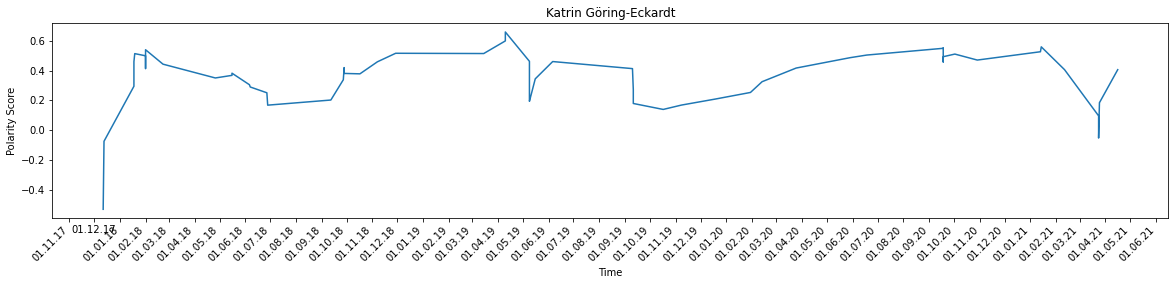

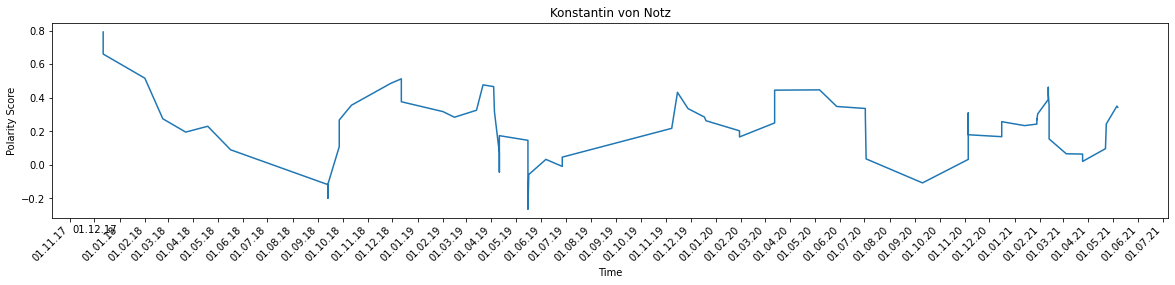

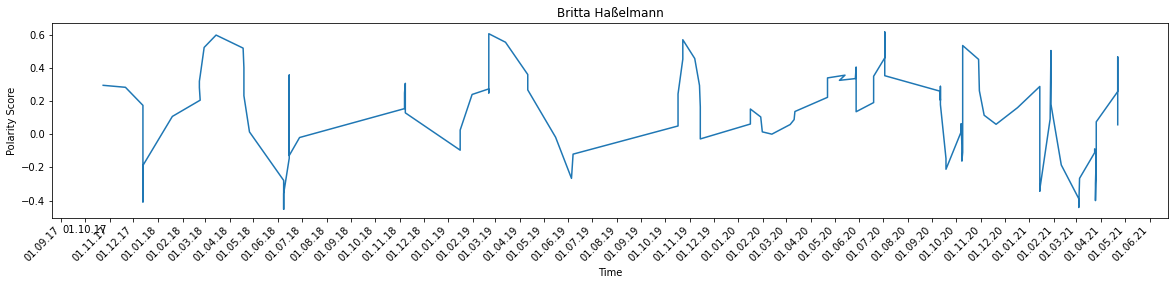

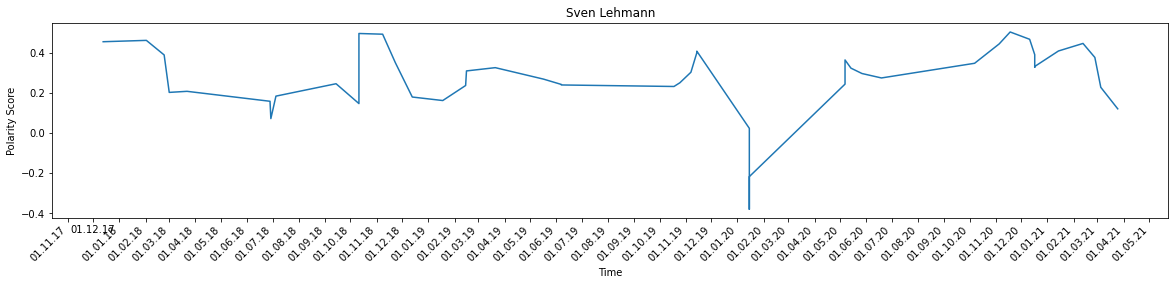

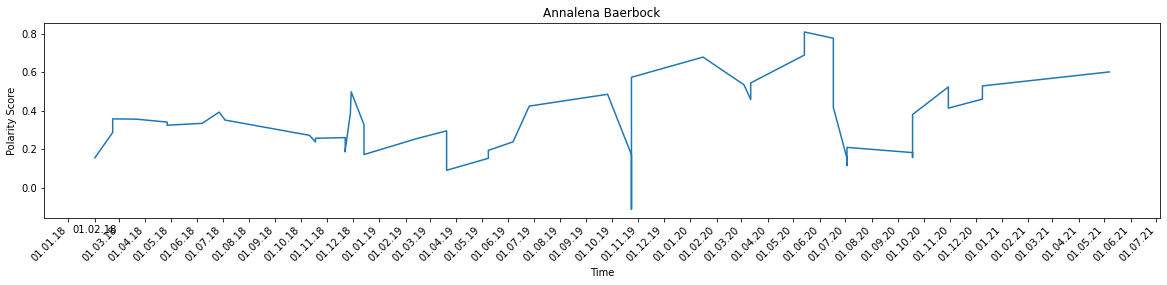

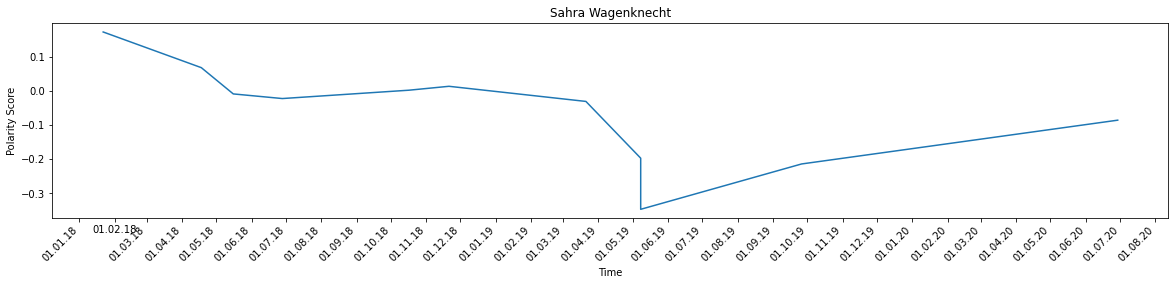

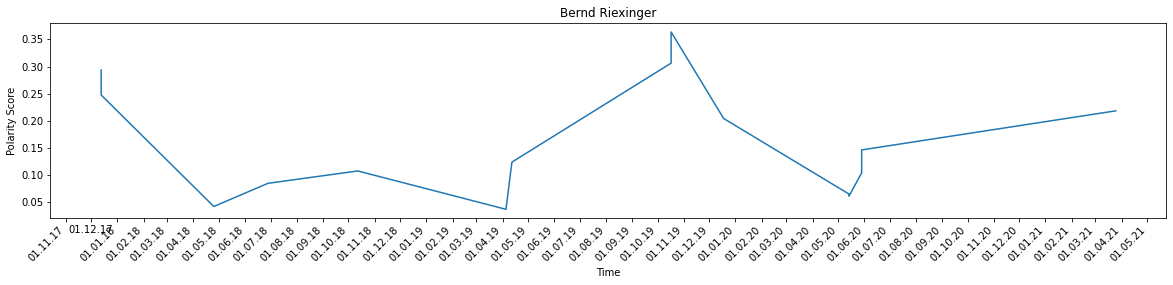

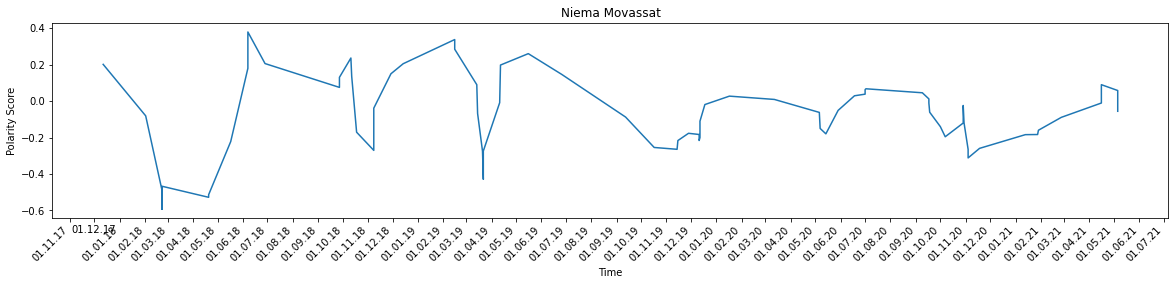

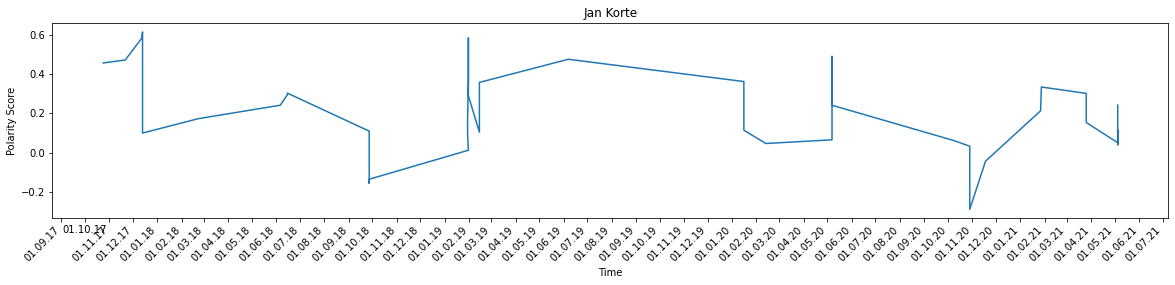

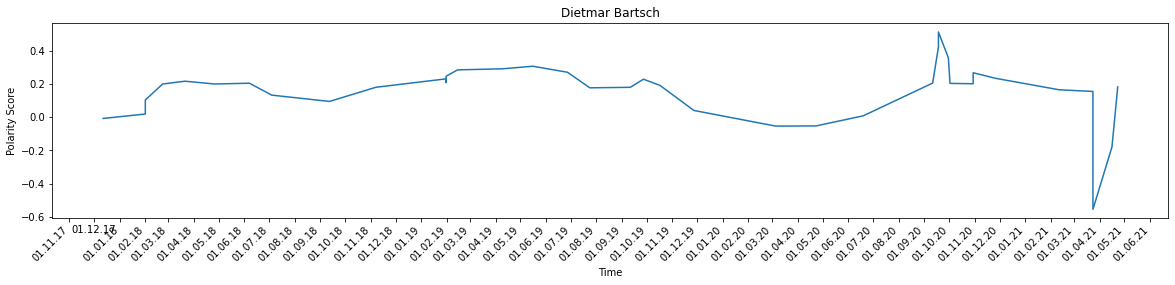

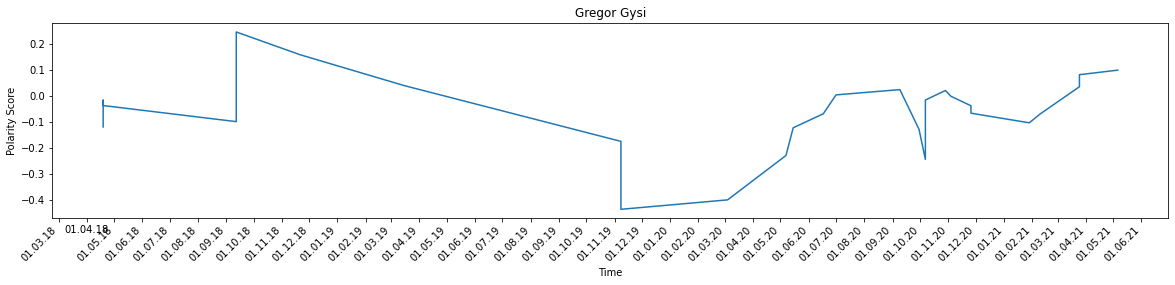

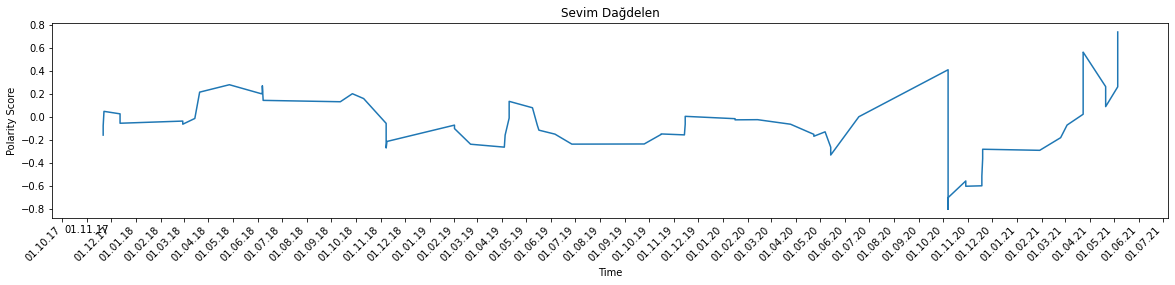

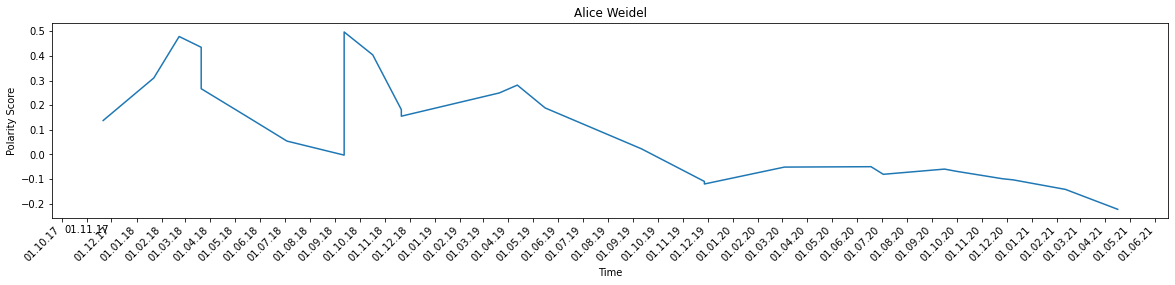

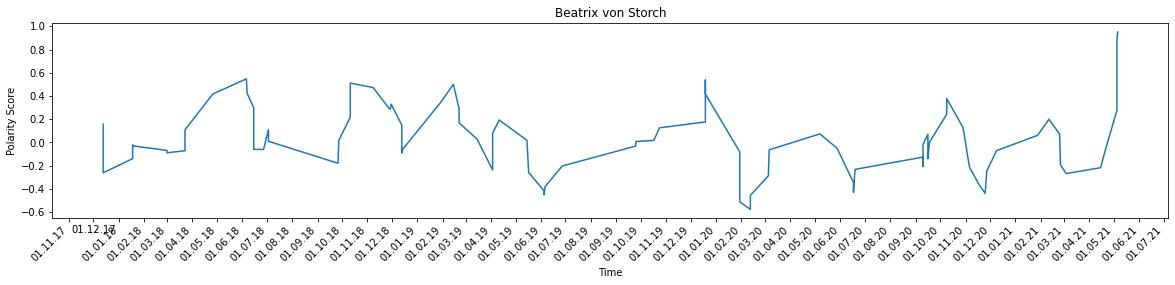

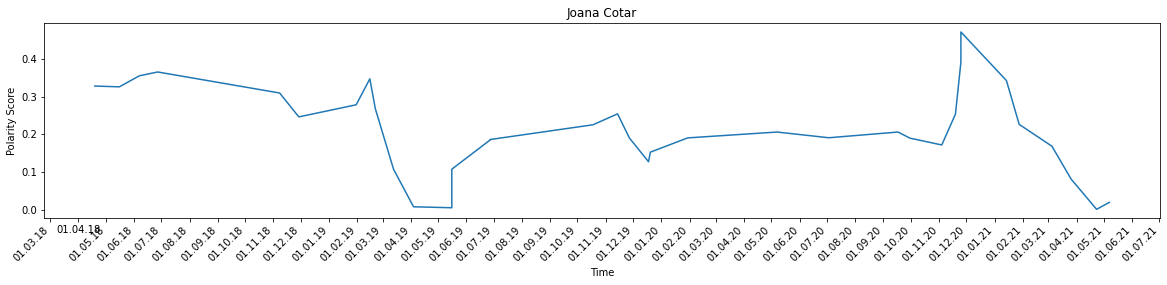

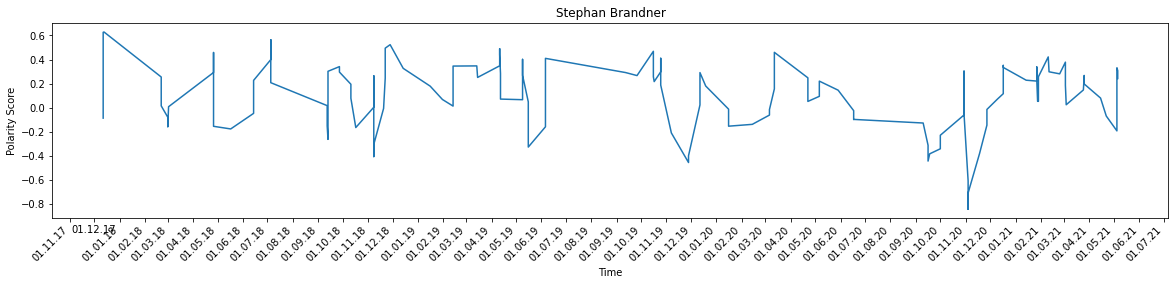

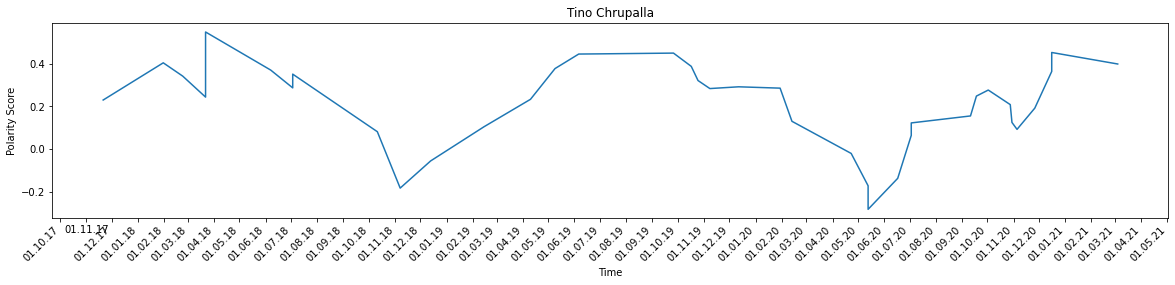

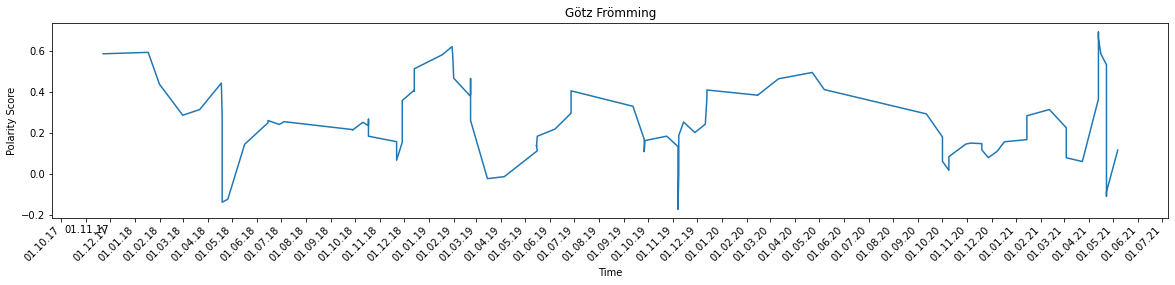

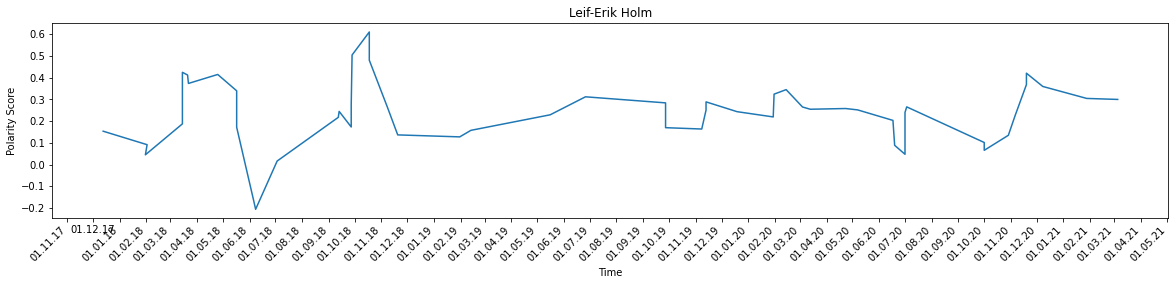

In [180]:
#plot the polarity of speeches over time
i=1
for name in tqdm(['Ralph Brinkhaus','Hermann Gröhe', 'Nadine Schön' ,'Norbert Röttgen' , 'Peter Altmaier' , 'Jens Spahn' , 'Matthias Hauer',
            'Christian Lindner' , 'Marco Buschmann' , 'Bettina Stark-Watzinger', 'Alexander Graf Lambsdorff' , 'Johannes Vogel' , 'Konstantin Kuhle' , 'Marie-Agnes Strack-Zimmermann',
            'Lars Klingbeil' , 'Saskia Esken' , 'Hubertus Heil' , 'Heiko Maas' , 'Martin Schulz' , 'Karamba Diaby' , 'Karl Lauterbach',
            'Steffi Lemke' , 'Cem Özdemir' , 'Katrin Göring-Eckardt' , 'Konstantin von Notz' , 'Britta Haßelmann' , 'Sven Lehmann' , 'Annalena Baerbock',
            'Sahra Wagenknecht' , 'Bernd Riexinger' , 'Niema Movassat' , 'Jan Korte' , 'Dietmar Bartsch' , 'Gregor Gysi' , 'Sevim Dağdelen',
            'Alice Weidel' , 'Beatrix von Storch' , 'Joana Cotar' , 'Stephan Brandner' , 'Tino Chrupalla' , 'Götz Frömming' , 'Leif-Erik Holm']):
    #get speeches from the specific politician
    speeches_analyzing =pre_data_speeches.loc[pre_data_speeches['full_name']==name]
    #create sentiment scores
    blobs=speeches_analyzing['text_preprocessed_sentence'].apply(TextBlob)
    sentiment=[]
    for blob in blobs:
        sentiment.append(blob.sentiment)
    #get the scores
    polarity=[]
    for egg in sentiment:
        polarity.append(egg.polarity)
    #get the desired dates and convert timestamp
    speeches_analyzing['polarity']=polarity
    speeches_analyzing['date']=pd.to_datetime(speeches_analyzing['date'])

    dates=speeches_analyzing['date']
    values=speeches_analyzing['polarity']

    #smooth the curve, higher sigma means more smoothing
    if len(polarity)>18999:
        s=100
    elif len(polarity)>17999:
        s=95
    elif len(polarity)>16999:
        s=90
    elif len(polarity)>15999:
        s=85
    elif len(polarity)>14999:
        s=80
    elif len(polarity)>13999:
        s=75
    elif len(polarity)>12999:
        s=70
    elif len(polarity)>11999:
        s=65
    elif len(polarity)>10999:
        s=60
    elif len(polarity)>9999:
        s=55
    elif len(polarity)>8999:
        s=50
    elif len(polarity)>7999:
        s=45
    elif len(polarity)>6999:
        s=40
    elif len(polarity)>5999:
        s=35
    elif len(polarity)>4999:
        s=30
    elif len(polarity)>3999:
        s=25
    elif len(polarity)>2999:
        s=20
    elif len(polarity)>1999:
        s=15
    elif len(polarity)>1399:
        s=10
    else:
        s=1
    ysmoothed = gaussian_filter1d(values, sigma=s)

    fig = plt.figure(figsize=(20,200))
    ax = fig.add_subplot(42,1,i)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    fig.autofmt_xdate(rotation=45)
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('Polarity Score')
    plt.plot(dates, ysmoothed)
    plt.show()
    i +=1

After seeing the speech corpus, we can conclude that for the speeches we have overall similar sentiment for the different parties in comparison to the Twitter sentiment. However, we can see some significant differences over time due to the nature of giving speeches in the Bundestag in comparison to posting a tweet. Therefore, in our use case the look at the Twitter data may be more informative as we have more day to day updates in the input data. In regards of our research question we can further strengthen our findings that the sentiment is mainly influenced by the party and their actions. This effect also seems to be stronger for the speeches as in the Bundestag less promotions and controversial opinions are given. All in all we can say that in difference to Twitter where the politicians can give a more unfiltered version of their opinions and sentiments to current topics in their Bundestags speeches they need to be conform with their party and have stricter rules placed on them. <br>
In regard of gender we can again see that it doesn't seem to play a important role in the sentiment of the politician and in our case the differences could mainly be attributed to a unbalanced population. <br>
For the trends over time we see that many politicians have relatively stable trend lines and only few very harsh fluctuations in their sentiment. Again this could very well be an effect of the character of the Bundestags speeches that need to be more formal and more in line with their parties program.

Closing this results section we have seen some interesting relationships between the movements and levels in sentiment and in the position and current affairs of the politicians. If we can clearly infer a correlation is still to be validated and tested but at first glance the results especially for the Twitter corpus seem to be promissing to grant an inside in the opinion and agenda of the politicians. All this should be carefully considered as our method needs to be revalidate for this particular application and has clear limitation which we will talk about in the discussion.


# 4.4 Validation sentiment analysis (Stjepan)


As often stressed in literature (cite) we need to revalidate the dictionary used to see if it fits with the application we are trying to analyse. Therefore, we will use gold standard validation to see how well the dictionaries perform in comparison to human coders. We will also check if the inter coder reliability is granted with our two authors coded. <br>
Due to the fact that context plays a major role in deciding how emotions are expressed within a text we need to be especially careful when using a non-specific dictionary to detect sentiment. Working with this limitation we addressed the issue in our validation approach.

First, we load in the needed packages to perform the validation step. We will look at the accuracy, recall, precision and f1 score for the comparison to the gold standard of human coded sentiment. In addition we will use Cohen's Kappa to get a score for the intercoder reliability for the human coded data. These measures should proof useful in determining whether the dictionary performed well for our research questions and topic. <br>
In addition, we also implemented a little interface to perform the gold standard validation which is why we need the ipywidgets library.

### 4.4.1 Validation Twitter

Again we start of our validation with the sentiment scores for the Twitter data. First, we need to transform our dataset in a way that we can apply our gold standard validation. As until now, we got the sentiment in form of a polarity score which is given as a number between -1 and 1, we needed a way to make this scoring system manageable for human coders. (How should they distinguish between a sentiment of 0.0001 and 0.0002?) To make our lifes easier we decided to take a simple scoring system of distributing the tweets into positive, negative and neutral tweets. That way there was a less subjective classification as we can for the most part agree on what positive and negative conotated messages are. To generate the corresponding score generated by the dictionary approach we classified the sentiment as positive if the polarity was positive and negative if the polarity was negative. This only left tweets and speeches with a polarity of 0 as neutral which again needs to critically viewed as the polarity score can be biased in one direction. So we should consider the neutral assignments made by the dictionary with care. Nevertheless, for our gold standard coding we can use this scoring system. <br>
After creating the new score values via a loop we add them as a new column to our dataset.

In [181]:
#set up Twitter dataset for sentiment coding
pre_data_twitter = pd.read_csv('../data/processed/tweets_processed_sentiment.csv')
sentiment=[]
for polarity in pre_data_twitter['polarity_textblob']:
    if polarity>0:
        sentiment.append('Positive')
    elif polarity<0:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
pre_data_twitter['sentiment']=sentiment

In preparation for the validation step we will need to define a function that let's us randomly select a certain number of tweets from our corpus. We do this by simply suffeling the data and afterwards selecting the first tweets until the desired number.

In [182]:
#create a function to chose random tweets for manual coding
def create_sentiment_dataset(data, number):
    data= data.sample(frac=1)
    data_test= data[0:number]
    data_test.reset_index(drop=True, inplace= True)
    return data_test

The next step is to create the interface for the validity testing. Herefore, we also define a function that lets us display buttons we can press to select the wanted sentiment of the coder while going through the randomly selected tweets. After the coder has labeled all the given tweets we save his labels as a new column for the given dataframe and create a file were we save the coded corpus for the coder.

In [183]:
#create the test interface
def sentiment_gold_dictionary_tweets(sentiment_df, name):
    max_count = sentiment_df.shape[0]
    global i
    i = 0

    button_0 = widgets.Button(description = "Positive")
    button_1 = widgets.Button(description = "Neutral")
    button_2 = widgets.Button(description = "Negative")

    chosen_elements = []

    display("Sentiment Gold Standard")

    f = IntProgress(min=0, max=max_count)
    display(f)

    display(sentiment_df.text_preprocessed_sentence[i])

    display(button_0)
    display(button_1)
    display(button_2)


    def btn_eventhandler(obj):
        global i
        i += 1

        clear_output(wait=True)

        display("Sentiment Gold Standard")
        display(f)
        f.value += 1

        choosen_text = obj.description
        chosen_elements.append(choosen_text)

        if i < max_count:

            display(sentiment_df.text_preprocessed_sentence[i])

            display(button_0)
            display(button_1)
            display(button_2)

            button_0.on_click(btn_eventhandler)
            button_1.on_click(btn_eventhandler)
            button_2.on_click(btn_eventhandler)

        else:
            print ("Thanks " + name + " you finished all the work!")
            sentiment_df["choosen_sentiment"] = chosen_elements
            sentiment_df.to_csv("../data/processed/sentiment_gold_standard_tweets_" + name + ".csv", index = False)

    button_0.on_click(btn_eventhandler)
    button_1.on_click(btn_eventhandler)
    button_2.on_click(btn_eventhandler)

    return sentiment_df

In our validation step, we use 40 randomly selected tweets to label manually. We are well aware that the usual suggestion is to label at least 1% of the corpus manually when revalidating. As this would have meant to label over 1000 tweets we settled for fewer but in the same range as for the speeches later.

In [184]:
test_data=create_sentiment_dataset(pre_data_twitter, 40)

After selection, we labeled the tweets with our defined function. While labeling we of course get a glimps of the tweets in the corpus. While most of the tweets seem to contain useful messages there were also some that were rather short or even just one word as there also seem to be replys to tweets.

In [185]:
#test_sentiment=sentiment_gold_dictionary_tweets(test_data,'Stjepan')

When labeling is finished we save the results in a csv file so we can analyze them later.

In [186]:
test_sentiment1=pd.read_csv('../data/processed/sentiment_gold_standard_tweets_Stjepan.csv')

The same labeling with 40 newly selected tweets is done by the second coder so we have a labeled corpus of 80 tweets in total.

In [187]:
test_data=create_sentiment_dataset(pre_data_twitter, 40)

In [188]:
#test_sentiment=sentiment_gold_dictionary_tweets(test_data,'Jakob')

In [189]:
test_sentiment2=pd.read_csv('../data/processed/sentiment_gold_standard_tweets_Jakob.csv')

Afterwards the labeled tweets are combined into one file so we can analyze them.

In [190]:
test_sentiment_both=pd.concat([test_sentiment1,test_sentiment2])

As mentioned, we want to use different metric to see how the dictionary performed with the sentiment analysis. We first look at F1 and Accuracy to get a feeling for the performance and then at Recall and Precision to get further insides on how the performance was achieved. <br>
For the whole corpus of labeled tweets we can see that Accuracy and F1 where rather simliar with around 54%. On a first look this seems like a bad result but when thinking about the performance of dictionary approaches in general a score in this region is really close to the best you can hope for considering we did not tune the dictionary to fit our problem particularly well. When looking at Recall and Precision we can see that those metrics also don't differ to much from the F1 score. <br>
We can plot the confusion matrices for the different labels from our validation corpus to see what kind of errors were made by the dictionary while classifying. We can see some quiet different pictures there for the different labels but overall the dictionary classifier seems to be making both kinds of errors. All in all the performance seems to be fine for the dictionary in TextBlob.

In [191]:
f2=f1_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted')
print('F1 Score:',f2)
accuracy2=accuracy_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'])
print('Accuracy Score:',accuracy2)
precision2=precision_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted',zero_division=1)
print('Precision Score:',precision2)
recall2=recall_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted',zero_division=1)
print('Recall Score:',recall2)
cm = multilabel_confusion_matrix(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'])
display(cm)

F1 Score: 0.5494074201305393
Accuracy Score: 0.5375
Precision Score: 0.6026515151515152
Recall Score: 0.5375


array([[[48,  2],
        [14, 16]],

       [[29, 20],
        [11, 20]],

       [[46, 15],
        [12,  7]]])

For the next step we want to look at the intercoder reliability of our manually coded tweets. This will give us a measure on how reliable the previous result are. Only with a relatively good score here can we be sure to have so good gold standard. We choose 10 randomly selected tweets that will be labeled by both coders on which basis we perform this analysis.

In [192]:
test_data=create_sentiment_dataset(pre_data_twitter, 10)

Then, we again perform the manual coding, this time with both coders having the same tweets.

In [193]:
#test_sentiment=sentiment_gold_dictionary_tweets(test_data,'Stjepan_inter')

In [194]:
#test_sentiment=sentiment_gold_dictionary_tweets(test_data,'Jakob_inter')

Afterwards, we save the results if the manual coding in csv files so we can access them at will.

In [195]:
test_sentiment1=pd.read_csv('../data/processed/sentiment_gold_standard_tweets_Stjepan_inter.csv')
test_sentiment2=pd.read_csv('../data/processed/sentiment_gold_standard_tweets_Jakob_inter.csv')

In the end, we calculate Cohen's Kappa as our reliability measure for which we use a implemented function from the sklearn library. We can see that our score of roughly 68% is an acceptable level of intercoder reliability. There sure is room for improvement but considering that we had no big coding manual for the coders and just relied on simple sentiment impression this seems like a satisfying result.

In [196]:
#kappa
kappa= cohen_kappa_score(test_sentiment1['choosen_sentiment'],test_sentiment2['choosen_sentiment'])
print(kappa)

0.6825396825396826


### 4.4.2 Validation Speeches

Next up are the speeches for which we of course also have revalidate the dictionary approach. Again we load in the data and apply our code to generate a new column which contains the new sentiment scoring system.

In [197]:
#set up Speeches dataset for sentiment coding
pre_data_speeches= pd.read_csv('../data/processed/speeches_processed_sentiment.csv')
sentiment=[]
for polarity in pre_data_speeches['polarity_textblob']:
    if polarity>0:
        sentiment.append('Positive')
    elif polarity<0:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
pre_data_speeches['sentiment']=sentiment

Then we again set up afunction to randomly sample a given amount of tweets that we want to code. (Notice it is the same function as above.)

In [198]:
#create a function to chose random speeches for manual coding
def create_sentiment_dataset(data, number):
    data= data.sample(frac=1)
    data_test= data[0:number]
    data_test.reset_index(drop=True, inplace= True)
    return data_test

Afterwards we create the interface for the manual coding of the speeches by implementing widget that let us select the sentiment for the sampled tweets as above.

In [199]:
#create the test interface
def sentiment_gold_dictionary_speeches(sentiment_df, name):
    max_count = sentiment_df.shape[0]
    global i
    i = 0

    button_0 = widgets.Button(description = "Positive")
    button_1 = widgets.Button(description = "Neutral")
    button_2 = widgets.Button(description = "Negative")

    chosen_elements = []

    display("Sentiment Gold Standard")

    f = IntProgress(min=0, max=max_count)
    display(f)

    display(sentiment_df.text_preprocessed_sentence[i])

    display(button_0)
    display(button_1)
    display(button_2)


    def btn_eventhandler(obj):
        global i
        i += 1

        clear_output(wait=True)

        display("Sentiment Gold Standard")
        display(f)
        f.value += 1

        choosen_text = obj.description
        chosen_elements.append(choosen_text)

        if i < max_count:

            display(sentiment_df.text_preprocessed_sentence[i])

            display(button_0)
            display(button_1)
            display(button_2)

            button_0.on_click(btn_eventhandler)
            button_1.on_click(btn_eventhandler)
            button_2.on_click(btn_eventhandler)

        else:
            print ("Thanks " + name + " you finished all the work!")
            sentiment_df["choosen_sentiment"] = chosen_elements
            sentiment_df.to_csv("../data/processed/sentiment_gold_standard_speeches_" + name + ".csv", index = False)

    button_0.on_click(btn_eventhandler)
    button_1.on_click(btn_eventhandler)
    button_2.on_click(btn_eventhandler)

    return sentiment_df

Again we choose 40 speeches randomly to be coded by hand. This time around this is around 1% of our speech corpus as we have significantly less speeches from the 19. Bundestag. Now every coder has to choose the sentiment of 40 different tweets. The results are again saved as a csv file so they can be accessed later.

In [200]:
test_data=create_sentiment_dataset(pre_data_speeches, 40)

In [201]:
#test_sentiment=sentiment_gold_dictionary_speeches(test_data,'Stjepan')

In [202]:
test_sentiment1=pd.read_csv('../data/processed/sentiment_gold_standard_speeches_Stjepan.csv')

In [203]:
test_data=create_sentiment_dataset(pre_data_speeches, 40)

In [204]:
#test_sentiment=sentiment_gold_dictionary_speeches(test_data,'Jakob')

In [205]:
test_sentiment2=pd.read_csv('../data/processed/sentiment_gold_standard_speeches_Jakob.csv')

After combining the two labeled corpi we can again apply our evaluation metrics. This time around the score are overall lower which lets us believe that the dictionary performed worse on the Bundestag speeches. When looking at the F1 score we see a drop of more than 10% which is a significantly lower result than before. The only score which doesn't seem to have dropped that much is Precision. Reasons for this drop in performance could lie in the different lengths of the speeches in comparison to the tweets and the higher complexity of texts. With this we can cautiously assume that the dictionary struggles to perform well with longer texts as there are more words influencing sentiment and in longer text sentiments could also be changing in different parts of the text.

In [206]:
test_sentiment_both=pd.concat([test_sentiment1,test_sentiment2])

In [207]:
f2=f1_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted')
print('F1 Score:',f2)
accuracy2=accuracy_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'])
print('Accuracy Score:',accuracy2)
precision2=precision_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted',zero_division=1)
print('Precision Score:',precision2)
recall2=recall_score(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'], average='weighted',zero_division=1)
print('Recall Score:',recall2)
cm = multilabel_confusion_matrix(test_sentiment_both['choosen_sentiment'], test_sentiment_both['sentiment'])
display(cm)

F1 Score: 0.3975587794617645
Accuracy Score: 0.3875
Precision Score: 0.5754140866873065
Recall Score: 0.3875


array([[[36,  7],
        [25, 12]],

       [[50,  3],
        [20,  7]],

       [[25, 39],
        [ 4, 12]]])

After these measures we also want to have a look at the intercoder reliability of the human coders. For this we again take 10 speeches which are coded by both authors to determine the reliabilty of the results. We also save these results for future analysis.

In [208]:
test_data=create_sentiment_dataset(pre_data_speeches, 10)

In [209]:
test_sentiment=sentiment_gold_dictionary_speeches(test_data,'Stjepan_inter')

'Sentiment Gold Standard'

IntProgress(value=0, max=10)

'einleitung übrigen problematisch urban gebiet ansprechen thüringen thüringer landesregierungen hören thüringen eigentlich östlich gera problematische stadt herr kollege angesicht angesicht bitte schön'

Button(description='Positive', style=ButtonStyle())

Button(description='Neutral', style=ButtonStyle())

Button(description='Negative', style=ButtonStyle())

In [210]:
test_sentiment=sentiment_gold_dictionary_speeches(test_data,'Jakob_inter')

'Sentiment Gold Standard'

IntProgress(value=0, max=10)

'einleitung übrigen problematisch urban gebiet ansprechen thüringen thüringer landesregierungen hören thüringen eigentlich östlich gera problematische stadt herr kollege angesicht angesicht bitte schön'

Button(description='Positive', style=ButtonStyle())

Button(description='Neutral', style=ButtonStyle())

Button(description='Negative', style=ButtonStyle())

In [211]:
test_sentiment1=pd.read_csv('../data/processed/sentiment_gold_standard_speeches_Stjepan_inter.csv')
test_sentiment2=pd.read_csv('../data/processed/sentiment_gold_standard_speeches_Jakob_inter.csv')

In the end we again compute Cohen's Kappa with help of the sklearn library. We get a value of 53% which is around 15% worse than for the tweets. Again this doesn't seem surprising as these speeches are more complex in their structure and can address multiple issues or issues from different perspectives. With regards to that the Kappa score seems resonable but again there is definitely room for improvement.

In [212]:
#### kappa
kappa= cohen_kappa_score(test_sentiment1['choosen_sentiment'],test_sentiment2['choosen_sentiment'])

In [213]:
print(kappa)

0.53125


In conclusion, we can say that our revalidation showed that the dictionary used to answer our research questions in regard to the sentiment analysis has performed good for a dictionary. As already suggested in (cite) dictionaries seem to struggle to give brilliant results in automated media content analysis due to their limited capacities and harsh assumptions. Nevertheless, for our research they offered a nice approach to gain first insights into the corpus and make reproducable analysis. As mentioned before, in a next step one should definitely view dictionaries as a first approach and try out different technics as machine learning and semi-supervised approaches next.


# 5. Discussion

# 5.1 Discussion topic modelling (Jakob)

This section discusses the procedure and the topic modelling results weaknesses and strengths. For this, we investigate the research design, the data, the preprocessing pipeline, the model and the results based on our previous work.

Our research design was based on comparing the content of politicians' tweets with their speeches in the plenary. As we have large amounts of data, there is a need for automated content analysis solutions to tackle this problem. We decided to use well known and experimental topic model algorithms, which we will discuss in more detail later. Our setup in the programming language Python allowed us to process large amounts of data that we could not have analysed manually. Therefore we conclude that our general research design was sound setup, besides limitations in the data, preprocessing and modelling, that we will discuss in the following paragraphs.

We restricted the data collection to the tweets and speeches of each party's seven most prominent politicians in the 19. Bundestag. Another limitation was the time range of the preprocessed data by the open-discourse team. As they plan to publish up to date data regularly, one could retrieve the new data to update the results. As our pipeline can efficiently process and model the data, one could repeat the research setup with a larger pool of politicians and for more periods of the Bundestag. Based on the short timespan we chose, we only saw a snapshot of the topics and the differences in the two media that could be extended with a more profound setup. A source of bias is in selecting the politicians of the six parties. While we tried to choose a representative sample, the choice of politicians will have led to skewed results, as different politicians have different fields of expertise, and not all of them were represented in our subset. Another issue relating to the politicians is the significantly different amount of speeches and tweets per politician. This problem cannot trivially be solved and must be minded when analysing the data on politicians.

The preprocessing is flexible and extendable to enable different pipelines for different tasks. While the pipeline is based on best practices, there were still problems with not relevant words with high frequency. With a more sophisticated preprocessing, one could identify context-dependent stop words and improve the topic model.

For the topic modelling, we test three approaches. LDA and NNMF are well known and widely used models ([Asmussen & Møller, 2019](https://doi.org/10.1186/s40537-019-0255-7)) that are known to produce good results. The third approach BERTopic is relatively new but showed promising results in previous work and was also the best performing model in our case. The model approaches selection and the testing of different models are already professional. However, we are missing the computational capacities for an extensive hyperparameter optimisation for the BERTopic approach, which would undoubtedly improve the model quality. One should also introduce a train test validation split to better transfer the results to new data when updating the structure.

We implemented a simple version of the topic and word intrusion test to validate the model. The results of this test showed satisfactory validity of our results. One could improve the validation with more annotators and a larger dataset for validation. This extension was, however, out of scope for the two authors.

The analysis of the modelling results was relatively short as the main contribution of this work lies in creating the end-to-end pipeline, including data collection, preprocessing, and modelling. The results could be interpreted in more detail and connected with existing research results in a subsequent project. Especially the comparison of the two media and the deep dive into the parties would have needed more attention.

We identified several next steps in the discussion that could be done in the following research project. Besides extending the data collection to a more considerable period and more politicians, it would be essential to improve the preprocessing and the detection of context-dependent stopwords. One could create an improved model based on this and expanded hyperparameter optimisation. This setup would serve as an optimal fundament for a sophisticated analysis of the topics and comparing both media.

# 5.2 Discussion sentiment analysis (Stjepan)

As we have already touched on in the results section there are points for and against using dictionaries in order to analyze the sentiment of texts. In our specific case we wanted to look into what differences can be seen between the stage of social media and the Bundestag, between different parties, and between the genders of the politicians. We came to the conclusion that we saw noticeable differences between the sentiments of the different parties with most of them being attributed to the orientation of the party itself and it's position towards the governing parties of the 19. Bundestag. Moreover, we have also seen the influence of single events and of political proposals on the sentiment expressed on Twitter and in the Bundestag. Therefore, we could see a difference in the wy sentiment was expressed in the formal context of the Bundestag and on the other hand in a more informal and personal environment on Twitter. What we could not find were noticeable differences in the genders as they seemed rather minor.

In regards to, the methodology used in our research to determine the sentiment of the texts we went with dictionary based approaches as they worked best with our implemented pipeline, the ease of interpretation, and due to the resources given for this project. Also the fact that we had two unlabeled corpi to classify made the implementation of supervised approaches non-feasible. More complex unsupervised models like BERT implementations were to resource heavy to use again at this step as they had been already used for the topic modeling. Semi-supervised approaches could have been a very promissing approach in this regard but would have also take to many resources in the scope of our project. <br>
Therefore, we decided to use dictionary based model in the form of Textblob and the SentiWS implementation in spacy. We compared the two approaches before deciding for TextBlob to test our hypothesis as the results seemed to be more promissing. Here one could argue that the SentiWS results could have been more realistic or maybe in reality fit the data better but as for our research the others seemed to be more insightful we took them. As for ever dicitonary approach the validity of applying the dictionary needed to be questioned as dictionaries often face problems of specific domain and are therefore sensitive to corpus given. This problem can of course also be addressed by extending the dictionary with more domain specific language and by considering moe specific filterings of the raw texts. In this aspect the influence of our preprocessing should also not be left unregarded as we have tried to make the texts more suitable for the approach. Again, there are more possibilities to be explored in this regard as we could have tried different preprocessing approaches or even left them almost completely. <br>
As for the validity problem we implemented our own revalidation step which we used to test the results against a gold standard human coded part of the corpus. Here it needs to be noted that this should at least be done with one per cent of the corpus as suggested by literature (cite). In case of the speeches we fulfilled this requirement but for the tweets we settled for less as the corpus was to large. This could be extended and even more methods of manual coding could be inplemented in further research. One could also think about more ways to boost the reliability of the gold standard and clear systematic biases through more complex coding manual or more testing and coding run throughs. <br>
Another problem we face are the assumptions made by the dictionary approach. As it is a bag-of-words approach we are not really considering the order of the sentences. Therefore, we can miss negations, the function of a word in a sentence is not considered and we can't account for irony in texts. Furthermore, we are getting an additivity assumption which assigns a higher sentiment score to a higher frequency of sentiment words again ignoring sentence structures. In addition through the additivity assumption we get a problem with the length of texts as it gets correlated to the sentiment of the text (cite). As we have a big differences in length due to the tweets being rather short and the speeches rather long we can't be sure that the dictionary measure is comparable for the different medias. One should definetly try to account for the variablity in length of text in future research and look further into possibilities to make the dictionary more robust to circumvent these problems. In our case, we could definitely see a lower performance for the Bundetags speeches which makes all conclusions made from them less valid.

As with media content analysis in general but also for sentiment analysis context and perspective have a great influence on results and make an analysis hard. Considering this our approach on politicians sentiments was surely very ambitious as we are facing a long period of time analyzed and many different contexts discussed in that period. Nevertheless, we could se some noticeable patterns in the way the sentiment behaved for the politicians in relation to current topics, party affiliations, and personal views. <br>
All in all with our analysis we were able to find some interest relations that should definitely be looked into further in future research. Moreover, there are plenty more technics that can be used in order to get better insights into sentiment of politicians from the German Bundestag. In future, one could try to find more determining factors for the sentiment of parties and individuals. What also seems to be promissing is the approach to combine sentiment analysis with the topic modelling discussed in this research report. Through that one could look deeper into the reasons how certain topics affect sentiment. <br>
Another possible future research could be interested in the prediction of sentiment through machine learning models. This approach would be interested then in finding patterns and signs for changes in sentiment. This could than tried to used to anticipate the success of political proposals or other initiatives. Certainly the future work done on basis of this research seems promissing.


# 6. Bibliography (Stjepan)

Asmussen, C.B. & Møller, C. (2019). *Smart literature review: a practical topic modelling approach to exploratory literature review*. Journal of Big Data, 6(93). https://doi.org/10.1186/s40537-019-0255-7

Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). *Latent dirichlet allocation*. Journal of machine Learning research, 3, 993-1022.

Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei. D. M. (2009). *Reading tea leaves: how humans interpret topic models*. In Proceedings of the 22nd International Conference on Neural Information Processing Systems. Curran Associates Inc., Red Hook, NY, USA, 288–296.

Dietz, L. (2016). *Topic Model Evaluation: How much does it help?* [PowerPoint slides]. Topic Model Tutorial at WebSci2016, University of Mannheim. http://topicmodels.info/ckling/tmt/part4.pdf


Effing, R., van Hillegersberg, J., & Huibers, T. (2011) *Social Media and Political Participation: Are Facebook, Twitter and YouTube Democratizing Our Political Systems?*. In: Tambouris E., Macintosh A., de Bruijn H. (eds) Electronic Participation. ePart 2011. Lecture Notes in Computer Science, vol 6847. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-23333-3_3

Fatema, S., Yanbin, L., & Fugui, D. (2020). *Impact of Social Media on Politician/Citizens Relationship*. In The 11th International Conference on E-business, Management and Economics. Association for Computing Machinery, New York, NY, USA, 109–114. https://doi.org/10.1145/3414752.3414787

Ferrara, E., Chang, H., Chen, E., Muric, G., & Patel, J. (2020). *Characterizing social media manipulation in the 2020 U.S. presidential election*. First Monday, 25(11). https://doi.org/10.5210/fm.v25i11.11431

Grootendorst, M., & Reimers, N. (2021). MaartenGr/BERTopic: v0.9.4 (v0.9.4). Zenodo. https://doi.org/10.5281/zenodo.5779238

Kapadia, S. (2019, August 19). *Evaluate Topic Models: Latent Dirichlet Allocation (LDA)*. towardsdatascience.com. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

McLaughlin B. & Macafee, T (2019). *Becoming a Presidential Candidate: Social Media Following and Politician Identification*. Mass Communication and Society, 22(5), 584-603. https://doi.org/10.1080/15205436.2019.1614196

Ott, B. L. (2017). *The age of Twitter: Donald J. Trump and the politics of debasement*. Critical Studies in Media Communication, 34(1), 59-68. https://doi.org/10.1080/15295036.2016.1266686

Rehurek, R., & Sojka, P. (2010). *Software framework for topic modelling with large corpora*. In In Proceedings of the LREC 2010 workshop on new challenges for NLP frameworks.

Richter, F., Koch, P., Franke, O., Kraus, J., Kuruc, F., Thiem, A., Högerl, J., Heine, S., & Schöps, K. (2020). Open Discourse. https://github.com/open-discourse/open-discourse

Röder, M., Both, A., & Hinneburg, A. (2015). *Exploring the Space of Topic Coherence Measures*. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining. Association for Computing Machinery, New York, NY, USA, 399–408. https://doi.org/10.1145/2684822.2685324

Wang, Y. X., & Zhang, Y. J. (2013). *Nonnegative Matrix Factorization: A Comprehensive Review*. IEEE Transactions on Knowledge and Data Engineering, 25(6), 1336-1353. https:doi.org/10.1109/TKDE.2012.51.

Wright, S. (2021). *Beyond ‘fake news’? A longitudinal analysis of how Australian politicians attack and criticise the media on Twitter*. Journal of Language and Politics, 20(5), 719-740. https://doi.org/10.1075/jlp.21027.wri

Zimmer, M., & Proferes, N.J. (2014). *A topology of Twitter research: disciplines, methods, and ethics*. Journal of Information Management, 66(3), 250-261. https://doi.org/10.1108/AJIM-09-2013-0083